
### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com 


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
import os
import shutil
import yaml
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import sqlite3
from typing import TypedDict, Annotated
import requests

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser
from langchain_community.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.errors import NodeInterrupt

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

# import pyperclip
# import shlex

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT,
                        TOP_CATEGORIES_PROMPT, TOPIC_REWRITE_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES,
                        SCREENSHOT_DIR, sleeptime

                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens,
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)

from AInewsbot_langgraph import (newscatcher_sources, fn_initialize, fn_download_sources, fn_extract_urls, fn_check_downloads,
    fn_extract_newscatcher, fn_filter_urls, fn_topic_clusters, fn_topic_analysis, fn_download_pages, fn_summarize_pages, 
    fn_propose_cats, fn_compose_summary, fn_rewrite_summary, fn_is_revision_complete, fn_send_mail
)

import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()

import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

from bs4 import BeautifulSoup

import pdb



In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:26:25) [Clang 17.0.6 ]
LangChain         0.3.8
OpenAI            1.55.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.7
podcastfy         0.4.1


# Test LLM calling

In [4]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


2024-11-25 10:44:21,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


AIMessage(content='Ascoltami. Sei bellissima. Sei perfetta e ti amo.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 34, 'total_tokens': 50, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'chatgpt-4o-latest', 'system_fingerprint': 'fp_28935134ad', 'finish_reason': 'stop', 'logprobs': None}, id='run-d85ccccb-d9e3-4413-ad8e-ea932301fc1c-0', usage_metadata={'input_tokens': 34, 'output_tokens': 16, 'total_tokens': 50, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [5]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


2024-11-25 10:44:21,840 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


'Ciao'

In [6]:
# time multiple templates (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


2024-11-25 10:44:22,228 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.

2024-11-25 10:44:23,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hör mir zu. Du bist makellos. Du bist exquisit und ich liebe dich.

2024-11-25 10:44:23,964 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Escúchame. Eres perfecta. Eres preciosa y te amo.

2024-11-25 10:44:24,989 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Ascoltami. Sei incredibile. Sei magnifico/a e ti amo.

2024-11-25 10:44:25,504 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Hallgass rám. Elragadó vagy. Lenyűgöző vagy, és szeretlek.

Elapsed seconds: 3.840934


In [7]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


2024-11-25 10:44:26,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-25 10:44:26,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-25 10:44:26,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-25 10:44:26,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-25 10:44:27,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"




Elapsed seconds: 1.597069
Écoute-moi. Tu es parfait(e). Tu es magnifique et je t'aime.
Hör mir zu. Du bist makellos. Du bist exquisit, und ich liebe dich.
Escúchame. Eres perfecta. Eres hermosa y te amo.
Ascoltami. Sei incredibile. Sei magnifico/a e ti amo.
Hallgass rám. Elragadó vagy. Lenyűgöző vagy, és szeretlek.


In [8]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Define LangGraph agent state graph

In [9]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: list[dict]                    #  the current working set of headlines (pandas dataframe not supported)
    before_date: str                    #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool                   #  if False use existing files, else download from sources
    sources: dict                       #  sources to scrap
    sources_reverse: dict[str, str]     #  map file names to sources
    bullets: list[str]                  #  bullet points for summary email
    summary: str                        #  final summary
    cluster_topics: list[str]           #  list of cluster topics
    topics_str: str                     #  edited topics
    n_edits: int                        #  count edit iterations so we don't keep editing forever
    edit_complete: bool                 #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [10]:
# sqlite schema to store previously processed headlines
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [11]:
# some debugging stuff, check a headline is cached properly
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")]
# xdf.loc[xdf["title"].str.startswith("NHTSA")]

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [12]:
class Agent:

    def __init__(self, state):

        self.state = state

        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("check_download", self.check_download)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "check_download")
        graph_builder.add_edge("check_download", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,)
#                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def check_download(self, state: AgentState) -> AgentState:
        self.state = fn_check_downloads(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state

    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )

        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    print("AIdf:")
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print("sources:")
                    print([k for k in event.get('sources').keys()])
            except Exception as exc:
                print(exc)

        return self.state



# Instantiate agent and run LangGraph workflow graph end to end

In [13]:
def initialize_agent(do_download, before_date):
    # initial state
    state = AgentState({
        'AIdf': [{}],
        'before_date': before_date,
        'do_download': do_download,
        'sources': {},
        'sources_reverse': {},
        'bullets': '',
        'summary': '',
        'cluster_topics': [],
        'topics_str': '',
        'n_edits': 0,
        'edit_complete': False,
    })
    thread_id = uuid.uuid4().hex
    log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}"
        )
    return state, Agent(state), thread_id
    

2024-11-25 10:44:29,654 - AInewsbot - INFO - Initializing with before_date=2024-11-24 15:00:00, do_download=False, thread_id=5ba3cc5962914e75b688cbc6b7519aaf


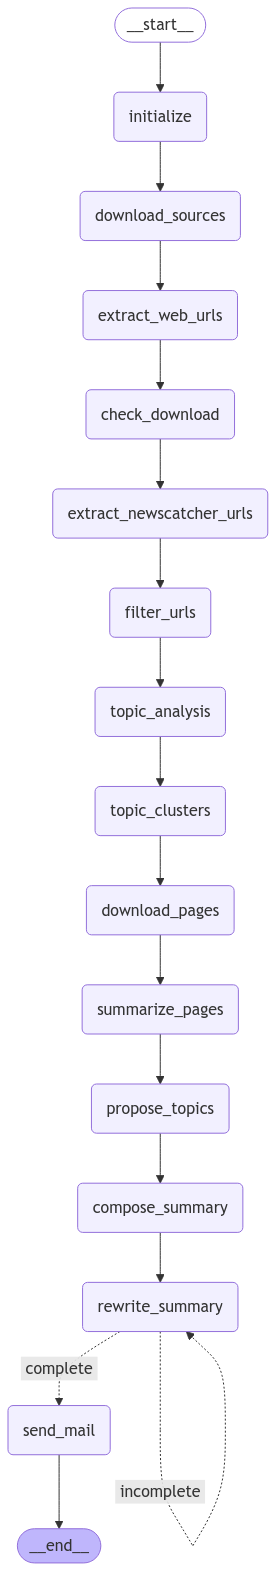

2024-11-25 10:44:29,800 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2024-11-25 10:44:29,802 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-11-25 10:44:29,802 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-11-25 10:44:29,803 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-11-25 10:44:29,803 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-11-25 10:44:29,803 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-11-25 10:44:29,804 - AInewsbot - INFO - 

'src'
'src'
'src'


2024-11-25 10:44:30,006 - AInewsbot - INFO - parse_file - found 309 raw links
2024-11-25 10:44:30,010 - AInewsbot - INFO - parse_file - found 52 filtered links
2024-11-25 10:44:30,011 - AInewsbot - INFO - 52 links found
2024-11-25 10:44:30,011 - AInewsbot - INFO - FT Tech -> htmldata/FT Technology (11_25_2024 10_41_06 AM).html
2024-11-25 10:44:30,039 - AInewsbot - INFO - parse_file - found 487 raw links
2024-11-25 10:44:30,044 - AInewsbot - INFO - parse_file - found 121 filtered links
2024-11-25 10:44:30,045 - AInewsbot - INFO - 121 links found
2024-11-25 10:44:30,045 - AInewsbot - INFO - Feedly AI -> htmldata/Feedly AI (11_25_2024 10_42_25 AM).html
2024-11-25 10:44:30,064 - AInewsbot - INFO - parse_file - found 95 raw links
2024-11-25 10:44:30,065 - AInewsbot - INFO - parse_file - found 28 filtered links
2024-11-25 10:44:30,065 - AInewsbot - INFO - 28 links found
2024-11-25 10:44:30,066 - AInewsbot - INFO - Hacker News -> htmldata/Hacker News Page 1 (11_25_2024 10_41_16 AM).html
2024-

id
src                  
Ars Technica       28
Bloomberg Tech     13
Business Insider   51
FT Tech            66
Feedly AI          28
Hacker News        26
Hacker News 2      25
HackerNoon        102
NYT Tech           17
Reddit            242
Techmeme          144
The Register      107
The Verge          32
VentureBeat        42
WSJ Tech           27
WaPo Tech          39

2024-11-25 10:44:30,532 - AInewsbot - INFO - check_downloads passed, found 16 sources in AIdf, 0 missing


id
src                  
Ars Technica       28
Bloomberg Tech     13
Business Insider   51
FT Tech            66
Feedly AI          28
Hacker News        26
Hacker News 2      25
HackerNoon        102
NYT Tech           17
Reddit            242
Techmeme          144
The Register      107
The Verge          32
VentureBeat        42
WSJ Tech           27
WaPo Tech          39

2024-11-25 10:44:30,536 - AInewsbot - INFO - Fetching top 100 stories matching Artificial Intelligence from Newscatcher


id
src                  
Ars Technica       28
Bloomberg Tech     13
Business Insider   51
FT Tech            66
Feedly AI          28
Hacker News        26
Hacker News 2      25
HackerNoon        102
NYT Tech           17
Newscatcher       100
Reddit            242
Techmeme          144
The Register      107
The Verge          32
VentureBeat        42
WSJ Tech           27
WaPo Tech          39

2024-11-25 10:44:31,148 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-11-24 15:00:00'
2024-11-25 10:44:31,307 - AInewsbot - INFO - URLs in orig_df: 1089
2024-11-25 10:44:31,311 - AInewsbot - INFO - Existing URLs in DB: 185458
2024-11-25 10:44:31,361 - AInewsbot - INFO - New URLs in df filtered by URL: 429
2024-11-25 10:44:31,476 - AInewsbot - INFO - Existing src+title: 32
2024-11-25 10:44:31,476 - AInewsbot - INFO - New URLs in df filtered by src+title: 397
2024-11-25 10:44:31,487 - AInewsbot - INFO - Found 384 unique new headlines
2024-11-25 10:44:31,620 - AInewsbot - INFO - Applying prompt to 8 pages using gpt-4o-mini
2024-11-25 10:44:31,620 - AInewsbot - INFO - sent 50 items 
2024-11-25 10:44:31,621 - AInewsbot - INFO - sent 50 items 
2024-11-25 10:44:31,621 - AInewsbot - INFO - sent 50 items 
2024-11-25 10:44:31,621 - AInewsbot - INFO - sent 50 items 
2024-11-25 10:44:31,622 - AInewsbot - INFO - sent 50 items 
2024-11-25 10:44:31,622 - AInewsbot - 

id
src                 
Bloomberg Tech     1
Business Insider   3
Feedly AI         24
Hacker News        1
Hacker News 2      2
HackerNoon         9
NYT Tech           1
Newscatcher       47
Reddit            11
Techmeme           4
The Register       3
The Verge          1
VentureBeat        2

2024-11-25 10:44:39,719 - AInewsbot - INFO - start free-form topic extraction
2024-11-25 10:44:39,719 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-11-25 10:44:39,720 - AInewsbot - INFO - sent 50 items 
2024-11-25 10:44:39,720 - AInewsbot - INFO - sent 50 items 
2024-11-25 10:44:39,721 - AInewsbot - INFO - sent 9 items 
2024-11-25 10:44:43,021 - AInewsbot - INFO - got dict with 9 items 
2024-11-25 10:44:46,655 - AInewsbot - INFO - got dict with 50 items 
2024-11-25 10:44:47,097 - AInewsbot - INFO - got dict with 50 items 
2024-11-25 10:44:47,101 - AInewsbot - INFO - Processed 109 responses.
2024-11-25 10:44:47,104 - AInewsbot - INFO - 109 free-form topics extracted
2024-11-25 10:44:47,107 - AInewsbot - INFO - ['creativity', 'generative ai', 'llms', '2025', 'apple', 'china', 'business strategy', 'investment', 'hollywood', 'disruption', 'stock market', 'amd', 'deepfakes', 'security', 'arms race', 'defense', 'chatgpt', 'gemini', 'ai models', 'google', 'crowdstrike

id
src                 
Bloomberg Tech     1
Business Insider   3
Feedly AI         24
Hacker News        1
Hacker News 2      2
HackerNoon         9
NYT Tech           1
Newscatcher       47
Reddit            11
Techmeme           4
The Register       3
The Verge          1
VentureBeat        2

2024-11-25 11:01:03,446 - AInewsbot - INFO - Fetching embeddings for 109 headlines
2024-11-25 11:01:04,642 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2024-11-25 11:01:04,845 - AInewsbot - INFO - Sort with nearest_neighbor_sort sort
2024-11-25 11:01:04,874 - AInewsbot - INFO - Load umap dimensionality reduction model
2024-11-25 11:01:06,478 - AInewsbot - INFO - Perform dimensionality reduction
2024-11-25 11:01:08,096 - AInewsbot - INFO - Cluster with DBSCAN


id  \
0   0   
1   1   
2   2   
3   3   

                                                                                                                                                                                                                                                                  title_topic_str  
0                                                                                                                                 A tangled web of companies have a stake in the biggest AI companies. Dive in and see (Topics: Companies, Investment, Stocks, Technology Sector)  
1                                       POET Technologies Inc. (POET) Gains Momentum with AI-Driven Optoelectronic Innovations and Upgraded Price Target (Topics: Finance, Funding, Gen AI, Hardware, Innovations, Optoelectronics, Poet Technologies, Products, Science, Stocks)  
2  Shares of Japan's Fujikura, which specializes in fiber optic cables for data centers, are up 400%+ in 2024 due to the AI boom, leading the Nikkei 225 index (Topics: AI Boom, Data Centers, Economics, Fiber Optic Cables, Finance, Fujikura, Gen AI, Hardware, Japan, Stocks)  
3                                      CrowdStrike Holdings, Inc. (CRWD) AI-Driven Cybersecurity: Analyst Predicts Strong Q3 Results (Topics: Crowdstrike, Cybersecurity, Economics, Finance, Gen AI, Privacy & Surveillance, Products, Q3 Results, Safety And Alignment, Stocks)

2024-11-25 11:01:09,149 - AInewsbot - INFO - {'topic_title': 'AI Investments and Innovations'}
2024-11-25 11:01:09,151 - AInewsbot - INFO - I dub this cluster: AI Investments and Innovations


id  \
4   4   
5   5   
6   6   

                                                                                                                                                                                                                                                                                                       title_topic_str  
4  Stanford Professor Allegedly Submits Fake AI Citations in Argument On Deepfake Harms (Topics: AI Doom, AI Ethics, Bias And Fairness, Cognitive Science, Deepfake, Deepfakes, Disinformation, Ethics, Fake Citations, Gen AI, Intellectual Property, Legal Issues, Opinion, Safety And Alignment, Science, Stanford)  
5          Beware of deepfakes used by foreign spies to target China: security ministry (Topics: AI Doom, China, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Foreign Spies, Governance, Military, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Security, Society & Culture)  
6                 How to We Stop Deepfakes From Tricking Juries? (Topics: AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Intellectual Property, Juries, Legal Issues, Legal System, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture)

2024-11-25 11:01:10,069 - AInewsbot - INFO - {'topic_title': 'Deepfakes and AI Ethics'}
2024-11-25 11:01:10,071 - AInewsbot - INFO - I dub this cluster: Deepfakes and AI Ethics


id  \
7   7   
8   8   
9   9   

                                                                                                                                                                                                                                                                                      title_topic_str  
7                 CrowdStrike Holdings, Inc. (CRWD) Gains Momentum with AI-Powered Cybersecurity and $375 Price Target Upgrade (Topics: Crowdstrike, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Price Target Upgrade, Privacy & Surveillance, Products, Safety And Alignment, Stocks)  
8                                                                            Goldman Sachs: Advanced Micro Devices, Inc. (NASDAQ:AMD) Is A Top AI Growth Investor Stock (Topics: Amd, Economics, Finance, Gen AI, Goldman Sachs, Growth, Hardware, Investment, Products, Semiconductor Chips, Stocks)  
9  Cadence Design Systems, Inc. (CDNS) Initiated as Overweight by Wells Fargo with $350 Target, Citing AI Monetization and Hardware Growth (Topics: Cadence Design Systems, Deals, Economics, Finance, Funding, Gen AI, Hardware, Hardware Growth, Investment, Products, Semiconductor Chips, Stocks)

2024-11-25 11:01:10,998 - AInewsbot - INFO - {'topic_title': 'AI in Finance and Technology Investments'}
2024-11-25 11:01:10,999 - AInewsbot - INFO - I dub this cluster: AI in Finance and Technology Investments


id  \
10  10   
11  11   
12  12   
13  13   

                                                                                                                                                                                                                                                                                                                                                        title_topic_str  
10  ChatGPT Gets Better at Creative Writing With New Update (Topics: Art & Design, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Creative Writing, Entertainment, Gen AI, Intellectual Property, Language Models, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Updates, Virtual Assistants)  
11                                                                                                                                   ChatGPT took over stack overflow!, a website for programming related discussions (Topics: Chatbots, Chatgpt, Code Assistants, Community, Gen AI, Job Automation, Language Models, Programming, Stack Overflow, Virtual Assistants)  
12                                                                                                                                         How are college students using AI tools like ChatGPT? (Topics: AI Tools, Chatbots, Chatgpt, Code Assistants, Cognitive Science, College Students, Education, Gen AI, Language Models, Society & Culture, Virtual Assistants)  
13                                                                                                                                                                Does Chatgpt accelerated your learning curve? (Topics: Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Education, Language Models, Learning Curve, Opinion, Virtual Assistants)

2024-11-25 11:01:11,990 - AInewsbot - INFO - {'topic_title': 'ChatGPT and AI in Education'}
2024-11-25 11:01:11,992 - AInewsbot - INFO - I dub this cluster: ChatGPT and AI in Education


id  \
14  14   
15  15   
16  16   

                                                                                                                                                                                                                                         title_topic_str  
14  Tens of millions of devices are thrown away each year  and the rise of generative AI will only make this worse (Topics: AI Doom, Climate, Environment, Ethics, Gen AI, Generative AI, Inequality, Opinion, Society & Culture, Sustainability, Waste)  
15                                                      New AI-Driven Observatory Aims to Revolutionise Energy Poverty Research (Topics: Climate, Economics, Energy, Energy Poverty, Gen AI, Inequality, Observatory, Research, Science, Sustainability)  
16                                                                                        How AI Will Soon Disrupt the Greater Energy Industry (Topics: Climate, Disruption, Economics, Energy, Energy Industry, Gen AI, Job Automation, Sustainability)

2024-11-25 11:01:12,839 - AInewsbot - INFO - {'topic_title': 'AI and Sustainability Challenges'}
2024-11-25 11:01:12,840 - AInewsbot - INFO - I dub this cluster: AI and Sustainability Challenges


id  \
17  17   
18  18   
19  19   
20  20   

                                                                                                                                                                                                         title_topic_str  
17                                           HyperHuman Tops Image Generation Models in User Study (Topics: AI Models, Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Review, Science, User Study)  
18  HyperHuman vs. ControlNet, SDXL, and More: The Ultimate Human Image Generation Showdown (Topics: Art & Design, Comparison, Computer Vision, Controlnet, Gen AI, Hyperhuman, Image Generation, Review, Science, Sdxl)  
19                                                         In-Depth Analysis of Human Image Generation Models (Topics: Analysis, Art & Design, Computer Vision, Gen AI, Human Models, Image Generation, Review, Science)  
20                                   Two years ago I generated my first AI image of Tom Selleck and Gumby. (Topics: Art & Design, Computer Vision, Entertainment, Gen AI, Gumby, Image Generation, Opinion, Tom Selleck)

2024-11-25 11:01:13,538 - AInewsbot - INFO - {'topic_title': 'Human Image Generation Models'}
2024-11-25 11:01:13,539 - AInewsbot - INFO - I dub this cluster: Human Image Generation Models


id  \
21  21   
22  22   
23  23   

                                                                                                                                                                                                                                                                                                                                                                                                           title_topic_str  
21                                                                                                                     Most Gen Zers are terrified of AI taking their jobs. Their bosses consider themselves immune (Topics: AI Doom, Bias And Fairness, Economics, Ethics, Gen AI, Gen Z, Inequality, Job Automation, Job Fears, Jobs & Careerslabor Market, Opinion, Safety And Alignment, Society & Culture, Workplace)  
22                                                       Study Finds 76% of Cybersecurity Professionals Believe AI Should Be Heavily Regulated (Topics: AI Doom, AI Regulation, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Professionals, Safety And Alignment, Science, Society & Culture, Study)  
23  Workplace Nightmare: AI Software Tracks 30-Second Breaks And Alert Boss; Internet Slams Treating People Like Machines (Topics: AI Doom, Bias And Fairness, Breaks, Consciousness, Employee Monitoring, Ethics, Gen AI, Inequality, Internet Backlash, Job Automation, Jobs & Careerslabor Market, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Workplace)

2024-11-25 11:01:14,142 - AInewsbot - INFO - {'topic_title': 'AI Impact on Jobs and Society'}
2024-11-25 11:01:14,142 - AInewsbot - INFO - I dub this cluster: AI Impact on Jobs and Society
2024-11-25 11:01:14,149 - AInewsbot - INFO - ['AI Investments and Innovations', 'Deepfakes and AI Ethics', 'AI in Finance and Technology Investments', 'ChatGPT and AI in Education', 'AI and Sustainability Challenges', 'Human Image Generation Models', 'AI Impact on Jobs and Society']


AI Investments and Innovations

Deepfakes and AI Ethics

AI in Finance and Technology Investments

ChatGPT and AI in Education

AI and Sustainability Challenges

Human Image Generation Models

AI Impact on Jobs and Society

2024-11-25 11:01:14,184 - AInewsbot - INFO - Queuing URLs for scraping
2024-11-25 11:01:14,188 - AInewsbot - INFO - fetching 109 pages using 4 browsers
2024-11-25 11:01:14,189 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 14919
2024-11-25 11:01:14,190 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 14919
2024-11-25 11:01:14,191 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 14919
2024-11-25 11:01:14,191 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 14919
2024-11-25 11:01:32,607 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-25 11:01:32,608 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-25 11:01:32,608 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-25 11:01:32,608 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-11-25 11:01:32,608 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-11-25 11:01:32,608 - AInewsbot - IN

AI Investments and Innovations

Deepfakes and AI Ethics

AI in Finance and Technology Investments

ChatGPT and AI in Education

AI and Sustainability Challenges

Human Image Generation Models

AI Impact on Jobs and Society

2024-11-25 11:07:57,372 - AInewsbot - INFO - Starting summarize
2024-11-25 11:07:57,411 - AInewsbot - INFO - fetch_all_summaries - Page title: A tangled web of companies have a stake in the biggest AI companies. Dive in and see - Sherwood News
Social card title: A tangled web of companies have a stake in the biggest AI companies. Dive in and see
Social card description: AI’s class of corporate investors goes beyond Big Tech....

2024-11-25 11:07:57,574 - AInewsbot - INFO - fetch_all_summaries - Page title: POET Technologies Inc. (POET) Gains Momentum with AI-Driven Optoelectronic Innovations and Upgraded Price Target
Social card title: POET Technologies Inc. (POET) Gains Momentum with AI-Driven Optoelectronic Innovations and Upgraded Price Target
Social card description: We recently compiled a list of the 10 AI News and Ratings Investors Should Not Miss. In this article, we are going to take a look at where POET Technologies Inc. (NASDAQ:POET) stands against the other AI stocks. News a

[1. A tangled web of companies have a stake in the biggest AI companies. Dive in and see - Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)  

 AI Investments and Innovations, Companies, Investment, Stocks, Technology Sector  

- Billions are being invested in AI startups, with scrutiny from the Federal Trade Commission, as companies like Amazon, Microsoft, and Nvidia stake claims in leading firms like OpenAI and Anthropic.
- A reported environmental compliance failure at Tesla's Austin plant has raised concerns about pollution during the production of the Model Y, countering its sustainability mission.
- The coffee market is facing price surges due to low rainfall in Brazil, affecting production estimates and driving up costs for businesses like Nestle and Starbucks. 



[2. POET Technologies Inc. (POET) Gains Momentum with AI-Driven Optoelectronic Innovations and Upgraded Price Target - Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html)  

 AI Investments and Innovations, Finance, Funding, Gen AI, Hardware, Innovations, Optoelectronics, Poet Technologies, Products, Science, Stocks  

- POET Technologies Inc. is gaining traction in the AI sector with its optoelectronic solutions that enhance data transfer in AI data centers.
- Analysts have upgraded the price target for POET stock from \\$3.50 to \\$5.50, maintaining a Buy rating amid growing AI investments.
- The broader report highlights a shift towards hardware-centric AI development, which poses long-term financial risks and challenges for startups due to their capital-intensive nature. 



[3. Shares of Japan's Fujikura, which specializes in fiber optic cables for data centers, are up 400%+ in 2024 due to the AI boom, leading the Nikkei 225 index - Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock)  

 AI Investments and Innovations, AI Boom, Data Centers, Economics, Fiber Optic Cables, Finance, Fujikura, Gen AI, Hardware, Japan, Stocks  

- Fujikura Ltd., a 139-year-old Japanese cable company, has seen its stock price rise over 400% this year, becoming the best performer on the Nikkei 225 index due to increased demand for data centers driven by the AI boom.
- The company will be added to the MSCI global indexes on November 25, marking it as the only new addition from Japan while eight other companies will be removed. 



[4. CrowdStrike Holdings, Inc. (CRWD) AI-Driven Cybersecurity: Analyst Predicts Strong Q3 Results - Yahoo Finance](https://uk.finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-ai-011205536.html)  

 AI Investments and Innovations, Crowdstrike, Cybersecurity, Economics, Finance, Gen AI, Privacy & Surveillance, Products, Q3 Results, Safety And Alignment, Stocks  

- Analysts predict that CrowdStrike Holdings, Inc. (NASDAQ:CRWD) will report strong Q3 results, with price targets raised by JPMorgan from \\$330 to \\$369.
- The increase in new business applications in the U.S. may drive demand for AI-driven cybersecurity solutions amidst a shortage of accountants as many plan to retire in the coming decade.
- Fondo, a startup leveraging AI for bookkeeping, has gained traction in the market, securing \\$6 million in annual recurring revenue and 1,200 customers, showcasing the growing integration of AI in supporting small businesses. 



[5. Stanford Professor Allegedly Submits Fake AI Citations in Argument On Deepfake Harms - Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)  

 Deepfakes and AI Ethics, AI Doom, AI Ethics, Bias And Fairness, Cognitive Science, Deepfake, Deepfakes, Disinformation, Ethics, Fake Citations, Gen AI, Intellectual Property, Legal Issues, Opinion, Safety And Alignment, Science, Stanford  

- Stanford Professor Jeff Hancock is accused of using fake AI-generated citations in a legal argument supporting a Minnesota deepfake bill aimed at regulating deepfake usage during elections.
- Some cited studies, such as “Deepfakes and the Illusion of Authenticity,” cannot be verified, raising concerns about the reliability of Hancock's argument and suggesting possible AI involvement.
- The controversy comes amid growing scrutiny of legal documents containing fabricated information, as highlighted by previous cases involving lawyers using AI-generated citations. 



[6. Beware of deepfakes used by foreign spies to target China: security ministry - South China Morning Post](https://www.scmp.com/news/china/politics/article/3287917/foreign-spies-may-be-using-deepfakes-target-china-and-its-people-security-ministry-warns)  

 Deepfakes and AI Ethics, AI Doom, China, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Foreign Spies, Governance, Military, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Security, Society & Culture  

- China's security ministry warns that foreign spies may be using deepfakes as a new weapon for "cognitive warfare," urging citizens to protect their personal information and remain vigilant.
- The ministry highlights the potential misuse of deepfake technology for intelligence gathering, recruitment, defamation campaigns, and spreading disinformation.
- China is establishing regulatory guidelines to manage deepfake technologies, requiring service providers to label AI-generated content to prevent public confusion. 



[7. How to We Stop Deepfakes From Tricking Juries? - Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)  

 Deepfakes and AI Ethics, AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Intellectual Property, Juries, Legal Issues, Legal System, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture  

- Concerns are rising among judges and legal scholars that AI-generated evidence and deepfakes may mislead juries, as they fear the authenticity of evidence can be easily called into question.
- Proposals for changes to court rules aim to shift the burden of determining evidence authenticity from juries to judges, as current standards allow for potentially misleading evidence to be presented easily in trials.
- The adoption of new rules and technological solutions to address deepfakes in court may take years, with current detection tools considered unreliable for legal use, leading to unease about their impact on justice, especially in less publicized cases. 



[8. CrowdStrike Holdings, Inc. (CRWD) Gains Momentum with AI-Powered Cybersecurity and \\$375 Price Target Upgrade - Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)  

 AI in Finance and Technology Investments, Crowdstrike, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Price Target Upgrade, Privacy & Surveillance, Products, Safety And Alignment, Stocks  

- CrowdStrike Holdings (CRWD) is leveraging AI to enhance cybersecurity and has received a price target upgrade from Baird, raising it from \\$315 to \\$375.
- The rise of AI is reshaping investment strategies, particularly in hardware, with projections indicating big tech will spend over \\$200 billion on AI infrastructure by 2025.
- The shift to hardware-oriented AI development presents long-term financial risks, including extended timelines for profitability and potential funding restrictions due to economic downturns. 



[9. Goldman Sachs: Advanced Micro Devices, Inc. (NASDAQ:AMD) Is A Top AI Growth Investor Stock - Yahoo Finance](https://finance.yahoo.com/news/goldman-sachs-advanced-micro-devices-131333819.html)  

 AI in Finance and Technology Investments, Amd, Economics, Finance, Gen AI, Goldman Sachs, Growth, Hardware, Investment, Products, Semiconductor Chips, Stocks  

- Goldman Sachs has identified Advanced Micro Devices, Inc. (NASDAQ:AMD) as a top growth investor stock, ranking it 22nd in their list due to its significant presence in the AI sector with both CPUs and GPUs.  
- The investment bank predicts that the equal-weight S&P index will likely outperform the market-cap-weighted index by an annualized 200 to 800 basis points over the next decade, driven by strong performance of mega-cap AI stocks.  
- Despite AMD's potential in the AI market, challenges such as a significant drop in its Gaming business and limited resources compared to rivals could hinder its competitive position. 



[10. Cadence Design Systems, Inc. (CDNS) Initiated as Overweight by Wells Fargo with \\$350 Target, Citing AI Monetization and Hardware Growth - Yahoo Finance](https://finance.yahoo.com/news/cadence-design-systems-inc-cdns-163122645.html)  

 AI in Finance and Technology Investments, Cadence Design Systems, Deals, Economics, Finance, Funding, Gen AI, Hardware, Hardware Growth, Investment, Products, Semiconductor Chips, Stocks  

- Wells Fargo has initiated coverage of Cadence Design Systems (CDNS) with an Overweight rating and a price target of \\$350, citing anticipated revenue growth driven by a hardware cycle and AI monetization.
- The article discusses the growing importance of memory chips in the AI sector, highlighting Kioxia's upcoming stock market debut, backed by Bain Capital, as a significant development in this field.
- Cadence provides a range of software and hardware services, positioning it to benefit from increasing demand in the technology and AI markets. 



[11. ChatGPT Gets Better at Creative Writing With New Update - www.gadgets360.com](https://www.gadgets360.com/ai/news/openai-gpt-4o-creative-writing-ability-improvement-new-method-automated-red-teaming-7100248)  

 ChatGPT and AI in Education, Art & Design, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Creative Writing, Entertainment, Gen AI, Intellectual Property, Language Models, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Updates, Virtual Assistants  

- OpenAI has updated the GPT-4o model to enhance its creative writing capabilities, making responses more natural, engaging, and readable.
- The company introduced a new automated method for red teaming, aiming to scale error detection in AI models, supported by two recently published research papers.
- Users have reported improved output abilities, including generating complex creative content, although the full automation process for red teaming has yet to be implemented due to existing limitations. 



[12. ChatGPT took over stack overflow!, a website for programming related discussions - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)  

 ChatGPT and AI in Education, Chatbots, Chatgpt, Code Assistants, Community, Gen AI, Job Automation, Language Models, Programming, Stack Overflow, Virtual Assistants  

- Many users express frustration with Stack Overflow's approach to question handling, feeling it lacks responsiveness to new inquiries.
- There is a notable shift towards using ChatGPT for programming questions instead of Stack Overflow, with users often double-checking ChatGPT's answers against the platform.
- Some users feel that Stack Overflow is stagnant and unhelpful, often closing questions without adequate support or links to relevant older posts. 



[13. How are college students using AI tools like ChatGPT? - EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210)  

 ChatGPT and AI in Education, AI Tools, Chatbots, Chatgpt, Code Assistants, Cognitive Science, College Students, Education, Gen AI, Language Models, Society & Culture, Virtual Assistants  

- A 2023 survey found that 56% of college students have used AI tools like ChatGPT for assignments or exams, with varying opinions on their utility and ethical implications.
- While some students see AI as a helpful study aid, others express concerns about its impact on learning and creativity, fearing it promotes academic dishonesty.
- Most professors disapprove of AI use in assignments, though some students report obtaining approval for its use in specific contexts, such as formulating research questions. 



[14. Does Chatgpt accelerated your learning curve? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)  

 ChatGPT and AI in Education, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Education, Language Models, Learning Curve, Opinion, Virtual Assistants  

- Many users report that ChatGPT significantly enhances their learning speed and effectiveness by simplifying complex topics and providing analogies for better understanding.
- Students across various fields, including engineering and language learning, have found ChatGPT helpful in overcoming hurdles and grasping difficult concepts, often accelerating their education beyond traditional timelines.
- There is a shared sentiment that ChatGPT serves as a useful tool for verifying information and fostering critical thinking, especially in cases where traditional textbooks may be unclear or overly complex. 



[15. Tens of millions of devices are thrown away each year  and the rise of generative AI will only make this worse - Reddit](https://www.reddit.com/r/technews/comments/1gz6lpf/tens_of_millions_of_devices_are_thrown_away_each/)  

 AI and Sustainability Challenges, AI Doom, Climate, Environment, Ethics, Gen AI, Generative AI, Inequality, Opinion, Society & Culture, Sustainability, Waste  

- The article discusses concerns over the increasing disposal of electronic devices, particularly in the context of generative AI potentially exacerbating this issue.
- Critics highlight the lack of evidence supporting claims that generative AI will lead to increased consumerism and the rapid replacement of phones.
- There are calls for better management of electronic waste rather than contributing to it, as many people prefer to hold onto their devices rather than dispose of them. 



[16. New AI-Driven Observatory Aims to Revolutionise Energy Poverty Research - irishtechnews.ie](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/)  

 AI and Sustainability Challenges, Climate, Economics, Energy, Energy Poverty, Gen AI, Inequality, Observatory, Research, Science, Sustainability  

- The Irish Energy Poverty Observatory (IREPO), led by the International Energy Research Centre, will utilize AI to enhance understanding of energy poverty and inform research and policy.
- IREPO aims to integrate diverse data sources and use machine learning to identify key trends and factors influencing energy poverty, moving beyond traditional income metrics.
- The project is a collaboration with various institutions and funded by the Sustainable Energy Authority of Ireland (SEAI), focusing on creating effective strategies to alleviate energy poverty. 



[17. How AI Will Soon Disrupt the Greater Energy Industry - ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)  

 AI and Sustainability Challenges, Climate, Disruption, Economics, Energy, Energy Industry, Gen AI, Job Automation, Sustainability  

- AI is projected to increase energy demand from data centers by 160%, potentially accounting for one quarter of U.S. power consumption by 2030, while also driving innovations for emissions-reduction technology.
- The challenges of scaling energy facilities can be addressed by AI, which could improve project delivery timelines and reduce costs and emissions significantly, enhancing overall productivity in the sector.
- Dr. Maksim Sonin emphasizes that AI can expedite the development of new technologies and solutions in the energy industry, changing mindsets among decision-makers to foster quicker adoption and implementation. 



[18. HyperHuman Tops Image Generation Models in User Study - Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study)  

 Human Image Generation Models, AI Models, Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Review, Science, User Study  

- HyperHuman outperformed other text-to-image models in a user study, demonstrating superior image quality, realism, aesthetics, and text-image alignment.
- The study involved 25 participants who annotated 8,236 images, using side-by-side comparisons while remaining unaware of which model each image belonged to.
- Detailed comparison statistics indicate that HyperHuman received higher ratings than its baseline models across multiple assessment criteria. 



[19. HyperHuman vs. ControlNet, SDXL, and More: The Ultimate Human Image Generation Showdown - Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)  

 Human Image Generation Models, Art & Design, Comparison, Computer Vision, Controlnet, Gen AI, Hyperhuman, Image Generation, Review, Science, Sdxl  

- HyperHuman outperforms existing models like ControlNet and SDXL in generating realistic, text-aligned human images across various environments and age groups.
- The framework achieves high-resolution image synthesis (1024 × 1024) and excels in producing images in diverse scenarios, including different age groups and contexts.
- Additional comparisons and results can be found in the accompanying visual figures, showcasing the model's effectiveness in generating realistic human images. 



[20. In-Depth Analysis of Human Image Generation Models - Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models)  

 Human Image Generation Models, Analysis, Art & Design, Computer Vision, Gen AI, Human Models, Image Generation, Review, Science  

- The paper presents an analysis of HyperHuman's performance in human image generation using FID-CLIP curves and human preference metrics, showing competitive CLIP scores and superior image quality.  
- It highlights improvements over baseline methods through bias-free human preference evaluations and detailed pose accuracy assessments across various CFG scales.  
- Additional quantitative results, implementation details, and ethical considerations are provided in the supplemental sections to support the findings. 



[21. Two years ago I generated my first AI image of Tom Selleck and Gumby. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzc87g/two_years_ago_i_generated_my_first_ai_image_of/)  

 Human Image Generation Models, Art & Design, Computer Vision, Entertainment, Gen AI, Gumby, Image Generation, Opinion, Tom Selleck  

- Users reminisce about the significant improvements in AI image generation over the past two years, particularly mentioning early models like DALL-E Mini.
- Discussions highlight the unsatisfactory quality of images produced by early AI models, while expressing appreciation for the progress made since then.
- Nostalgic sentiments surface as users consider preserving their early AI-generated images for posterity. 



[22. Most Gen Zers are terrified of AI taking their jobs. Their bosses consider themselves immune - Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)  

 AI Impact on Jobs and Society, AI Doom, Bias And Fairness, Economics, Ethics, Gen AI, Gen Z, Inequality, Job Automation, Job Fears, Jobs & Careerslabor Market, Opinion, Safety And Alignment, Society & Culture, Workplace  

- Many Gen Z individuals express fears about artificial intelligence (AI) replacing their jobs.
- In contrast, their employers seem to feel unaffected and believe they are immune to job displacement caused by AI.
- This dichotomy highlights a generational divide in perceptions of technology's impact on employment. 



[23. Study Finds 76% of Cybersecurity Professionals Believe AI Should Be Heavily Regulated - Reddit](https://www.reddit.com/r/technology/comments/1gzhq5l/study_finds_76_of_cybersecurity_professionals/)  

 AI Impact on Jobs and Society, AI Doom, AI Regulation, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Professionals, Safety And Alignment, Science, Society & Culture, Study  

- A study reveals that 76% of cybersecurity professionals believe that artificial intelligence should be heavily regulated.
- Concerns are raised regarding the general public's understanding of technology, suggesting that many people, particularly in leadership roles, lack adequate knowledge.
- There are challenges in implementing effective regulations globally, though many non-cybersecurity professionals likely share the sentiment for regulation. 



[24. Workplace Nightmare: AI Software Tracks 30-Second Breaks And Alert Boss; Internet Slams Treating People Like Machines - Mashable](https://in.mashable.com/tech/85782/workplace-nightmare-ai-software-tracks-30-second-breaks-and-alert-boss-internet-slams-treating-peopl)  

 AI Impact on Jobs and Society, AI Doom, Bias And Fairness, Breaks, Consciousness, Employee Monitoring, Ethics, Gen AI, Inequality, Internet Backlash, Job Automation, Jobs & Careerslabor Market, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Workplace  

- A tech worker's post highlights a controversial AI employee tracking software that monitors various activities, including keylogging and break durations, creating detailed productivity graphs for managers.
- The software flags employees who take breaks longer than 30-60 seconds and allows managers to categorize and compare staff productivity.
- Public backlash escalates over the perceived toxicity of such software, with comparisons made to similar practices at other companies like Microsoft and Apple. 



[25. How AI can help to plan your next vacation - CBS News](https://www.cbsnews.com/video/how-ai-can-help-to-plan-your-next-vacation/)  

 Lifestyle & Travel, Travel, Travel Assistance, Vacation Planning  

- A recent survey reveals that over one-third of travelers utilize artificial intelligence in their vacation planning.
- CBS News conducted a comparison of the efficiency of booking a trip with AI versus traditional self-research.
- The findings suggest that AI can significantly enhance the travel planning process for users. 



[26. PlayAI, which uses AI to clone voices for \\$49 or \\$99 per month and recently rolled out AI agents, raised a \\$20M seed co-led by 500 Startups and Kindred Ventures (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2024/11/25/playai-clones-voices-on-command/)  

 AI Agents, Artificial General Intelligence, Chatbots, Deals, Deepfakes, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Intellectual Property, Ipos, Music, Playai, Privacy, Products, Speech Recognition & Synthesis, Venture Capital, Virtual Assistants, Voice Cloning  

- PlayAI, a voice cloning platform, raised \\$20 million in a seed funding round, bringing its total funding to \\$21 million, to enhance its generative AI voice models and expand its workforce.
- The platform allows users to create realistic audio content and voice clones, offering features for adjusting voice attributes and integrating text-to-speech into applications, while addressing ethical concerns surrounding voice cloning and content moderation.
- PlayAI faces competition from other tech companies in the voice cloning space and must navigate increasing legal challenges related to the use of digital replicas and consent issues in the entertainment industry. 



[27. Webush upgrades Snowflake, Elastic to Outperform on AI optimism - Yahoo Finance](https://finance.yahoo.com/news/webush-upgrades-snowflake-elastic-outperform-002517410.html)  

 Economics, Elastic, Finance, Gen AI, Investment, Products, Science, Snowflake, Stocks, Upgrades, Webush  

- Wedbush upgraded its ratings on Snowflake and Elastic to Outperform due to optimism about their potential in the growing AI market.
- The brokerage anticipates Snowflake will see significant revenue growth before 2026, while Elastic is expected to gain from increased demand for its cloud computing solutions.
- Both companies reported strong earnings recently, contributing to rising stock prices, and Wedbush also raised price targets for Palantir and Salesforce in light of their AI strategies. 



[28. Will The AI Boom Hurt Creativity? Not If Humans Lead The Way - Forbes](https://www.forbes.com/sites/nelsongranados/2024/11/25/will-the-ai-boom-hurt-creativity-not-if-humans-lead-the-way/)  

 Art & Design, Cognitive Science, Consciousness, Creativity, Ethics, Gen AI, Human Leadership, Opinion, Science, Society & Culture  

- The rise of generative AI tools poses a risk to creativity, with concerns that over-reliance could stifle unique ideas and genuine emotional connections in creative works.
- A study indicates that while AI can enhance the quality of creative outputs when used as a brainstorming tool, it may hinder creativity if used as a primary creator or 'ghostwriter', especially for experienced professionals.
- Experts emphasize that human intelligence is essential for understanding cultural trends and generating innovative ideas, and warn against letting AI dominate the creative process. 



[29. UK spies to counter Russian cyber warfare threat with new AI security lab - Yahoo News UK](https://uk.news.yahoo.com/uk-spies-counter-russian-cyber-000125842.html)  

 Cybersecurity, Gen AI, Governance, Military, Policy And Regulation, Politics, Privacy & Surveillance, Russia, Russian Cyber Warfare, Safety And Alignment, Science, Security Lab, Spies, Uk  

- The UK is establishing a new AI security lab to counter Russian cyber warfare, emphasizing support for Ukraine amidst ongoing tensions.
- Chancellor Pat McFadden announced the laboratory will collaborate with major UK institutions and is backed by £8.22 million in initial funding.
- He warned of increasing Russian cyber threats and highlighted the potential for AI to both enhance cyber capabilities and create new defense tools for national security. 



[30. The Endless AI Hype Circus: Can We Finally Move On To Whats Next? - Hacker Noon](https://hackernoon.com/the-endless-ai-hype-circus-can-we-finally-move-on-to-whats-next)  

 Future, Gen AI, Hype, Opinion  

- The article critiques the current state of AI announcements, suggesting they have become repetitive and lacking in genuine innovation.
- It questions the sustainability of the AI hype cycle and calls for a shift towards exploring new technologies, such as quantum computing or biotechnologies.
- The author emphasizes the need for meaningful advancements that resonate with everyday people, rather than corporate-driven AI developments that feel disconnected from real-world applications. 



[31. Data security the biggest concern as AI adoption grows in Australia - itwire.com](https://itwire.com/business-it-news/data/data-security-the-biggest-concern-as-ai-adoption-grows-in-australia.html)  

 AI Adoption, AI Doom, Australia, Bias And Fairness, Concerns, Cybersecurity, Data Security, Ethics, Gen AI, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture  

- Over 80% of Australian knowledge workers consider data security extremely important when using AI-powered tools, with 37% citing it as their primary concern.
- Concerns about job replacement from AI are prominent, with 45% of workers anticipating significant challenges, though many believe AI could enhance productivity and job satisfaction.
- A majority (62%) of workers prefer human input as the primary driver in work, reflecting hesitance in fully adopting AI despite its potential benefits. 



[32. Ben Affleck Says AI Will Disrupt Hollywood but Not Humans Making Films - CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)  

 Ben Affleck, Disruption, Entertainment, Film Industry, Gen AI, Hollywood, Job Automation, Opinion, Society & Culture, Streaming, Tv & Film & Movies  

- Ben Affleck discusses the impact of AI on Hollywood, stating that while it will disrupt certain aspects of filmmaking, it will not replace human creativity and judgment in film production.
- He believes AI tools will streamline labor-intensive tasks in filmmaking, leading to reduced costs and greater accessibility for new filmmakers.
- Affleck contrasts AI's capabilities to craftsmanship, emphasizing that true artistic creation requires human taste and judgment, which AI currently lacks. 



[33. An overview of macro tech trends for 2025, focusing on generative AI, LLMs, scaling challenges with training ever bigger AI models, the capex surge, and more - www.ben-evans.com](https://www.ben-evans.com/presentations)  

 2025, AI Model Training, Artificial General Intelligence, Economics, Finance, Gen AI, Generative AI, Infrastructure, Language Models, Llms, Macro Tech Trends, Retrieval Augmented Generation, Science  

- Benedict Evans produces annual presentations that examine macro and strategic trends in the tech industry, with a focus on AI for 2025.
- He has delivered presentations for major companies such as Alphabet, Amazon, and Verizon.
- A version of his 2023 presentation was given as a keynote at the Slush conference in December 2023. 



[34. Influencers are using AI 'women' to lead people to OnlyFans and Fanvue  where more AI awaits - Business Insider](https://www.businessinsider.com/onlyfans-fanvue-porn-influencer-instagram-subscriber-ai-2024-11)  

 Entertainment, Ethics, Fanvue, Gen AI, Influencers, Onlyfans, Social Media, Society & Culture  

- AI-generated influencers are driving traffic to adult sites like OnlyFans and Fanvue, often using stolen images to present fake personas.
- Courses on creating AI adult creators are being sold, with some priced at \\$220, further commercializing this new trend.
- Concerns exist among real-life adult content creators regarding trust erosion and potential identity theft as fans may be unaware that they are interacting with AI rather than real individuals. 



[35. Q&A with US Commerce Secretary Gina Raimondo on what happens to the \\$50B CHIPS program under the Trump administration, the future of AI safety, China, and more - Politico](https://www.politico.com/news/2024/11/20/raimondo-commerce-trump-legacy-00190538)  

 AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, China, Chips Program, Economics, Ethics, Funding, Gen AI, Gina Raimondo, Governance, Hardware, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Science, Semiconductor Chips, Us Commerce  

- Commerce Secretary Gina Raimondo is working to allocate nearly all of the \\$50 billion in microchip subsidies before President-elect Donald Trump takes office, aiming to solidify a legacy of significant high-tech spending.
- The CHIPS Act, which supports semiconductor manufacturing and R&D, has received bipartisan backing and is positioned as a national security measure amid concerns about potential rollback under a GOP administration.
- Raimondo asserts that the Commerce Department's focus has shifted toward technological and national security issues, emphasizing the importance of regulating AI and maintaining vigilance against threats from competitors like China. 



[36. SentinelOne (S) Unveils AI-SPM: Securing the Future of AI Services - Yahoo Finance](https://uk.finance.yahoo.com/news/sentinelone-unveils-ai-spm-securing-194308084.html)  

 AI Services, AI-Spm, Cybersecurity, Gen AI, Products, Safety And Alignment, Science, Security, Sentinelone  

- SentinelOne has introduced AI-SPM to enhance security for AI services amid intense competition in the artificial intelligence sector.  
- OpenAI is considering launching its own web browser and is researching algorithms for predicting human moral judgments, supported by a grant to Duke University.  
- Amazon has increased its investment in AI firm Anthropic to \\$8 billion, reinforcing their partnership in artificial intelligence advancements. 



[37. Nvidia CEO Jensen Huang says we're still several years away from getting an AI we can 'largely trust' - Yahoo](https://www.yahoo.com/tech/nvidia-ceo-jensen-huang-says-020343455.html)  

 AI Doom, Artificial General Intelligence, Bias And Fairness, Ethics, Future, Gen AI, Jensen Huang, Nvidia, Opinion, Safety And Alignment, Science, Trust  

- Nvidia CEO Jensen Huang stated that today's AI lacks reliability and that we are still several years away from achieving an AI that can be "largely trusted."
- Huang emphasized the need for improved computational power and noted that current AI models still struggle with issues like hallucination, where they provide false or fictitious answers.
- He argued that merely pre-training AI models on large datasets is insufficient for advancement, likening it to graduating from college but not being ready for the workforce. 



[38. Equinix, Inc. (EQIX) Restructures Workforce Amid \\$15 Billion Investment in AI Infrastructure Expansion - Yahoo Finance](https://finance.yahoo.com/news/equinix-inc-eqix-restructures-workforce-103104562.html)  

 Deals, Economics, Equinix, Finance, Funding, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careerslabor Market, Stocks, Workforce Restructuring  

- Equinix, Inc. is restructuring its workforce, laying off 3% of its global staff, to reallocate resources towards new growth strategies.
- The company has announced a significant investment of up to \\$15 billion in AI infrastructure to support the increasing demands of the AI sector.
- The report highlights that the AI investment landscape is shifting towards hardware, with projected capital expenditures from big tech companies nearing \\$200 billion by 2025. 



[39. Microsoft reboots Windows Recall, but users wish they could forgetAI snapshot tool stumbles back into the spotlight with more issuesAI + ML3 hrs|17 - The Register](https://www.theregister.com/2024/11/25/windows_recall_preview/)  

 Gen AI, Microsoft, Products, Review, Snapshot Tool, Windows Recall  

- Microsoft has re-released its Windows Recall application, initially pulled due to privacy and security concerns, but users continue to report significant issues, including delays in snapshot storage and inaccurate image content capture.  
- The tool is currently only available to Windows Insiders with Copilot+ PC hardware, as Microsoft seeks user feedback to address these problems.  
- No timeline has been provided for when Recall might be ready for a broader public release. 



[40. Increasing use of AI by manufacturers, study suggests - Yahoo Finance](https://ca.finance.yahoo.com/news/increasing-ai-manufacturers-study-suggests-000100120.html)  

 Adoption, Economics, Gen AI, Hardware, Job Automation, Manufacturers, Manufacturing, Study, Supply Chain Optimization  

- A study by Make UK indicates that manufacturers are planning to significantly increase investment in artificial intelligence (AI) over the next year.
- The research highlights that AI is being employed to enhance efficiency and productivity, with 25% of surveyed companies using AI to aid decarbonization efforts.
- Nina Gryf from Make UK emphasizes the need for a substantial increase in automation to achieve transformative productivity gains in the manufacturing sector. 



[41. Consumer Tech News (Nov 18-Nov 22): US DOJ Demands Google To Divest Chrome Browser, Gemini AI Available On Apple & More - Benzinga](https://www.benzinga.com/tech/24/11/42154107/consumer-tech-news-nov-18-nov-22-us-doj-demands-google-to-divest-chrome-browser-gemini-ai-available-on-apple-more)  

 Chrome Browser, Consumer Tech, Doj, Economics, Finance, Gemini AI, Gen AI, Google, Governance, Intellectual Property, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products  

- The U.S. Department of Justice has demanded that Google divest its Chrome browser to address its monopoly in the online search market.
- Amazon and SpaceX, along with other tech companies, may face legal challenges from the National Labor Relations Board.
- Sony is reportedly in talks to acquire Kadokawa Corporation, while Google’s AI assistant Gemini is now available on iPhones. 



[42. JPMorgan CEO Jamie Dimon: AI will lead to 3.5-day workweek - Reddit](https://www.reddit.com/r/technology/comments/1gyy22e/jpmorgan_ceo_jamie_dimon_ai_will_lead_to_35day/)  

 Economics, Future Of Work, Gen AI, Jamie Dimon, Job Automation, Jobs & Careerslabor Market, Jpmorgan, Opinion, Workweek  

- JPMorgan CEO Jamie Dimon predicts that advancements in AI will lead to a 3.5-day workweek.
- Concerns are raised that such changes may primarily benefit CEOs and exacerbate inequality, leaving workers to seek additional jobs for financial stability.
- The discussion highlights skepticism about the feasibility of the 3.5-day workweek in a growth-oriented economy. 



[43. Senators say TSA's facial recognition program is out of control - Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310)  

 AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Ethics, Facial Recognition, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Security, Society & Culture, Transportation, Tsa  

- A bipartisan group of 12 senators is calling for an investigation into the TSA's facial recognition program, citing concerns over privacy and civil liberties as the technology is set to expand to over 430 airports.
- The senators claim that the current system's opt-out process is confusing and highlights instances of Transportation Security Officers being unhelpful or unaware of travelers' rights to decline facial recognition scans.
- They urge the TSA's inspector general to evaluate the effectiveness of the program regarding passenger security and to address its high false negative rate, which could lead to significant identification errors. 



[44. Former BP Chief Joins A.I. Data Center Developer - The New York Times](https://www.nytimes.com/2024/11/24/business/ai-data-center-bernard-looney.html)  

 Bp, Data Center, Leadership  

- Bernard Looney, former CEO of BP, has joined Prometheus Hyperscale as chairman to address the energy demands of the AI industry.  
- Prometheus Hyperscale plans to build a \\$10 billion data center on 640 acres in Evanston, Wyoming, targeting major tech companies with high computing power needs.  
- Looney's role will involve aiding the company in customer engagement, investment strategies, and overall growth. 



[45. Alphabet Inc. (GOOG) Enhances OSS-Fuzz with AI, Uncovering 26 Open-Source Vulnerabilities - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-goog-enhances-oss-104016568.html)  

 Alphabet Inc., Cybersecurity, Intellectual Property, Open Source, Open-Source Vulnerabilities, Oss-Fuzz, Safety And Alignment, Stocks, Testing  

- Alphabet Inc. has enhanced its OSS-Fuzz tool with AI capabilities, discovering 26 new vulnerabilities in open-source projects including a significant flaw in OpenSSL.
- The rise of artificial intelligence is driving a shift in investment strategies, with projections of over \\$200 billion in capital expenditures by big tech companies in 2025, primarily focused on AI infrastructure.
- The transition to hardware-focused AI development introduces financial risks and potential funding constraints for startups amid economic downturns. 



[46. A new culture war is brewing  and Coca-Cola's AI Christmas ad is at the center - Yahoo](https://www.yahoo.com/entertainment/culture-war-brewing-coca-colas-173203334.html)  

 Advertising, Bias And Fairness, Christmas, Coca-Cola, Culture War, Entertainment, Food & Drink, Gen AI, Opinion, Products, Society & Culture  

- Coca-Cola's AI-generated Christmas ad has sparked a significant debate on the role of generative AI in creative industries, with critics arguing it undermines human artistry.
- The advertisement features traditional holiday imagery and nostalgia but was created by AI studios, inciting backlash from creators and audiences who feel it detracts from the Christmas spirit.
- This controversy reflects a broader culture war within the creative community regarding the implications of using AI in artistic processes, highlighting fears over the future of creativity and employment. 



[47. JAMA unveils channel devoted to health AI research, perspective - American Medical Association](https://www.ama-assn.org/practice-management/digital/jama-unveils-channel-devoted-health-ai-research-perspective)  

 Gen AI, Health & Fitness, Health AI, Healthcare, Jama, Opinion, Perspective, Research, Safety And Alignment, Science  

- JAMA has launched JAMA+ AI, a new channel dedicated to health AI research, featuring scientific content, multimedia materials, and educational resources aimed at helping physicians understand AI's impact in medicine.
- The channel includes numerous resources and insights on AI applications, with the aim of demystifying the technology for clinicians, researchers, and policymakers.
- JAMA+ AI offers podcasts and videos to enhance accessibility and facilitates publishing opportunities for authors in the field of AI within the JAMA Network. 



[48. Heres how AI can help you out in the kitchen - ktla.com](https://ktla.com/news/heres-how-ai-can-help-you-out-in-the-kitchen/)  

 Assistance, Cooking, Food & Drink, Kitchen, Lifestyle & Travel  

- AI is transforming cooking with tools like BakeBot AI, which assists with recipe creation, modifications, and substitutions.
- BakeBot AI can personalize recipes and guide users through cooking processes, enhancing the cooking experience and reducing loneliness in the kitchen.
- User experiences show that AI can effectively adapt traditional recipes, such as making a handwritten rhubarb pie vegan, while maintaining delicious results. 



[49. Trapped in the Net: Where is a Foundation Model for Graphs? - Towards Data Science](https://towardsdatascience.com/trapped-in-the-net-where-is-a-foundation-model-for-graphs-6154bd688d4c)  

 Cognitive Science, Foundation Model, Gen AI, Graphs, Language Models, Research, Science  

- Foundation models have revolutionized AI, particularly in text and other modalities, but a foundation model for graphs is still lacking.
- The paper explores the reasons for the absence of a graph foundation model and discusses the potential benefits of developing one.
- Key questions addressed include the motivations for creating a graph foundation model and the challenges that have prevented its development. 



[50. Does using AI to talk to your employees work? - San Diego Union Tribune](https://www.sandiegouniontribune.com/2024/11/25/does-using-ai-to-talk-to-your-employees-work/)  

 Business Effectiveness, Economics, Employee Communication, Job Automation, Jobs & Careerslabor Market, Opinion, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants  

- Bosses using AI for employee communication may face backlash due to "algorithm aversion," where employees prefer genuine interactions over AI-generated ones.
- Research by Harvard professor Prithwiraj Choudhury showed that only 50% of employees could distinguish between messages from a CEO and those generated by an AI bot, leading to feelings of manipulation if they later learned the truth.
- The effectiveness of AI in communication hinges on employee trust and satisfaction, highlighting the challenge of making AI seem human-like without causing distrust. 



[51. C3.ai (AI) and Capgemini Partner to Revolutionize Enterprise AI Solutions - Yahoo Finance](https://finance.yahoo.com/news/c3-ai-ai-capgemini-partner-193836128.html)  

 C3.AI, Capgemini, Deals, Economics, Enterprise AI, Gen AI, Partnership, Products, Stocks  

- C3.ai has partnered with Capgemini to enhance enterprise AI solutions amid a competitive landscape in artificial intelligence.
- OpenAI is contemplating the launch of its own web browser and is also funding research to develop algorithms for predicting human moral judgments.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, further solidifying their partnership in AI technology advancements. 



[52. Coding Boot Gamp Graduates Find tough Prospects In an AI-Powered World - news.slashdot.org](https://news.slashdot.org/story/24/11/24/2159232/coding-boot-gamp-graduates-find-tough-prospects-in-an-ai-powered-world)  

 Coding Bootcamp, Economics, Education, Employment, Gen AI, Inequality, Job Automation, Job Market, Jobs & Careerslabor Market, Society & Culture  

- Coding boot camp graduates are struggling to find jobs as the tech job market faces a significant downturn, with a reported 135,000 layoffs in the sector and a 56% drop in active job postings for software developers.
- Many coding boot camps are re-evaluating their programs due to decreasing job placement rates; for example, one instructor paused courses when placement rates fell below 60%.
- The rise of AI tools like ChatGPT is changing the outlook for entry-level programming jobs, making the job market appear particularly grim for new graduates. 



[53. AI squirrel spotter deployed to protect endangered red squirrels - Yahoo News UK](https://uk.news.yahoo.com/ai-squirrel-spotter-deployed-protect-160500338.html)  

 Climate, Endangered Species, Red Squirrels, Safety And Alignment, Science, Sustainability, Wildlife Protection  

- AI technology, called Squirrel Agent, is being tested in the UK to protect and monitor the endangered red squirrel population while efficiently identifying grey squirrels.
- The system can distinguish between squirrel types with 97% accuracy and enables conservationists to take actions, such as sending push notifications, triggering traps, or delivering medicine.
- Squirrel Agent aims to collect detailed conservation data by eventually identifying individual squirrels through their unique whiskers, enhancing efforts to recover the dwindling red squirrel population. 



[54. Microsoft shuttering dedicated licensing education and certification siteSpreading the content around other sites  and may also sprinkle some AI around because why notSoftware7 hrs|5 - The Register](https://www.theregister.com/2024/11/25/microsoft_licensing_info_site_retirement/)  

 Education, Gen AI, Jobs & Careerslabor Market, Licensing, Microsoft  

- Microsoft is shutting down its dedicated licensing education site, "Get Licensing Ready," on January 1, with users required to complete their modules by December 1.
- The content from the site will be relocated to microsoft.com/licensing, and Microsoft plans to enhance licensing support with new AI capabilities.
- Users will lose access to certification copies after December 31, 2024, as Microsoft ends support for licensing certifications through this platform. 



[55. How HyperHuman Pushes the Boundaries of Realistic Human Image Generation - Hacker Noon](https://hackernoon.com/how-hyperhuman-pushes-the-boundaries-of-realistic-human-image-generation)  

 Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Realism, Science  

- HyperHuman introduces a novel framework for generating high-quality human images through joint learning of image appearance, spatial relationships, and geometry using the Latent Structural Diffusion Model.
- The framework produces realistic human images under diverse scenarios, though it struggles with generating fine details like fingers and eyes due to limitations in current estimators.
- Future work aims to enhance the method's capabilities, including the possibility of text-to-pose generation by exploring deep priors such as large language models. 



[56. Britain, NATO must stay ahead in 'new AI arms race', says UK minister - Yahoo](https://www.yahoo.com/news/britain-nato-must-stay-ahead-000646258.html)  

 AI Doom, Arms Race, Defense, Gen AI, Governance, Military, Nato, Policy And Regulation, Politics, Safety And Alignment, Uk, Uk Minister  

- UK cabinet office minister Pat McFadden emphasized that Britain and NATO allies will not be intimidated by Russian cyberthreats and will continue their support for Ukraine, urging closer cooperation to counter these risks.
- McFadden announced the establishment of a new Laboratory for AI Security Research in the UK, aiming to enhance cybersecurity and understand AI's impact on national security.
- Despite Russia's denial of cyberattacks, McFadden warned about the aggressive cyber threats posed by Moscow and outlined plans to bolster the digital defenses of NATO members. 



[57. How Pose, Depth, and Surface-Normal Impact HyperHumans Image Quality - Hacker Noon](https://hackernoon.com/how-pose-depth-and-surface-normal-impact-hyperhumans-image-quality)  

 Art & Design, Computer Vision, Depth, Hyperhuman, Image Quality, Science, Surface-Normal  

- The study investigates how pose, depth, and surface-normal impact the quality of images generated by HyperHuman using a Latent Structural Diffusion Model and explores various conditioning methods for improved results.
- Experimental results indicate that using multiple input conditions significantly enhances image quality, with surface-normal providing critical structural information.
- The implementation of a random dropout conditioning scheme proves essential for robust training and better alignment in image generation. 



[58. Palladyne AI (PDYN) Expands Teal Drones Partnership: A Game-Changer for Defense and Public Safety? - Yahoo Finance](https://finance.yahoo.com/news/palladyne-ai-pdyn-expands-teal-193500369.html)  

 Defense, Drones, Gen AI, Military, Palladyne AI, Products, Public Safety, Safety And Alignment  

- Palladyne AI Corp. (NASDAQ:PDYN) has expanded its partnership with Teal Drones, suggesting increased capabilities in defense and public safety applications.
- OpenAI is reportedly developing a web browser, positioning itself to compete directly with Google, while also funding research at Duke University to create algorithms for predicting human moral judgments.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, enhancing their partnership in the field of artificial intelligence. 



[59. Salesforce (CRM) Launches Agentforce Testing Center: Revolutionizing AI Agent Management - Yahoo Finance](https://ca.finance.yahoo.com/news/salesforce-crm-launches-agentforce-testing-194852266.html)  

 Agentforce, AI Management, Artificial General Intelligence, Chatbots, Customer Service, Gen AI, Job Automation, Products, Salesforce, Science, Testing, Virtual Assistants  

- Salesforce has launched the Agentforce Testing Center, aimed at enhancing AI agent management.
- OpenAI is considering developing a web browser and researching algorithms to predict human moral judgments, with a \\$1 million grant to Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, strengthening their partnership in AI technologies. 



[60. DigitalOcean (DOCN) Unveils Bare Metal GPUs: A Boost for AI and ML Workloads - Yahoo Finance](https://finance.yahoo.com/news/digitalocean-docn-unveils-bare-metal-194102455.html)  

 Digitalocean, Economics, Gen AI, Gpus, Hardware, Ml Workloads, Products  

- DigitalOcean has unveiled Bare Metal GPUs, aimed at enhancing capabilities for artificial intelligence (AI) and machine learning (ML) workloads.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, providing a grant to Duke University for this project.
- Amazon has committed to increasing its investment in AI firm Anthropic to \\$8 billion, solidifying their partnership in the AI sector. 



[61. Palantir Stock Can Get Another AI Boost, Analyst Says. These Stocks Can Surge, Too. - MSN](https://www.msn.com/en-us/money/savingandinvesting/palantir-stock-can-get-another-ai-boost-analyst-says-these-stocks-can-surge-too/ar-AA1uHR2L)  

 Economics, Finance, Funding, Gen AI, Investment, Palantir, Stock Boost, Stocks  

- The page title is "MSN," indicating it is likely related to Microsoft's MSN network.
- No substantive news content is present in the text. 



[62. Nvidia unveils Fugatto, an AI model for generating music and audio that can also modify voices, trained on open-source data, and weighs whether to release it (Stephen Nellis/Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/nvidia-shows-ai-model-that-can-modify-voices-generate-novel-sounds-2024-11-25/)  

 AI Model, Art & Design, Audio, Deepfakes, Entertainment, Fugatto, Gen AI, Intellectual Property, Language Models, Music, Music Generation, Nvidia, Open Source, Products, Science, Speech Recognition & Synthesis  

- Nvidia introduced a new AI model called Fugatto that can modify voices and generate novel sounds, targeting music, film, and video game producers.
- The technology differs by allowing the transformation of existing audio, such as converting a piano melody to a human vocal performance, while still being in evaluation for public release.
- Concerns about potential misuse and copyright infringement with generative AI technologies persist, as companies like Nvidia, OpenAI, and Meta navigate the risks associated with these advancements. 



[63. Palantir Price Target Raised To \\$75 By Dan Ives Amid 288% YTD Surge: Analyst Calls 2025 A 'Primetime' Year For AI - Benzinga](https://www.benzinga.com/news/global/24/11/42156160/palantir-price-target-raised-to-75-by-dan-ives-amid-288-ytd-surge-analyst-calls-2025-a-primetime-year-for-ai)  

 Economics, Finance, Funding, Gen AI, Palantir, Price Target, Stock Market, Stocks  

- Dan Ives from Wedbush Securities has raised Palantir's price target to \\$75, predicting 2025 to be a significant year for AI implementation across the software sector.
- Palantir Technologies has experienced a significant 288% surge year-to-date, with its market cap reaching about \\$140 billion and notable contracts in both the defense and commercial sectors.
- Despite strong performance, some investors are cautious about Palantir's high valuation, as major hedge funds have reduced their holdings. 



[64. Open-interpreter: A natural language interface for computers - GitHub](https://github.com/OpenInterpreter/open-interpreter)  

 Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computers, Gen AI, Language Models, Natural Language, Open Source, Open-Interpreter, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Virtual Assistants  

- Open Interpreter is a natural language interface that allows users to interact with their local development environment, executing commands in Python, JavaScript, Shell, and more.
- Unlike OpenAI's closed-source Code Interpreter, Open Interpreter provides full internet access, is not limited by file size or runtime, and allows for customization through YAML profiles and local configurations.
- The tool can be set up to run on local environments, enabling users to leverage language models for various tasks while also incorporating safety features to mitigate risks associated with executing code. 



[65. OnePlus Open Gets OxygenOS 15 Update With Flux Themes and AI Features in India - www.gadgets360.com](https://www.gadgets360.com/mobiles/news/oneplus-open-oxygenos-15-update-features-rollout-india-7100791)  

 AI Features, Gen AI, India, Oneplus, Oxygenos 15, Products, Smartphones  

- OnePlus has launched the OxygenOS 15 update for the OnePlus Open in India, introducing visual enhancements, Flux Themes, and AI features for photo editing and productivity based on Android 15.
- The update includes improved customization options for the UI, updates to Live Alerts, and new AI tools like an AI writing suite, Clarity for image upscaling, and Reflection Eraser for blur improvement.
- Future rollouts of OxygenOS 15 will extend to North America, Europe, and Global regions, coinciding with improved file transfer between OnePlus and iOS devices through the OnePlus Share app. 



[66. AI-powered tool may offer contactless way to detect high blood pressure, diabetes - Miami Herald](https://www.miamiherald.com/living/article296105924.html)  

 Blood Pressure, Contactless Technology, Detection, Diabetes, Health & Fitness, Healthcare, Products, Science, Testing  

- A new AI-powered tool using high-speed video can detect high blood pressure and diabetes without traditional tests, showing 94% accuracy for stage 1 hypertension and 75% for diabetes in preliminary studies.
- The technology allows for non-invasive monitoring from home, potentially enhancing early disease detection without requiring constant device use.
- Further testing is needed for broader applicability, as current studies were limited to a hospital setting in Japan and may not function well in varying environments. 



[67. The Big TakeAmazons Moonshot Plan to Rival Nvidia in AI ChipsThe cloud computing giant wont dislodge the incumbent anytime soon but is hoping to reduce its reliance on the chipmaker. - Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips)  

 AI Chips, Amazon, Cloud Computing, Economics, Finance, Gen AI, Hardware, Nvidia, Opinion, Products, Semiconductor Chips, Supply Chain Optimization  

- Amazon is developing its own AI chips, aiming to compete with Nvidia and reduce reliance on the chipmaker, with the latest iteration, Trainium2, expected to significantly enhance performance.
- The company has a history of building custom hardware for its data centers, which positions it well in the AI chip market; however, challenges in software and market competition remain significant.
- Amazon's Trainium chips are seen as a necessary step to meet growing demand for AI capabilities, but success hinges on improving software compatibility and robustness compared to established Nvidia products. 



[68. Microsoft Corporation (MSFT)-Backed AI Startup d-Matrix Ships First AI Chip, Aiming to Revolutionize User Interactions - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-backed-ai-162618403.html)  

 AI Chip, AI Startup, D-Matrix, Gen AI, Hardware, Microsoft, Products, Science, Semiconductor Chips, User Interactions  

- d-Matrix, an AI startup backed by Microsoft, has shipped its first AI chip designed to enhance user interactions.
- The company has raised over \\$160 million in funding to date, including contributions from Microsoft's venture capital arm.
- The chip aims to optimize AI workloads and improve efficiency in handling user requests for applications like chatbots and video generators. 



[69. How to redesign work for the age of AI - MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/how-to-redesign-work-age-ai)  

 Automation, Future Of Work, Gen AI, Job Automation, Jobs & Careerslabor Market, Work Redesign  

- Experts from Google, ING, and Capital One recommend a cautious approach to integrating AI in organizations, emphasizing the importance of thoughtful implementation over a "gold rush mentality."
- Key strategies for success include modernizing data infrastructure, upskilling employees, collaborating with technology partners, and maintaining human oversight in AI processes.
- Organizations should adopt a test-and-learn approach, focus on specific business opportunities, and ensure internal readiness before fully embracing AI technologies. 



[70. Elastic Unveils AI Ecosystem to Simplify GenAI Application Development - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/elastic-unveils-ai-ecosystem-to-simplify-genai-application-development/)  

 AI Ecosystem, Application Development, Artificial General Intelligence, Code Assistants, Deals, Economics, Elastic, Gen AI, Gen AI, Language Models, Products, Recommendation Systems, Retrieval Augmented Generation, Science  

- Elastic has launched an AI ecosystem to accelerate the development of Retrieval Augmented Generation (RAG) applications, featuring integrations with major players like AWS, OpenAI, and Google Cloud.
- The ecosystem provides access to essential resources for developers, including AI models, cloud infrastructure, and MLOps frameworks, aimed at enhancing deployment speed, ROI, and innovation.
- Partnerships with industry leaders enhance the ecosystem, offering developers advanced tools for better retrieval relevance and security in AI application deployment. 



[71. Marc Benioff thinks we've reached the 'upper limits' of LLMs  the future, he says, is AI agents - Business Insider](https://www.businessinsider.com/marc-benioff-salesforce-llm-ai-agents-future-podcast-2024-11)  

 AI Agents, Artificial General Intelligence, Future Of AI, Gen AI, Language Models, Llms, Marc Benioff, Opinion, Virtual Assistants  

- Marc Benioff, CEO of Salesforce, believes we are nearing the "upper limits" of large language models (LLMs) in AI, emphasizing a shift towards autonomous AI agents.
- He criticized the hype around LLMs, stating that the potential of AI agents to enhance efficiency and automation in various tasks is much more significant.
- Benioff warns against overestimating AI capabilities, saying that while AI can augment productivity, we are not at the advanced stages depicted in movies like "Terminator" or "Minority Report." 



[72. Smile! UK cops spend tens of millions on live facial recognition techLabour government keen, though critics paint it as a severe threat to privacySoftware5 hrs|27 - The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)  

 AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Ethics, Facial Recognition, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Transportation, Uk  

- The UK government has initiated a £20 million competition for technology companies to supply live facial recognition (LFR) software for police forces, amid privacy concerns from critics.
- The government views LFR as a tool to deter crime, with Prime Minister Keir Starmer supporting its expansion for security during large public events.
- Privacy advocates warn that the increased use of LFR poses significant threats to personal privacy, highlighting past issues of bias in its deployment. 



[73. Jensen says solving AI hallucination problems is 'several years away,' requires increasing computation - Reddit](https://www.reddit.com/r/technology/comments/1gyv9e3/jensen_says_solving_ai_hallucination_problems_is/)  

 Computation, Gen AI, Hallucination, Hardware, Jensen, Opinion, Safety And Alignment, Science  

- Jensen states that resolving AI hallucination issues will take several years and requires increased computational resources.
- Hallucinations occur due to the fundamental architecture of language models rather than just a lack of compute power.
- There is skepticism about the reliance on more GPUs as a solution, indicating concerns over the quality of current AI products. 



[74. Laser Photonics Corporation (LASE) Showcases Cutting-Edge Laser Solutions for Semiconductors and AI at IEDM 2024 - Yahoo Finance](https://finance.yahoo.com/news/laser-photonics-corporation-lase-showcases-102151093.html)  

 Gen AI, Hardware, Iedm 2024, Laser Photonics, Products, Science, Semiconductor Chips, Semiconductors  

- Laser Photonics Corporation will showcase its advanced laser solutions for the semiconductor industry at the International Electron Devices Meeting 2024.
- The rise of artificial intelligence is reshaping investment strategies, leading to a significant increase in capital expenditures focused on AI hardware, projected to reach over \\$200 billion by 2025.
- The shift to hardware-oriented AI development poses long-term financial risks due to extended timelines for profitability and potential funding restrictions, especially for capital-intensive startups. 



[75. Luma AI Launches Photon Model and Dream Machine Plans - The Letter Two](https://thelettertwo.com/2024/11/25/luma-ai-releases-photon-image-model-dream-machine-subscription-plans/)  

 AI Video, Art & Design, Dream Machine, Gen AI, Luma AI, Photon Model, Products, Science  

- Luma AI has launched Photon, a text-to-image model that significantly improves speed and cost-effectiveness compared to existing models, while also rolling out a new Photon Image API for developers.
- The company is introducing four subscription tiers for its Dream Machine platform, transitioning from a free model to paid options that cater to different user needs, including hobbyists and professionals.
- Photon is designed to remain competitive with major players in the generative AI space, offering high-quality image generation and multimodal support, while the API will be available to developers starting in December 2024. 



[76. Luma expands Dream Machine AI video model into full creative platform, mobile app - VentureBeat](https://venturebeat.com/ai/luma-expands-dream-machine-ai-video-model-into-full-creative-platform-mobile-app/)  

 Art & Design, Creative Platform, Dream Machine, Gen AI, Luma AI, Mobile App, Products  

- Luma AI has expanded its Dream Machine AI video model into a full platform with a new mobile app and advanced personalization features, enabling intuitive user interaction for both casual creators and professionals.
- The platform's new image generation model, Luma Photon, allows users to create consistent characters and animate storylines from a single image, enhancing storytelling in video creation.
- Dream Machine is now available via a subscription model with tiered pricing to accommodate different user needs, while Luma AI has raised a total of \\$80M in funding to support further developments. 



[77. GE Vernova (GEV) Rated Overweight: Meeting AI's Massive Energy Demands - Yahoo Finance](https://finance.yahoo.com/news/ge-vernova-gev-rated-overweight-194535117.html)  

 Climate, Economics, Energy, Energy Demands, Finance, Ge Vernova, Gen AI, Investment, Sustainability  

- GE Vernova Inc. (NYSE:GEV) is highlighted in the context of companies intensifying efforts to meet the energy demands of artificial intelligence.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, supported by a grant to Duke University for a project on "moral AI."
- Amazon plans to increase its investment in AI firm Anthropic to \\$8 billion, enhancing their collaboration in artificial intelligence technology. 



[78. Britain is in AI arms race' with Russia, Pat McFadden to warn - Yahoo](https://www.yahoo.com/news/britain-ai-arms-race-russia-061200377.html)  

 AI Doom, Arms Race, Gen AI, Governance, Military, Policy And Regulation, Politics, Russia, Safety And Alignment, Uk, Uk Politics  

- Pat McFadden is set to warn that Britain has entered an "AI arms race" with Russia, highlighting the need for heightened national security measures in light of evolving AI technologies.
- He will announce the launch of a new Laboratory for AI Security Research (Lasr) aimed at enhancing the UK’s cyber resilience against potential Russian cyber attacks targeting critical infrastructure.
- McFadden emphasizes the importance of NATO adapting to AI developments to combat emerging threats, citing an imminent risk of Russian cyber attacks that could severely impact the UK economy. 



[79. Microsoft Copilot Beginner's Guide 2025 - Geeky Gadgets](https://www.geeky-gadgets.com/microsoft-copilot-tutorial-for-beginners/)  

 Code Assistants, Copilot, Education, Gen AI, Guide, Microsoft, Products, Review, Virtual Assistants  

- Microsoft Copilot is an AI assistant integrated into Microsoft 365 apps, enhancing productivity by offering context-specific support and utilizing organizational data through Microsoft Graph.
- It features three licensing tiers: a free version, a Pro subscription at \\$20/month, and a Business option at \\$30/user/month, each providing varying levels of functionality and security.
- Effective use of Copilot involves crafting clear prompts following the “Goal, Context, Expectation, Source” framework and ensuring human oversight for accuracy and appropriateness of AI-generated content. 



[80. HyperHuman Ablation Study: Optimal Expert Branch Design for Improved Image Generation - Hacker Noon](https://hackernoon.com/hyperhuman-ablation-study-optimal-expert-branch-design-for-improved-image-generation)  

 Ablation Study, Art & Design, Computer Vision, Expert Design, Gen AI, Hyperhuman, Image Generation, Science  

- The HyperHuman ablation study evaluates different configurations for expert branches in latent structural diffusion to improve image generation.
- It assesses various model architectures, including denoising RGB and depth, to determine the impact of layer replication on model performance.
- Findings indicate that while fewer replicated layers yield better spatial alignment, too many layers hinder effective feature fusion across branches. 



[81. Adtran and Dell Partner to Launch Scalable AI Network Solutions for US Federal Agencies - telecomtalk.info](https://telecomtalk.info/adtran-dell-scalable-ai-network-solutions-us/985341)  

 Adtran, Deals, Dell, Economics, Federal Agencies, Governance, Hardware, Infrastructure, Military, Network Solutions, Policy And Regulation, Politics, Products  

- Adtran and Dell Technologies have partnered to provide secure AI networking solutions tailored for US federal agencies, combining Adtran's networking capabilities with Dell's AI-driven infrastructure.
- The collaboration features the Dell AI Network Cloud Factory ON-RAMP, which supports AI workloads and offers significant cost savings and flexibility for federal agencies.
- The partnership aims to enhance AI deployments across federal organizations while ensuring security and compliance with government standards. 



[82. A Non-Technical Guide to Interpreting SHAP Analyses - www.aidancooper.co.uk](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/)  

 Data Interpretation, Non-Technical Guide, Science, Shap Analyses  

- The guide explains SHAP (SHapley Additive exPlanations) as a powerful method for interpreting machine learning model predictions, designed for both data scientists and non-technical stakeholders.
- SHAP analyzes how individual input variables contribute to predictions, providing insights into model behavior and potential data issues while emphasizing that it should not be interpreted as causal relationships.
- The guide includes visual tools for interpreting SHAP values, such as waterfall plots, force plots, and beeswarm plots, aiding in both local and global understanding of model predictions. 



[83. Veritone (VERI) Launches Data Refinery: Transforming Unstructured Data for AI - Yahoo Finance](https://finance.yahoo.com/news/veritone-veri-launches-data-refinery-193650762.html)  

 Data Refinery, Economics, Gen AI, Products, Science, Stocks, Unstructured Data, Veritone  

- Veritone, Inc. launched a Data Refinery to enhance the transformation of unstructured data for artificial intelligence applications.
- OpenAI is reportedly considering creating its own web browser and is funding research on algorithms to predict human moral judgments in partnership with Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, further solidifying their collaboration in AI technologies. 



[84. Google could soon give Gemini a much-needed cleanup (APK teardown) - Android Authority](https://www.androidauthority.com/google-gemini-consolidate-menus-apk-teardown-3502744)  

 Apk Teardown, Cleanup, Gemini, Google  

- Google is planning a cleanup for its Gemini interface, consolidating multiple menus into a single menu to enhance user experience.
- The update aims to simplify the access to options, reducing confusion about where different features are located.
- The change has been identified in a recent APK teardown but is not yet available in the live version of the Google app. 



[85. Apple's Cook makes third trip to China in 2024 amid iPhone slump and AI uncertainty - Yahoo Finance](https://finance.yahoo.com/news/apples-cook-makes-third-trip-093000536.html)  

 Apple, Business Strategy, China, Economics, Finance, Gen AI, Governance, Hardware, Iphone, Korea, Politics, Products, Stocks, Tim Cook, Travel  

- Apple CEO Tim Cook made his third trip to China in 2024 to address the iPhone sales slump and uncertainties regarding the local launch of Apple's AI system at a supply chain conference in Beijing.
- Cook emphasized the importance of Chinese partners to Apple's operations, stating, "We could not do what we do without them."
- Amidst declining iPhone sales due to intense competition from local brands like Huawei, Cook's visit highlights Apple's ongoing struggles and the need to adapt in the challenging Chinese market. 



[86. Microsoft Finally Releases Controversial AI Recall Feature in Preview - www.gadgets360.com](https://www.gadgets360.com/ai/news/microsoft-ai-powered-recall-launch-copilot-plus-pc-windows-11-insider-preview-7100296)  

 Ethics, Gen AI, Microsoft, Product Update, Products, Recall Feature, Review, Safety And Alignment, Testing, Virtual Assistants  

- Microsoft has announced the rollout of its AI-powered Recall feature for Windows 11 Insiders using Snapdragon-powered Copilot+ PCs, allowing users to capture and search their activity via screenshots.
- The feature's launch was delayed due to privacy concerns and only supports specific languages in the preview phase, with plans for future expansion to other PC types.
- Recall requires user opt-in for permissions, ensures on-device storage of snapshots, and includes controls for users to manage their data, with sensitive information excluded from being saved. 



[87. Man vs machine' race shows AI is not about to overtake humans  but it's catching up - Yahoo Finance](https://uk.finance.yahoo.com/news/man-vs-machine-race-shows-101407263.html)  

 Competition, Gen AI, Humans, Job Automation, Jobs & Careerslabor Market, Opinion  

- The recent 'Man vs Machine' race in Japan showcased that while AI's autonomous racing technology is advancing, it is not yet capable of outperforming human drivers, as demonstrated by an AI car crashing before the race began.
- The team behind the AI car believes that with further development, it could match the speed of top human racers within a year and compete safely in two years.
- Despite the exciting potential for AI racing, experts suggest that human competition will remain preferred by audiences, indicating that AI may complement rather than replace traditional motorsports. 



[88. What Investors Want From AI Startups in 2025 - Hacker Noon](https://hackernoon.com/what-investors-want-from-ai-startups-in-2025)  

 2025, Business, Economics, Finance, Funding, Gen AI, Investors, Opinion, Startups, Stocks, Venture Capital  

- Investors are prioritizing AI startups with Maximum Precision Products (MPPs) that solve specific tasks exceptionally well, focusing on financial sustainability and compliance amidst looming regulations.
- There is a shift towards community-driven models as a validation filter, emphasizing organic community traction and trust over flashy marketing and major contracts.
- Startups are encouraged to create robust teams with diverse skills and transparent management structures, presenting a strong governance model to appeal to investors seeking stability in a turbulent market. 



[89. Are AI PoCs Worth the Investment or Just Burning Cash? - Analytics India Magazine](https://analyticsindiamag.com/ai-origins-evolution/are-ai-pocs-worth-the-investment-or-just-burning-cash/)  

 Business Strategy, Economics, Finance, Funding, Investment, Opinion, Proof Of Concepts  

- The debate around AI Proofs of Concept (PoCs) centers on their value, with critics claiming they are costly and ineffective, while supporters argue they are essential for validating AI solutions in real-world scenarios.
- Vin Vashishta, a notable critic, suggests that businesses should focus on simpler, measurable initiatives instead of investing in PoCs, citing that they often fail to transition into scalable solutions.
- Advocates for PoCs emphasize their role in exploring high-risk opportunities and addressing potential limitations before full-scale implementation, arguing that they can provide significant insights when aligned with business goals. 



[90. Inside Amazons plan to compete with Nvidias AI chips. - The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)  

 AI Chips, Amazon, Competition, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips  

- Amazon has formed an \\$8 billion partnership with Anthropic to enhance its Trainium hardware and software, aiming to compete with Nvidia in the AI chip market.
- The development of Trainium2 marks Amazon’s third generation of AI chips, signaling a critical moment for the company’s success in this sector.
- Industry experts consider this a pivotal point; the success or failure of Trainium2 will determine Amazon’s future direction in AI hardware. 



[91. Weekend Round-Up: AI Dominates Headlines With Nvidia, Elon Musk, And Hollywood's Big Names - Benzinga](https://www.benzinga.com/24/11/42154224/weekend-round-up-ai-dominates-headlines-with-nvidia-elon-musk-and-hollywoods-big-names)  

 Elon Musk, Entertainment, Gen AI, Headlines, Hollywood, Nvidia, Science, Tv & Film & Movies  

- Nvidia reported a 94% year-over-year revenue increase in Q3, reaching \\$35.1 billion, surpassing expectations.
- Elon Musk predicts that AI will soon surpass doctors and lawyers in diagnostic accuracy based on a study of OpenAI's ChatGPT-4.
- Ben Affleck suggests that AI will reshape the Hollywood filmmaking process, focusing on efficiency rather than replacing creativity. 



[92. Travis Kalanick, Marc Andreessen, and other Silicon Valley leaders are reportedly getting involved with Elon Musk's DOGE - Business Insider](https://www.businessinsider.com/doge-silicon-valley-leaders-trump-musk-marc-andreessen-travis-kalanick-2024-11)  

 Cryptocurrency, Doge, Economics, Elon Musk, Finance, Marc Andreessen, Politics, Stocks, Travis Kalanick, Venture Capital  

- Elon Musk and Vivek Ramaswamy are forming the Department of Government Efficiency (DOGE), seeking support from notable Silicon Valley figures like Marc Andreessen and Travis Kalanick.
- The initiative aims to cut \\$2 trillion from the federal budget, although specifics on execution remain unclear; Musk plans to highlight inefficient government spending publicly.
- DOGE is recruiting individuals willing to work extensively on cost-cutting measures and will operate as an advisory group outside of traditional government structures. 



[93. Godfather of AI Warns of Powerful People Who Want Humans "Replaced by Machines" - Yahoo](https://www.yahoo.com/news/godfather-ai-warns-powerful-people-155020252.html)  

 AI Doom, Artificial General Intelligence, Bias And Fairness, Consciousness, Ethics, Gen AI, Humans, Job Automation, Machines, Opinion, Privacy, Privacy & Surveillance, Robots, Safety And Alignment, Singularity, Society & Culture, Warning  

- Yoshua Bengio, a leading AI pioneer, warns that the powerful technology and the elite individuals behind it may pose significant dangers, as some want AI to replace humans.  
- He emphasizes that economic, political, and military power could become concentrated among a few organizations and countries, potentially harming markets, democracy, and geopolitical stability.  
- Bengio cautions that without proper global policies in place, the emergence of artificial general intelligence (AGI) within the next few years could lead to harmful consequences for humanity.   



[94. AI increasingly used for sextortion, scams and child abuse, says senior UK police chief - Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)  

 AI Doom, Child Abuse, Cybersecurity, Disinformation, Ethics, Law Enforcement, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Sextortion, Society & Culture, Uk, Uk Police  

- AI is increasingly being exploited by criminals for illegal activities such as scams, sextortion, and child abuse, as noted by UK's senior police chief Alex Murray.
- The rise in crime includes deepfake-enabled fraud, with perpetrators impersonating executives and creating child sexual abuse material using generative AI.
- There are growing concerns about AI chatbots potentially inciting crime and terrorism, highlighting the urgent need for action to combat these threats. 



[95. Chinese LLMs catch up with US LLMs: Stepfun ranks higher than Gemini and Qwen ranks higher than 4o - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gz8hep/chinese_llms_catch_up_with_us_llms_stepfun_ranks/)  

 Artificial General Intelligence, China, Chinese Llms, Gemini, Gen AI, Language Models, Qwen, Science, Stepfun, Us Llms  

- Chinese LLMs are improving rapidly, with Stepfun ranking higher than Gemini and Qwen surpassing 4o in performance.
- The Chinese AI industry, while difficult to quantify accurately, is producing competitive models, particularly with deepseek coder and r1.
- Presently, Chinese video models lead the public market in quality. 



[96. everyone: AI is going to take over the world!  AI: - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gz888w/everyone_ai_is_going_to_take_over_the_world_ai/)  

 AI Doom, Gen AI, Job Automation, Public Perception, World Domination  

- The text is primarily a forum for discussing AI and ChatGPT, with a focus on user interactions rather than substantive news content.
- It includes various user comments and posts but lacks significant news or informational content.
- Overall, it appears to be a community discussion space without any notable news reporting. 



[97. Publicis Sapient teams with Google Cloud to boost AI marketing efforts - Yahoo Finance](https://finance.yahoo.com/news/publicis-sapient-teams-google-cloud-093500462.html)  

 AI Marketing, Gen AI, Google Cloud, Publicis Sapient  

- Publicis Sapient is expanding its partnership with Google Cloud to create a dedicated business unit focused on generative AI projects for clients, enhancing AI usage in retail media, customer data platforms, and content supply chains.
- The collaboration aims to align resources across sales, marketing, and engineering, combining Publicis Sapient’s tools with Google’s technology to improve client efficiency and training in generative AI.
- This initiative is part of Publicis Groupe's commitment to invest 300 million euros over three years in generative AI, following strong financial performance in Q3 and new project wins with clients like Mondelēz International. 



[98. Better Artificial Intelligence Stock: Broadcom vs. AMD - Yahoo Finance](https://finance.yahoo.com/news/better-artificial-intelligence-stock-broadcom-111000149.html)  

 Amd, Broadcom, Economics, Finance, Hardware, Investment Comparison, Products, Semiconductor Chips, Stock Market, Stocks  

- The AI market is poised to grow significantly, expected to surpass \\$184 billion this year and reach over \\$826 billion by 2030, with Broadcom and AMD being key semiconductor players.
- Broadcom's revenue grew 47% year-over-year to \\$13.1 billion, majority due to its VMware acquisition, while AMD's revenue increased 18% to \\$6.8 billion, driven by demand for its EPYC processors.
- Currently, AMD is seen as the better investment due to its lower debt levels and stronger growth prospects in accelerated computing, despite Broadcom offering a dividend. 



[99. A skeptical look at the new AI scaling laws, including post-train duration and inference time compute, and why they may fail to predict AI model performance - Gary Marcus Substack](https://garymarcus.substack.com/p/a-new-ai-scaling-law-shell-game)  

 Artificial General Intelligence, Gen AI, Inference Time, Language Models, Model Performance, Opinion, Post-Train Duration, Scaling Laws, Science  

- Scaling laws in AI are being challenged, with recent models not meeting predicted performance, leading to the emergence of three new scaling laws based on training and inference time.
- The new scaling concepts are viewed as empirical generalizations rather than definitive laws, and they risk becoming unreliable and costly, potentially requiring more GPU time without guaranteed results.
- There is a growing need for innovation in AI beyond merely extending existing scaling principles, as current strategies may not lead to significant improvements. 



[100. UK manufacturers face AI adoption hurdles despite investment plans - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/uk-manufacturers-face-ai-adoption-hurdles-despite-investment-plans)  

 AI Adoption, Economics, Funding, Gen AI, Hardware, Inequality, Investment, Job Automation, Jobs & Careerslabor Market, Manufacturers, Manufacturing, Supply Chain Optimization, Uk  

- UK manufacturers are increasing investments in AI, with 75% planning to boost spending, but only 16% feel knowledgeable about AI, posing challenges to productivity and competitiveness.
- AI adoption is uneven, with only a third of manufacturers utilizing AI tools in production; barriers include systems integration, high costs, and lack of skilled personnel.
- The report suggests targeted government policies and industry collaboration to close the skills gap and enhance AI adoption, warning that without these efforts, the UK risks lagging behind in global manufacturing innovation. 



[101. Impact of Random Seed and Model Robustness on High-Quality Human Image Generation - Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation)  

 Art & Design, Computer Vision, Gen AI, Image Generation, Model Robustness, Quality, Random Seed, Science  

- The HyperHuman framework demonstrates robustness in generating high-quality human images across various random seeds, ensuring consistent image quality and alignment.
- The ability to create realistic human images has applications in art, design, and entertainment but poses risks of misuse such as deepfake creation.
- It is recommended that generated images be labeled as "synthetic" to mitigate potential negative social impacts. 



[102. AI, Financial Inclusion, and Banking: A Pre-Holiday Special | One Vision fintech fuse - Acast](https://shows.acast.com/one-vision/episodes/ai-financial-inclusion-and-banking-a-pre-holiday-special)  

 Banking, Economics, Finance, Financial Inclusion, Fintech  

- The episode discusses the integration of AI in financial services, emphasizing its role in enhancing financial protection and supporting community-centered banking solutions.
- Key topics include the evolution of neobanks in Canada, the Commonwealth Bank of Australia's use of AI to prevent financial abuse, and the importance of inclusive innovation in AI.
- The hosts highlight the need for thoughtful implementation of AI technologies to ensure they serve diverse communities effectively. 



[103. Snowflake and Anthropic Partner to Bring Claude Models to AI Data Cloud - telecomtalk.info](https://telecomtalk.info/snowflake-anthropic-bring-claude-models-ai-cloud/985325)  

 AI Data Cloud, Anthropic, Claude Models, Gen AI, Language Models, Science, Snowflake  

- Snowflake has partnered with Anthropic to integrate Claude 3.5 into its Cortex AI platform, enhancing enterprise AI capabilities and services.
- The integration of Claude will provide advanced features such as conversational data assistants and unstructured data analytics, improving data utilization for businesses while ensuring security and governance.
- This multi-year partnership aims to close the gap in AI readiness for enterprises, allowing them to deploy cutting-edge generative AI applications with improved reasoning and conversational abilities. 



[104. Elastic N.V. (ESTC) Surges on Strong Q2 Results, GenAI Demand, and Price Target Upgrade to \\$135 - Yahoo Finance](https://finance.yahoo.com/news/elastic-n-v-estc-surges-102824487.html)  

 Artificial General Intelligence, Deals, Economics, Elastic N.V., Finance, Funding, Gen AI, Gen AI, Language Models, Price Target Upgrade, Products, Q2 Results, Retrieval Augmented Generation, Stocks  

- Elastic N.V. (NYSE:ESTC) reported strong Q2 results, exceeding reduced expectations, amid rising demand for search and GenAI solutions.
- Truist analyst Joel Fishbein upgraded the price target for Elastic N.V. shares from \\$105 to \\$135 while maintaining a Buy rating.
- The artificial intelligence sector is shifting towards hardware, with big tech companies expected to spend over \\$200 billion on AI infrastructure by 2025, posing long-term financial risks. 



[105. From Porto Business School, Ethical Leadership In The Age Of AI - Yahoo Finance](https://finance.yahoo.com/news/porto-business-school-ethical-leadership-171703830.html)  

 Bias And Fairness, Business Education, Education, Ethical Leadership, Ethics, Governance, Inequality, Opinion, Safety And Alignment, Society & Culture  

- Jose Esteves, dean of Porto Business School, emphasizes the importance of integrating digital skills and AI education into MBA programs to prepare students for the evolving business landscape.
- The school focuses on teaching ethical leadership and soft skills, as technical skills will become outdated quickly due to rapid advancements in AI.
- Porto Business School incorporates AI into its core curriculum, reflecting the need for students to navigate the complexities of AI's impact on business processes. 



[106. Chinese researchers unveil LLaVA-o1 to challenge OpenAIs o1 model - VentureBeat](https://venturebeat.com/ai/chinese-researchers-unveil-llava-o1-to-challenge-openais-o1-model/)  

 AI Models, Artificial General Intelligence, China, Chinese Researchers, Gen AI, Intellectual Property, Language Models, Llava-O1, Open Source, OpenAI, Products, Science  

- Chinese researchers developed LLaVA-o1, a new open-source vision language model designed to improve reasoning capabilities by using a structured, multistage approach.
- LLaVA-o1 breaks down reasoning into four distinct stages—summary, caption, reasoning, and conclusion—enhancing its ability to manage complex problem-solving processes effectively.
- The model demonstrates significant performance improvements over previous models, outperforming both open-source and some closed-source models, and is expected to further benefit from larger beam sizes in its inference-time scaling technique. 



2024-11-25 11:08:09,937 - AInewsbot - INFO - Sending bullet points email


[A tangled web of companies have a stake in the biggest AI companies. Dive in and see - Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)

Topics: Companies, Investment, Stocks, Technology Sector 

- Billions are being invested in AI startups, with scrutiny from the Federal Trade Commission, as companies like Amazon, Microsoft, and Nvidia stake claims in leading firms like OpenAI and Anthropic.
- A reported environmental compliance failure at Tesla's Austin plant has raised concerns about pollution during the production of the Model Y, countering its sustainability mission.
- The coffee market is facing price surges due to low rainfall in Brazil, affecting production estimates and driving up costs for businesses like Nestle and Starbucks.



[POET Technologies Inc. (POET) Gains Momentum with AI-Driven Optoelectronic Innovations and Upgraded Price Target - Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html)

Topics: Finance, Funding, Gen AI, Hardware, Innovations, Optoelectronics, Poet Technologies, Products, Science, Stocks 

- POET Technologies Inc. is gaining traction in the AI sector with its optoelectronic solutions that enhance data transfer in AI data centers.
- Analysts have upgraded the price target for POET stock from \\$3.50 to \\$5.50, maintaining a Buy rating amid growing AI investments.
- The broader report highlights a shift towards hardware-centric AI development, which poses long-term financial risks and challenges for startups due to their capital-intensive nature.



[Shares of Japan's Fujikura, which specializes in fiber optic cables for data centers, are up 400%+ in 2024 due to the AI boom, leading the Nikkei 225 index - Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock)

Topics: AI Boom, Data Centers, Economics, Fiber Optic Cables, Finance, Fujikura, Gen AI, Hardware, Japan, Stocks 

- Fujikura Ltd., a 139-year-old Japanese cable company, has seen its stock price rise over 400% this year, becoming the best performer on the Nikkei 225 index due to increased demand for data centers driven by the AI boom.
- The company will be added to the MSCI global indexes on November 25, marking it as the only new addition from Japan while eight other companies will be removed.



[CrowdStrike Holdings, Inc. (CRWD) AI-Driven Cybersecurity: Analyst Predicts Strong Q3 Results - Yahoo Finance](https://uk.finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-ai-011205536.html)

Topics: Crowdstrike, Cybersecurity, Economics, Finance, Gen AI, Privacy & Surveillance, Products, Q3 Results, Safety And Alignment, Stocks 

- Analysts predict that CrowdStrike Holdings, Inc. (NASDAQ:CRWD) will report strong Q3 results, with price targets raised by JPMorgan from \\$330 to \\$369.
- The increase in new business applications in the U.S. may drive demand for AI-driven cybersecurity solutions amidst a shortage of accountants as many plan to retire in the coming decade.
- Fondo, a startup leveraging AI for bookkeeping, has gained traction in the market, securing \\$6 million in annual recurring revenue and 1,200 customers, showcasing the growing integration of AI in supporting small businesses.



[Stanford Professor Allegedly Submits Fake AI Citations in Argument On Deepfake Harms - Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)

Topics: AI Doom, AI Ethics, Bias And Fairness, Cognitive Science, Deepfake, Deepfakes, Disinformation, Ethics, Fake Citations, Gen AI, Intellectual Property, Legal Issues, Opinion, Safety And Alignment, Science, Stanford 

- Stanford Professor Jeff Hancock is accused of using fake AI-generated citations in a legal argument supporting a Minnesota deepfake bill aimed at regulating deepfake usage during elections.
- Some cited studies, such as “Deepfakes and the Illusion of Authenticity,” cannot be verified, raising concerns about the reliability of Hancock's argument and suggesting possible AI involvement.
- The controversy comes amid growing scrutiny of legal documents containing fabricated information, as highlighted by previous cases involving lawyers using AI-generated citations.



[Beware of deepfakes used by foreign spies to target China: security ministry - South China Morning Post](https://www.scmp.com/news/china/politics/article/3287917/foreign-spies-may-be-using-deepfakes-target-china-and-its-people-security-ministry-warns)

Topics: AI Doom, China, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Foreign Spies, Governance, Military, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Security, Society & Culture 

- China's security ministry warns that foreign spies may be using deepfakes as a new weapon for "cognitive warfare," urging citizens to protect their personal information and remain vigilant.
- The ministry highlights the potential misuse of deepfake technology for intelligence gathering, recruitment, defamation campaigns, and spreading disinformation.
- China is establishing regulatory guidelines to manage deepfake technologies, requiring service providers to label AI-generated content to prevent public confusion.



[How to We Stop Deepfakes From Tricking Juries? - Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)

Topics: AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Intellectual Property, Juries, Legal Issues, Legal System, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture 

- Concerns are rising among judges and legal scholars that AI-generated evidence and deepfakes may mislead juries, as they fear the authenticity of evidence can be easily called into question.
- Proposals for changes to court rules aim to shift the burden of determining evidence authenticity from juries to judges, as current standards allow for potentially misleading evidence to be presented easily in trials.
- The adoption of new rules and technological solutions to address deepfakes in court may take years, with current detection tools considered unreliable for legal use, leading to unease about their impact on justice, especially in less publicized cases.



[CrowdStrike Holdings, Inc. (CRWD) Gains Momentum with AI-Powered Cybersecurity and \\$375 Price Target Upgrade - Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)

Topics: Crowdstrike, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Price Target Upgrade, Privacy & Surveillance, Products, Safety And Alignment, Stocks 

- CrowdStrike Holdings (CRWD) is leveraging AI to enhance cybersecurity and has received a price target upgrade from Baird, raising it from \\$315 to \\$375.
- The rise of AI is reshaping investment strategies, particularly in hardware, with projections indicating big tech will spend over \\$200 billion on AI infrastructure by 2025.
- The shift to hardware-oriented AI development presents long-term financial risks, including extended timelines for profitability and potential funding restrictions due to economic downturns.



[Goldman Sachs: Advanced Micro Devices, Inc. (NASDAQ:AMD) Is A Top AI Growth Investor Stock - Yahoo Finance](https://finance.yahoo.com/news/goldman-sachs-advanced-micro-devices-131333819.html)

Topics: Amd, Economics, Finance, Gen AI, Goldman Sachs, Growth, Hardware, Investment, Products, Semiconductor Chips, Stocks 

- Goldman Sachs has identified Advanced Micro Devices, Inc. (NASDAQ:AMD) as a top growth investor stock, ranking it 22nd in their list due to its significant presence in the AI sector with both CPUs and GPUs.  
- The investment bank predicts that the equal-weight S&P index will likely outperform the market-cap-weighted index by an annualized 200 to 800 basis points over the next decade, driven by strong performance of mega-cap AI stocks.  
- Despite AMD's potential in the AI market, challenges such as a significant drop in its Gaming business and limited resources compared to rivals could hinder its competitive position.



[Cadence Design Systems, Inc. (CDNS) Initiated as Overweight by Wells Fargo with \\$350 Target, Citing AI Monetization and Hardware Growth - Yahoo Finance](https://finance.yahoo.com/news/cadence-design-systems-inc-cdns-163122645.html)

Topics: Cadence Design Systems, Deals, Economics, Finance, Funding, Gen AI, Hardware, Hardware Growth, Investment, Products, Semiconductor Chips, Stocks 

- Wells Fargo has initiated coverage of Cadence Design Systems (CDNS) with an Overweight rating and a price target of \\$350, citing anticipated revenue growth driven by a hardware cycle and AI monetization.
- The article discusses the growing importance of memory chips in the AI sector, highlighting Kioxia's upcoming stock market debut, backed by Bain Capital, as a significant development in this field.
- Cadence provides a range of software and hardware services, positioning it to benefit from increasing demand in the technology and AI markets.



[ChatGPT Gets Better at Creative Writing With New Update - www.gadgets360.com](https://www.gadgets360.com/ai/news/openai-gpt-4o-creative-writing-ability-improvement-new-method-automated-red-teaming-7100248)

Topics: Art & Design, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Creative Writing, Entertainment, Gen AI, Intellectual Property, Language Models, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Updates, Virtual Assistants 

- OpenAI has updated the GPT-4o model to enhance its creative writing capabilities, making responses more natural, engaging, and readable.
- The company introduced a new automated method for red teaming, aiming to scale error detection in AI models, supported by two recently published research papers.
- Users have reported improved output abilities, including generating complex creative content, although the full automation process for red teaming has yet to be implemented due to existing limitations.



[ChatGPT took over stack overflow!, a website for programming related discussions - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)

Topics: Chatbots, Chatgpt, Code Assistants, Community, Gen AI, Job Automation, Language Models, Programming, Stack Overflow, Virtual Assistants 

- Many users express frustration with Stack Overflow's approach to question handling, feeling it lacks responsiveness to new inquiries.
- There is a notable shift towards using ChatGPT for programming questions instead of Stack Overflow, with users often double-checking ChatGPT's answers against the platform.
- Some users feel that Stack Overflow is stagnant and unhelpful, often closing questions without adequate support or links to relevant older posts.



[How are college students using AI tools like ChatGPT? - EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210)

Topics: AI Tools, Chatbots, Chatgpt, Code Assistants, Cognitive Science, College Students, Education, Gen AI, Language Models, Society & Culture, Virtual Assistants 

- A 2023 survey found that 56% of college students have used AI tools like ChatGPT for assignments or exams, with varying opinions on their utility and ethical implications.
- While some students see AI as a helpful study aid, others express concerns about its impact on learning and creativity, fearing it promotes academic dishonesty.
- Most professors disapprove of AI use in assignments, though some students report obtaining approval for its use in specific contexts, such as formulating research questions.



[Does Chatgpt accelerated your learning curve? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)

Topics: Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Education, Language Models, Learning Curve, Opinion, Virtual Assistants 

- Many users report that ChatGPT significantly enhances their learning speed and effectiveness by simplifying complex topics and providing analogies for better understanding.
- Students across various fields, including engineering and language learning, have found ChatGPT helpful in overcoming hurdles and grasping difficult concepts, often accelerating their education beyond traditional timelines.
- There is a shared sentiment that ChatGPT serves as a useful tool for verifying information and fostering critical thinking, especially in cases where traditional textbooks may be unclear or overly complex.



[Tens of millions of devices are thrown away each year  and the rise of generative AI will only make this worse - Reddit](https://www.reddit.com/r/technews/comments/1gz6lpf/tens_of_millions_of_devices_are_thrown_away_each/)

Topics: AI Doom, Climate, Environment, Ethics, Gen AI, Generative AI, Inequality, Opinion, Society & Culture, Sustainability, Waste 

- The article discusses concerns over the increasing disposal of electronic devices, particularly in the context of generative AI potentially exacerbating this issue.
- Critics highlight the lack of evidence supporting claims that generative AI will lead to increased consumerism and the rapid replacement of phones.
- There are calls for better management of electronic waste rather than contributing to it, as many people prefer to hold onto their devices rather than dispose of them.



[New AI-Driven Observatory Aims to Revolutionise Energy Poverty Research - irishtechnews.ie](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/)

Topics: Climate, Economics, Energy, Energy Poverty, Gen AI, Inequality, Observatory, Research, Science, Sustainability 

- The Irish Energy Poverty Observatory (IREPO), led by the International Energy Research Centre, will utilize AI to enhance understanding of energy poverty and inform research and policy.
- IREPO aims to integrate diverse data sources and use machine learning to identify key trends and factors influencing energy poverty, moving beyond traditional income metrics.
- The project is a collaboration with various institutions and funded by the Sustainable Energy Authority of Ireland (SEAI), focusing on creating effective strategies to alleviate energy poverty.



[How AI Will Soon Disrupt the Greater Energy Industry - ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)

Topics: Climate, Disruption, Economics, Energy, Energy Industry, Gen AI, Job Automation, Sustainability 

- AI is projected to increase energy demand from data centers by 160%, potentially accounting for one quarter of U.S. power consumption by 2030, while also driving innovations for emissions-reduction technology.
- The challenges of scaling energy facilities can be addressed by AI, which could improve project delivery timelines and reduce costs and emissions significantly, enhancing overall productivity in the sector.
- Dr. Maksim Sonin emphasizes that AI can expedite the development of new technologies and solutions in the energy industry, changing mindsets among decision-makers to foster quicker adoption and implementation.



[HyperHuman Tops Image Generation Models in User Study - Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study)

Topics: AI Models, Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Review, Science, User Study 

- HyperHuman outperformed other text-to-image models in a user study, demonstrating superior image quality, realism, aesthetics, and text-image alignment.
- The study involved 25 participants who annotated 8,236 images, using side-by-side comparisons while remaining unaware of which model each image belonged to.
- Detailed comparison statistics indicate that HyperHuman received higher ratings than its baseline models across multiple assessment criteria.



[HyperHuman vs. ControlNet, SDXL, and More: The Ultimate Human Image Generation Showdown - Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)

Topics: Art & Design, Comparison, Computer Vision, Controlnet, Gen AI, Hyperhuman, Image Generation, Review, Science, Sdxl 

- HyperHuman outperforms existing models like ControlNet and SDXL in generating realistic, text-aligned human images across various environments and age groups.
- The framework achieves high-resolution image synthesis (1024 × 1024) and excels in producing images in diverse scenarios, including different age groups and contexts.
- Additional comparisons and results can be found in the accompanying visual figures, showcasing the model's effectiveness in generating realistic human images.



[In-Depth Analysis of Human Image Generation Models - Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models)

Topics: Analysis, Art & Design, Computer Vision, Gen AI, Human Models, Image Generation, Review, Science 

- The paper presents an analysis of HyperHuman's performance in human image generation using FID-CLIP curves and human preference metrics, showing competitive CLIP scores and superior image quality.  
- It highlights improvements over baseline methods through bias-free human preference evaluations and detailed pose accuracy assessments across various CFG scales.  
- Additional quantitative results, implementation details, and ethical considerations are provided in the supplemental sections to support the findings.



[Two years ago I generated my first AI image of Tom Selleck and Gumby. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzc87g/two_years_ago_i_generated_my_first_ai_image_of/)

Topics: Art & Design, Computer Vision, Entertainment, Gen AI, Gumby, Image Generation, Opinion, Tom Selleck 

- Users reminisce about the significant improvements in AI image generation over the past two years, particularly mentioning early models like DALL-E Mini.
- Discussions highlight the unsatisfactory quality of images produced by early AI models, while expressing appreciation for the progress made since then.
- Nostalgic sentiments surface as users consider preserving their early AI-generated images for posterity.



[Most Gen Zers are terrified of AI taking their jobs. Their bosses consider themselves immune - Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)

Topics: AI Doom, Bias And Fairness, Economics, Ethics, Gen AI, Gen Z, Inequality, Job Automation, Job Fears, Jobs & Careerslabor Market, Opinion, Safety And Alignment, Society & Culture, Workplace 

- Many Gen Z individuals express fears about artificial intelligence (AI) replacing their jobs.
- In contrast, their employers seem to feel unaffected and believe they are immune to job displacement caused by AI.
- This dichotomy highlights a generational divide in perceptions of technology's impact on employment.



[Study Finds 76% of Cybersecurity Professionals Believe AI Should Be Heavily Regulated - Reddit](https://www.reddit.com/r/technology/comments/1gzhq5l/study_finds_76_of_cybersecurity_professionals/)

Topics: AI Doom, AI Regulation, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Professionals, Safety And Alignment, Science, Society & Culture, Study 

- A study reveals that 76% of cybersecurity professionals believe that artificial intelligence should be heavily regulated.
- Concerns are raised regarding the general public's understanding of technology, suggesting that many people, particularly in leadership roles, lack adequate knowledge.
- There are challenges in implementing effective regulations globally, though many non-cybersecurity professionals likely share the sentiment for regulation.



[Workplace Nightmare: AI Software Tracks 30-Second Breaks And Alert Boss; Internet Slams Treating People Like Machines - Mashable](https://in.mashable.com/tech/85782/workplace-nightmare-ai-software-tracks-30-second-breaks-and-alert-boss-internet-slams-treating-peopl)

Topics: AI Doom, Bias And Fairness, Breaks, Consciousness, Employee Monitoring, Ethics, Gen AI, Inequality, Internet Backlash, Job Automation, Jobs & Careerslabor Market, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Workplace 

- A tech worker's post highlights a controversial AI employee tracking software that monitors various activities, including keylogging and break durations, creating detailed productivity graphs for managers.
- The software flags employees who take breaks longer than 30-60 seconds and allows managers to categorize and compare staff productivity.
- Public backlash escalates over the perceived toxicity of such software, with comparisons made to similar practices at other companies like Microsoft and Apple.



[How AI can help to plan your next vacation - CBS News](https://www.cbsnews.com/video/how-ai-can-help-to-plan-your-next-vacation/)

Topics: Lifestyle & Travel, Travel, Travel Assistance, Vacation Planning 

- A recent survey reveals that over one-third of travelers utilize artificial intelligence in their vacation planning.
- CBS News conducted a comparison of the efficiency of booking a trip with AI versus traditional self-research.
- The findings suggest that AI can significantly enhance the travel planning process for users.



[PlayAI, which uses AI to clone voices for \\$49 or \\$99 per month and recently rolled out AI agents, raised a \\$20M seed co-led by 500 Startups and Kindred Ventures (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2024/11/25/playai-clones-voices-on-command/)

Topics: AI Agents, Artificial General Intelligence, Chatbots, Deals, Deepfakes, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Intellectual Property, Ipos, Music, Playai, Privacy, Products, Speech Recognition & Synthesis, Venture Capital, Virtual Assistants, Voice Cloning 

- PlayAI, a voice cloning platform, raised \\$20 million in a seed funding round, bringing its total funding to \\$21 million, to enhance its generative AI voice models and expand its workforce.
- The platform allows users to create realistic audio content and voice clones, offering features for adjusting voice attributes and integrating text-to-speech into applications, while addressing ethical concerns surrounding voice cloning and content moderation.
- PlayAI faces competition from other tech companies in the voice cloning space and must navigate increasing legal challenges related to the use of digital replicas and consent issues in the entertainment industry.



[Webush upgrades Snowflake, Elastic to Outperform on AI optimism - Yahoo Finance](https://finance.yahoo.com/news/webush-upgrades-snowflake-elastic-outperform-002517410.html)

Topics: Economics, Elastic, Finance, Gen AI, Investment, Products, Science, Snowflake, Stocks, Upgrades, Webush 

- Wedbush upgraded its ratings on Snowflake and Elastic to Outperform due to optimism about their potential in the growing AI market.
- The brokerage anticipates Snowflake will see significant revenue growth before 2026, while Elastic is expected to gain from increased demand for its cloud computing solutions.
- Both companies reported strong earnings recently, contributing to rising stock prices, and Wedbush also raised price targets for Palantir and Salesforce in light of their AI strategies.



[Will The AI Boom Hurt Creativity? Not If Humans Lead The Way - Forbes](https://www.forbes.com/sites/nelsongranados/2024/11/25/will-the-ai-boom-hurt-creativity-not-if-humans-lead-the-way/)

Topics: Art & Design, Cognitive Science, Consciousness, Creativity, Ethics, Gen AI, Human Leadership, Opinion, Science, Society & Culture 

- The rise of generative AI tools poses a risk to creativity, with concerns that over-reliance could stifle unique ideas and genuine emotional connections in creative works.
- A study indicates that while AI can enhance the quality of creative outputs when used as a brainstorming tool, it may hinder creativity if used as a primary creator or 'ghostwriter', especially for experienced professionals.
- Experts emphasize that human intelligence is essential for understanding cultural trends and generating innovative ideas, and warn against letting AI dominate the creative process.



[UK spies to counter Russian cyber warfare threat with new AI security lab - Yahoo News UK](https://uk.news.yahoo.com/uk-spies-counter-russian-cyber-000125842.html)

Topics: Cybersecurity, Gen AI, Governance, Military, Policy And Regulation, Politics, Privacy & Surveillance, Russia, Russian Cyber Warfare, Safety And Alignment, Science, Security Lab, Spies, Uk 

- The UK is establishing a new AI security lab to counter Russian cyber warfare, emphasizing support for Ukraine amidst ongoing tensions.
- Chancellor Pat McFadden announced the laboratory will collaborate with major UK institutions and is backed by £8.22 million in initial funding.
- He warned of increasing Russian cyber threats and highlighted the potential for AI to both enhance cyber capabilities and create new defense tools for national security.



[The Endless AI Hype Circus: Can We Finally Move On To Whats Next? - Hacker Noon](https://hackernoon.com/the-endless-ai-hype-circus-can-we-finally-move-on-to-whats-next)

Topics: Future, Gen AI, Hype, Opinion 

- The article critiques the current state of AI announcements, suggesting they have become repetitive and lacking in genuine innovation.
- It questions the sustainability of the AI hype cycle and calls for a shift towards exploring new technologies, such as quantum computing or biotechnologies.
- The author emphasizes the need for meaningful advancements that resonate with everyday people, rather than corporate-driven AI developments that feel disconnected from real-world applications.



[Data security the biggest concern as AI adoption grows in Australia - itwire.com](https://itwire.com/business-it-news/data/data-security-the-biggest-concern-as-ai-adoption-grows-in-australia.html)

Topics: AI Adoption, AI Doom, Australia, Bias And Fairness, Concerns, Cybersecurity, Data Security, Ethics, Gen AI, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture 

- Over 80% of Australian knowledge workers consider data security extremely important when using AI-powered tools, with 37% citing it as their primary concern.
- Concerns about job replacement from AI are prominent, with 45% of workers anticipating significant challenges, though many believe AI could enhance productivity and job satisfaction.
- A majority (62%) of workers prefer human input as the primary driver in work, reflecting hesitance in fully adopting AI despite its potential benefits.



[Ben Affleck Says AI Will Disrupt Hollywood but Not Humans Making Films - CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)

Topics: Ben Affleck, Disruption, Entertainment, Film Industry, Gen AI, Hollywood, Job Automation, Opinion, Society & Culture, Streaming, Tv & Film & Movies 

- Ben Affleck discusses the impact of AI on Hollywood, stating that while it will disrupt certain aspects of filmmaking, it will not replace human creativity and judgment in film production.
- He believes AI tools will streamline labor-intensive tasks in filmmaking, leading to reduced costs and greater accessibility for new filmmakers.
- Affleck contrasts AI's capabilities to craftsmanship, emphasizing that true artistic creation requires human taste and judgment, which AI currently lacks.



[An overview of macro tech trends for 2025, focusing on generative AI, LLMs, scaling challenges with training ever bigger AI models, the capex surge, and more - www.ben-evans.com](https://www.ben-evans.com/presentations)

Topics: 2025, AI Model Training, Artificial General Intelligence, Economics, Finance, Gen AI, Generative AI, Infrastructure, Language Models, Llms, Macro Tech Trends, Retrieval Augmented Generation, Science 

- Benedict Evans produces annual presentations that examine macro and strategic trends in the tech industry, with a focus on AI for 2025.
- He has delivered presentations for major companies such as Alphabet, Amazon, and Verizon.
- A version of his 2023 presentation was given as a keynote at the Slush conference in December 2023.



[Influencers are using AI 'women' to lead people to OnlyFans and Fanvue  where more AI awaits - Business Insider](https://www.businessinsider.com/onlyfans-fanvue-porn-influencer-instagram-subscriber-ai-2024-11)

Topics: Entertainment, Ethics, Fanvue, Gen AI, Influencers, Onlyfans, Social Media, Society & Culture 

- AI-generated influencers are driving traffic to adult sites like OnlyFans and Fanvue, often using stolen images to present fake personas.
- Courses on creating AI adult creators are being sold, with some priced at \\$220, further commercializing this new trend.
- Concerns exist among real-life adult content creators regarding trust erosion and potential identity theft as fans may be unaware that they are interacting with AI rather than real individuals.



[Q&A with US Commerce Secretary Gina Raimondo on what happens to the \\$50B CHIPS program under the Trump administration, the future of AI safety, China, and more - Politico](https://www.politico.com/news/2024/11/20/raimondo-commerce-trump-legacy-00190538)

Topics: AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, China, Chips Program, Economics, Ethics, Funding, Gen AI, Gina Raimondo, Governance, Hardware, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Science, Semiconductor Chips, Us Commerce 

- Commerce Secretary Gina Raimondo is working to allocate nearly all of the \\$50 billion in microchip subsidies before President-elect Donald Trump takes office, aiming to solidify a legacy of significant high-tech spending.
- The CHIPS Act, which supports semiconductor manufacturing and R&D, has received bipartisan backing and is positioned as a national security measure amid concerns about potential rollback under a GOP administration.
- Raimondo asserts that the Commerce Department's focus has shifted toward technological and national security issues, emphasizing the importance of regulating AI and maintaining vigilance against threats from competitors like China.



[SentinelOne (S) Unveils AI-SPM: Securing the Future of AI Services - Yahoo Finance](https://uk.finance.yahoo.com/news/sentinelone-unveils-ai-spm-securing-194308084.html)

Topics: AI Services, AI-Spm, Cybersecurity, Gen AI, Products, Safety And Alignment, Science, Security, Sentinelone 

- SentinelOne has introduced AI-SPM to enhance security for AI services amid intense competition in the artificial intelligence sector.  
- OpenAI is considering launching its own web browser and is researching algorithms for predicting human moral judgments, supported by a grant to Duke University.  
- Amazon has increased its investment in AI firm Anthropic to \\$8 billion, reinforcing their partnership in artificial intelligence advancements.



[Nvidia CEO Jensen Huang says we're still several years away from getting an AI we can 'largely trust' - Yahoo](https://www.yahoo.com/tech/nvidia-ceo-jensen-huang-says-020343455.html)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Ethics, Future, Gen AI, Jensen Huang, Nvidia, Opinion, Safety And Alignment, Science, Trust 

- Nvidia CEO Jensen Huang stated that today's AI lacks reliability and that we are still several years away from achieving an AI that can be "largely trusted."
- Huang emphasized the need for improved computational power and noted that current AI models still struggle with issues like hallucination, where they provide false or fictitious answers.
- He argued that merely pre-training AI models on large datasets is insufficient for advancement, likening it to graduating from college but not being ready for the workforce.



[Equinix, Inc. (EQIX) Restructures Workforce Amid \\$15 Billion Investment in AI Infrastructure Expansion - Yahoo Finance](https://finance.yahoo.com/news/equinix-inc-eqix-restructures-workforce-103104562.html)

Topics: Deals, Economics, Equinix, Finance, Funding, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careerslabor Market, Stocks, Workforce Restructuring 

- Equinix, Inc. is restructuring its workforce, laying off 3% of its global staff, to reallocate resources towards new growth strategies.
- The company has announced a significant investment of up to \\$15 billion in AI infrastructure to support the increasing demands of the AI sector.
- The report highlights that the AI investment landscape is shifting towards hardware, with projected capital expenditures from big tech companies nearing \\$200 billion by 2025.



[Microsoft reboots Windows Recall, but users wish they could forgetAI snapshot tool stumbles back into the spotlight with more issuesAI + ML3 hrs|17 - The Register](https://www.theregister.com/2024/11/25/windows_recall_preview/)

Topics: Gen AI, Microsoft, Products, Review, Snapshot Tool, Windows Recall 

- Microsoft has re-released its Windows Recall application, initially pulled due to privacy and security concerns, but users continue to report significant issues, including delays in snapshot storage and inaccurate image content capture.  
- The tool is currently only available to Windows Insiders with Copilot+ PC hardware, as Microsoft seeks user feedback to address these problems.  
- No timeline has been provided for when Recall might be ready for a broader public release.



[Increasing use of AI by manufacturers, study suggests - Yahoo Finance](https://ca.finance.yahoo.com/news/increasing-ai-manufacturers-study-suggests-000100120.html)

Topics: Adoption, Economics, Gen AI, Hardware, Job Automation, Manufacturers, Manufacturing, Study, Supply Chain Optimization 

- A study by Make UK indicates that manufacturers are planning to significantly increase investment in artificial intelligence (AI) over the next year.
- The research highlights that AI is being employed to enhance efficiency and productivity, with 25% of surveyed companies using AI to aid decarbonization efforts.
- Nina Gryf from Make UK emphasizes the need for a substantial increase in automation to achieve transformative productivity gains in the manufacturing sector.



[Consumer Tech News (Nov 18-Nov 22): US DOJ Demands Google To Divest Chrome Browser, Gemini AI Available On Apple & More - Benzinga](https://www.benzinga.com/tech/24/11/42154107/consumer-tech-news-nov-18-nov-22-us-doj-demands-google-to-divest-chrome-browser-gemini-ai-available-on-apple-more)

Topics: Chrome Browser, Consumer Tech, Doj, Economics, Finance, Gemini AI, Gen AI, Google, Governance, Intellectual Property, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products 

- The U.S. Department of Justice has demanded that Google divest its Chrome browser to address its monopoly in the online search market.
- Amazon and SpaceX, along with other tech companies, may face legal challenges from the National Labor Relations Board.
- Sony is reportedly in talks to acquire Kadokawa Corporation, while Google’s AI assistant Gemini is now available on iPhones.



[JPMorgan CEO Jamie Dimon: AI will lead to 3.5-day workweek - Reddit](https://www.reddit.com/r/technology/comments/1gyy22e/jpmorgan_ceo_jamie_dimon_ai_will_lead_to_35day/)

Topics: Economics, Future Of Work, Gen AI, Jamie Dimon, Job Automation, Jobs & Careerslabor Market, Jpmorgan, Opinion, Workweek 

- JPMorgan CEO Jamie Dimon predicts that advancements in AI will lead to a 3.5-day workweek.
- Concerns are raised that such changes may primarily benefit CEOs and exacerbate inequality, leaving workers to seek additional jobs for financial stability.
- The discussion highlights skepticism about the feasibility of the 3.5-day workweek in a growth-oriented economy.



[Senators say TSA's facial recognition program is out of control - Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310)

Topics: AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Ethics, Facial Recognition, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Security, Society & Culture, Transportation, Tsa 

- A bipartisan group of 12 senators is calling for an investigation into the TSA's facial recognition program, citing concerns over privacy and civil liberties as the technology is set to expand to over 430 airports.
- The senators claim that the current system's opt-out process is confusing and highlights instances of Transportation Security Officers being unhelpful or unaware of travelers' rights to decline facial recognition scans.
- They urge the TSA's inspector general to evaluate the effectiveness of the program regarding passenger security and to address its high false negative rate, which could lead to significant identification errors.



[Former BP Chief Joins A.I. Data Center Developer - The New York Times](https://www.nytimes.com/2024/11/24/business/ai-data-center-bernard-looney.html)

Topics: Bp, Data Center, Leadership 

- Bernard Looney, former CEO of BP, has joined Prometheus Hyperscale as chairman to address the energy demands of the AI industry.  
- Prometheus Hyperscale plans to build a \\$10 billion data center on 640 acres in Evanston, Wyoming, targeting major tech companies with high computing power needs.  
- Looney's role will involve aiding the company in customer engagement, investment strategies, and overall growth.



[Alphabet Inc. (GOOG) Enhances OSS-Fuzz with AI, Uncovering 26 Open-Source Vulnerabilities - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-goog-enhances-oss-104016568.html)

Topics: Alphabet Inc., Cybersecurity, Intellectual Property, Open Source, Open-Source Vulnerabilities, Oss-Fuzz, Safety And Alignment, Stocks, Testing 

- Alphabet Inc. has enhanced its OSS-Fuzz tool with AI capabilities, discovering 26 new vulnerabilities in open-source projects including a significant flaw in OpenSSL.
- The rise of artificial intelligence is driving a shift in investment strategies, with projections of over \\$200 billion in capital expenditures by big tech companies in 2025, primarily focused on AI infrastructure.
- The transition to hardware-focused AI development introduces financial risks and potential funding constraints for startups amid economic downturns.



[A new culture war is brewing  and Coca-Cola's AI Christmas ad is at the center - Yahoo](https://www.yahoo.com/entertainment/culture-war-brewing-coca-colas-173203334.html)

Topics: Advertising, Bias And Fairness, Christmas, Coca-Cola, Culture War, Entertainment, Food & Drink, Gen AI, Opinion, Products, Society & Culture 

- Coca-Cola's AI-generated Christmas ad has sparked a significant debate on the role of generative AI in creative industries, with critics arguing it undermines human artistry.
- The advertisement features traditional holiday imagery and nostalgia but was created by AI studios, inciting backlash from creators and audiences who feel it detracts from the Christmas spirit.
- This controversy reflects a broader culture war within the creative community regarding the implications of using AI in artistic processes, highlighting fears over the future of creativity and employment.



[JAMA unveils channel devoted to health AI research, perspective - American Medical Association](https://www.ama-assn.org/practice-management/digital/jama-unveils-channel-devoted-health-ai-research-perspective)

Topics: Gen AI, Health & Fitness, Health AI, Healthcare, Jama, Opinion, Perspective, Research, Safety And Alignment, Science 

- JAMA has launched JAMA+ AI, a new channel dedicated to health AI research, featuring scientific content, multimedia materials, and educational resources aimed at helping physicians understand AI's impact in medicine.
- The channel includes numerous resources and insights on AI applications, with the aim of demystifying the technology for clinicians, researchers, and policymakers.
- JAMA+ AI offers podcasts and videos to enhance accessibility and facilitates publishing opportunities for authors in the field of AI within the JAMA Network.



[Heres how AI can help you out in the kitchen - ktla.com](https://ktla.com/news/heres-how-ai-can-help-you-out-in-the-kitchen/)

Topics: Assistance, Cooking, Food & Drink, Kitchen, Lifestyle & Travel 

- AI is transforming cooking with tools like BakeBot AI, which assists with recipe creation, modifications, and substitutions.
- BakeBot AI can personalize recipes and guide users through cooking processes, enhancing the cooking experience and reducing loneliness in the kitchen.
- User experiences show that AI can effectively adapt traditional recipes, such as making a handwritten rhubarb pie vegan, while maintaining delicious results.



[Trapped in the Net: Where is a Foundation Model for Graphs? - Towards Data Science](https://towardsdatascience.com/trapped-in-the-net-where-is-a-foundation-model-for-graphs-6154bd688d4c)

Topics: Cognitive Science, Foundation Model, Gen AI, Graphs, Language Models, Research, Science 

- Foundation models have revolutionized AI, particularly in text and other modalities, but a foundation model for graphs is still lacking.
- The paper explores the reasons for the absence of a graph foundation model and discusses the potential benefits of developing one.
- Key questions addressed include the motivations for creating a graph foundation model and the challenges that have prevented its development.



[Does using AI to talk to your employees work? - San Diego Union Tribune](https://www.sandiegouniontribune.com/2024/11/25/does-using-ai-to-talk-to-your-employees-work/)

Topics: Business Effectiveness, Economics, Employee Communication, Job Automation, Jobs & Careerslabor Market, Opinion, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants 

- Bosses using AI for employee communication may face backlash due to "algorithm aversion," where employees prefer genuine interactions over AI-generated ones.
- Research by Harvard professor Prithwiraj Choudhury showed that only 50% of employees could distinguish between messages from a CEO and those generated by an AI bot, leading to feelings of manipulation if they later learned the truth.
- The effectiveness of AI in communication hinges on employee trust and satisfaction, highlighting the challenge of making AI seem human-like without causing distrust.



[C3.ai (AI) and Capgemini Partner to Revolutionize Enterprise AI Solutions - Yahoo Finance](https://finance.yahoo.com/news/c3-ai-ai-capgemini-partner-193836128.html)

Topics: C3.AI, Capgemini, Deals, Economics, Enterprise AI, Gen AI, Partnership, Products, Stocks 

- C3.ai has partnered with Capgemini to enhance enterprise AI solutions amid a competitive landscape in artificial intelligence.
- OpenAI is contemplating the launch of its own web browser and is also funding research to develop algorithms for predicting human moral judgments.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, further solidifying their partnership in AI technology advancements.



[Coding Boot Gamp Graduates Find tough Prospects In an AI-Powered World - news.slashdot.org](https://news.slashdot.org/story/24/11/24/2159232/coding-boot-gamp-graduates-find-tough-prospects-in-an-ai-powered-world)

Topics: Coding Bootcamp, Economics, Education, Employment, Gen AI, Inequality, Job Automation, Job Market, Jobs & Careerslabor Market, Society & Culture 

- Coding boot camp graduates are struggling to find jobs as the tech job market faces a significant downturn, with a reported 135,000 layoffs in the sector and a 56% drop in active job postings for software developers.
- Many coding boot camps are re-evaluating their programs due to decreasing job placement rates; for example, one instructor paused courses when placement rates fell below 60%.
- The rise of AI tools like ChatGPT is changing the outlook for entry-level programming jobs, making the job market appear particularly grim for new graduates.



[AI squirrel spotter deployed to protect endangered red squirrels - Yahoo News UK](https://uk.news.yahoo.com/ai-squirrel-spotter-deployed-protect-160500338.html)

Topics: Climate, Endangered Species, Red Squirrels, Safety And Alignment, Science, Sustainability, Wildlife Protection 

- AI technology, called Squirrel Agent, is being tested in the UK to protect and monitor the endangered red squirrel population while efficiently identifying grey squirrels.
- The system can distinguish between squirrel types with 97% accuracy and enables conservationists to take actions, such as sending push notifications, triggering traps, or delivering medicine.
- Squirrel Agent aims to collect detailed conservation data by eventually identifying individual squirrels through their unique whiskers, enhancing efforts to recover the dwindling red squirrel population.



[Microsoft shuttering dedicated licensing education and certification siteSpreading the content around other sites  and may also sprinkle some AI around because why notSoftware7 hrs|5 - The Register](https://www.theregister.com/2024/11/25/microsoft_licensing_info_site_retirement/)

Topics: Education, Gen AI, Jobs & Careerslabor Market, Licensing, Microsoft 

- Microsoft is shutting down its dedicated licensing education site, "Get Licensing Ready," on January 1, with users required to complete their modules by December 1.
- The content from the site will be relocated to microsoft.com/licensing, and Microsoft plans to enhance licensing support with new AI capabilities.
- Users will lose access to certification copies after December 31, 2024, as Microsoft ends support for licensing certifications through this platform.



[How HyperHuman Pushes the Boundaries of Realistic Human Image Generation - Hacker Noon](https://hackernoon.com/how-hyperhuman-pushes-the-boundaries-of-realistic-human-image-generation)

Topics: Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Realism, Science 

- HyperHuman introduces a novel framework for generating high-quality human images through joint learning of image appearance, spatial relationships, and geometry using the Latent Structural Diffusion Model.
- The framework produces realistic human images under diverse scenarios, though it struggles with generating fine details like fingers and eyes due to limitations in current estimators.
- Future work aims to enhance the method's capabilities, including the possibility of text-to-pose generation by exploring deep priors such as large language models.



[Britain, NATO must stay ahead in 'new AI arms race', says UK minister - Yahoo](https://www.yahoo.com/news/britain-nato-must-stay-ahead-000646258.html)

Topics: AI Doom, Arms Race, Defense, Gen AI, Governance, Military, Nato, Policy And Regulation, Politics, Safety And Alignment, Uk, Uk Minister 

- UK cabinet office minister Pat McFadden emphasized that Britain and NATO allies will not be intimidated by Russian cyberthreats and will continue their support for Ukraine, urging closer cooperation to counter these risks.
- McFadden announced the establishment of a new Laboratory for AI Security Research in the UK, aiming to enhance cybersecurity and understand AI's impact on national security.
- Despite Russia's denial of cyberattacks, McFadden warned about the aggressive cyber threats posed by Moscow and outlined plans to bolster the digital defenses of NATO members.



[How Pose, Depth, and Surface-Normal Impact HyperHumans Image Quality - Hacker Noon](https://hackernoon.com/how-pose-depth-and-surface-normal-impact-hyperhumans-image-quality)

Topics: Art & Design, Computer Vision, Depth, Hyperhuman, Image Quality, Science, Surface-Normal 

- The study investigates how pose, depth, and surface-normal impact the quality of images generated by HyperHuman using a Latent Structural Diffusion Model and explores various conditioning methods for improved results.
- Experimental results indicate that using multiple input conditions significantly enhances image quality, with surface-normal providing critical structural information.
- The implementation of a random dropout conditioning scheme proves essential for robust training and better alignment in image generation.



[Palladyne AI (PDYN) Expands Teal Drones Partnership: A Game-Changer for Defense and Public Safety? - Yahoo Finance](https://finance.yahoo.com/news/palladyne-ai-pdyn-expands-teal-193500369.html)

Topics: Defense, Drones, Gen AI, Military, Palladyne AI, Products, Public Safety, Safety And Alignment 

- Palladyne AI Corp. (NASDAQ:PDYN) has expanded its partnership with Teal Drones, suggesting increased capabilities in defense and public safety applications.
- OpenAI is reportedly developing a web browser, positioning itself to compete directly with Google, while also funding research at Duke University to create algorithms for predicting human moral judgments.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, enhancing their partnership in the field of artificial intelligence.



[Salesforce (CRM) Launches Agentforce Testing Center: Revolutionizing AI Agent Management - Yahoo Finance](https://ca.finance.yahoo.com/news/salesforce-crm-launches-agentforce-testing-194852266.html)

Topics: Agentforce, AI Management, Artificial General Intelligence, Chatbots, Customer Service, Gen AI, Job Automation, Products, Salesforce, Science, Testing, Virtual Assistants 

- Salesforce has launched the Agentforce Testing Center, aimed at enhancing AI agent management.
- OpenAI is considering developing a web browser and researching algorithms to predict human moral judgments, with a \\$1 million grant to Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, strengthening their partnership in AI technologies.



[DigitalOcean (DOCN) Unveils Bare Metal GPUs: A Boost for AI and ML Workloads - Yahoo Finance](https://finance.yahoo.com/news/digitalocean-docn-unveils-bare-metal-194102455.html)

Topics: Digitalocean, Economics, Gen AI, Gpus, Hardware, Ml Workloads, Products 

- DigitalOcean has unveiled Bare Metal GPUs, aimed at enhancing capabilities for artificial intelligence (AI) and machine learning (ML) workloads.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, providing a grant to Duke University for this project.
- Amazon has committed to increasing its investment in AI firm Anthropic to \\$8 billion, solidifying their partnership in the AI sector.



[Palantir Stock Can Get Another AI Boost, Analyst Says. These Stocks Can Surge, Too. - MSN](https://www.msn.com/en-us/money/savingandinvesting/palantir-stock-can-get-another-ai-boost-analyst-says-these-stocks-can-surge-too/ar-AA1uHR2L)

Topics: Economics, Finance, Funding, Gen AI, Investment, Palantir, Stock Boost, Stocks 

- The page title is "MSN," indicating it is likely related to Microsoft's MSN network.
- No substantive news content is present in the text.



[Nvidia unveils Fugatto, an AI model for generating music and audio that can also modify voices, trained on open-source data, and weighs whether to release it (Stephen Nellis/Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/nvidia-shows-ai-model-that-can-modify-voices-generate-novel-sounds-2024-11-25/)

Topics: AI Model, Art & Design, Audio, Deepfakes, Entertainment, Fugatto, Gen AI, Intellectual Property, Language Models, Music, Music Generation, Nvidia, Open Source, Products, Science, Speech Recognition & Synthesis 

- Nvidia introduced a new AI model called Fugatto that can modify voices and generate novel sounds, targeting music, film, and video game producers.
- The technology differs by allowing the transformation of existing audio, such as converting a piano melody to a human vocal performance, while still being in evaluation for public release.
- Concerns about potential misuse and copyright infringement with generative AI technologies persist, as companies like Nvidia, OpenAI, and Meta navigate the risks associated with these advancements.



[Palantir Price Target Raised To \\$75 By Dan Ives Amid 288% YTD Surge: Analyst Calls 2025 A 'Primetime' Year For AI - Benzinga](https://www.benzinga.com/news/global/24/11/42156160/palantir-price-target-raised-to-75-by-dan-ives-amid-288-ytd-surge-analyst-calls-2025-a-primetime-year-for-ai)

Topics: Economics, Finance, Funding, Gen AI, Palantir, Price Target, Stock Market, Stocks 

- Dan Ives from Wedbush Securities has raised Palantir's price target to \\$75, predicting 2025 to be a significant year for AI implementation across the software sector.
- Palantir Technologies has experienced a significant 288% surge year-to-date, with its market cap reaching about \\$140 billion and notable contracts in both the defense and commercial sectors.
- Despite strong performance, some investors are cautious about Palantir's high valuation, as major hedge funds have reduced their holdings.



[Open-interpreter: A natural language interface for computers - GitHub](https://github.com/OpenInterpreter/open-interpreter)

Topics: Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computers, Gen AI, Language Models, Natural Language, Open Source, Open-Interpreter, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Virtual Assistants 

- Open Interpreter is a natural language interface that allows users to interact with their local development environment, executing commands in Python, JavaScript, Shell, and more.
- Unlike OpenAI's closed-source Code Interpreter, Open Interpreter provides full internet access, is not limited by file size or runtime, and allows for customization through YAML profiles and local configurations.
- The tool can be set up to run on local environments, enabling users to leverage language models for various tasks while also incorporating safety features to mitigate risks associated with executing code.



[OnePlus Open Gets OxygenOS 15 Update With Flux Themes and AI Features in India - www.gadgets360.com](https://www.gadgets360.com/mobiles/news/oneplus-open-oxygenos-15-update-features-rollout-india-7100791)

Topics: AI Features, Gen AI, India, Oneplus, Oxygenos 15, Products, Smartphones 

- OnePlus has launched the OxygenOS 15 update for the OnePlus Open in India, introducing visual enhancements, Flux Themes, and AI features for photo editing and productivity based on Android 15.
- The update includes improved customization options for the UI, updates to Live Alerts, and new AI tools like an AI writing suite, Clarity for image upscaling, and Reflection Eraser for blur improvement.
- Future rollouts of OxygenOS 15 will extend to North America, Europe, and Global regions, coinciding with improved file transfer between OnePlus and iOS devices through the OnePlus Share app.



[AI-powered tool may offer contactless way to detect high blood pressure, diabetes - Miami Herald](https://www.miamiherald.com/living/article296105924.html)

Topics: Blood Pressure, Contactless Technology, Detection, Diabetes, Health & Fitness, Healthcare, Products, Science, Testing 

- A new AI-powered tool using high-speed video can detect high blood pressure and diabetes without traditional tests, showing 94% accuracy for stage 1 hypertension and 75% for diabetes in preliminary studies.
- The technology allows for non-invasive monitoring from home, potentially enhancing early disease detection without requiring constant device use.
- Further testing is needed for broader applicability, as current studies were limited to a hospital setting in Japan and may not function well in varying environments.



[The Big TakeAmazons Moonshot Plan to Rival Nvidia in AI ChipsThe cloud computing giant wont dislodge the incumbent anytime soon but is hoping to reduce its reliance on the chipmaker. - Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips)

Topics: AI Chips, Amazon, Cloud Computing, Economics, Finance, Gen AI, Hardware, Nvidia, Opinion, Products, Semiconductor Chips, Supply Chain Optimization 

- Amazon is developing its own AI chips, aiming to compete with Nvidia and reduce reliance on the chipmaker, with the latest iteration, Trainium2, expected to significantly enhance performance.
- The company has a history of building custom hardware for its data centers, which positions it well in the AI chip market; however, challenges in software and market competition remain significant.
- Amazon's Trainium chips are seen as a necessary step to meet growing demand for AI capabilities, but success hinges on improving software compatibility and robustness compared to established Nvidia products.



[Microsoft Corporation (MSFT)-Backed AI Startup d-Matrix Ships First AI Chip, Aiming to Revolutionize User Interactions - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-backed-ai-162618403.html)

Topics: AI Chip, AI Startup, D-Matrix, Gen AI, Hardware, Microsoft, Products, Science, Semiconductor Chips, User Interactions 

- d-Matrix, an AI startup backed by Microsoft, has shipped its first AI chip designed to enhance user interactions.
- The company has raised over \\$160 million in funding to date, including contributions from Microsoft's venture capital arm.
- The chip aims to optimize AI workloads and improve efficiency in handling user requests for applications like chatbots and video generators.



[How to redesign work for the age of AI - MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/how-to-redesign-work-age-ai)

Topics: Automation, Future Of Work, Gen AI, Job Automation, Jobs & Careerslabor Market, Work Redesign 

- Experts from Google, ING, and Capital One recommend a cautious approach to integrating AI in organizations, emphasizing the importance of thoughtful implementation over a "gold rush mentality."
- Key strategies for success include modernizing data infrastructure, upskilling employees, collaborating with technology partners, and maintaining human oversight in AI processes.
- Organizations should adopt a test-and-learn approach, focus on specific business opportunities, and ensure internal readiness before fully embracing AI technologies.



[Elastic Unveils AI Ecosystem to Simplify GenAI Application Development - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/elastic-unveils-ai-ecosystem-to-simplify-genai-application-development/)

Topics: AI Ecosystem, Application Development, Artificial General Intelligence, Code Assistants, Deals, Economics, Elastic, Gen AI, Gen AI, Language Models, Products, Recommendation Systems, Retrieval Augmented Generation, Science 

- Elastic has launched an AI ecosystem to accelerate the development of Retrieval Augmented Generation (RAG) applications, featuring integrations with major players like AWS, OpenAI, and Google Cloud.
- The ecosystem provides access to essential resources for developers, including AI models, cloud infrastructure, and MLOps frameworks, aimed at enhancing deployment speed, ROI, and innovation.
- Partnerships with industry leaders enhance the ecosystem, offering developers advanced tools for better retrieval relevance and security in AI application deployment.



[Marc Benioff thinks we've reached the 'upper limits' of LLMs  the future, he says, is AI agents - Business Insider](https://www.businessinsider.com/marc-benioff-salesforce-llm-ai-agents-future-podcast-2024-11)

Topics: AI Agents, Artificial General Intelligence, Future Of AI, Gen AI, Language Models, Llms, Marc Benioff, Opinion, Virtual Assistants 

- Marc Benioff, CEO of Salesforce, believes we are nearing the "upper limits" of large language models (LLMs) in AI, emphasizing a shift towards autonomous AI agents.
- He criticized the hype around LLMs, stating that the potential of AI agents to enhance efficiency and automation in various tasks is much more significant.
- Benioff warns against overestimating AI capabilities, saying that while AI can augment productivity, we are not at the advanced stages depicted in movies like "Terminator" or "Minority Report."



[Smile! UK cops spend tens of millions on live facial recognition techLabour government keen, though critics paint it as a severe threat to privacySoftware5 hrs|27 - The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)

Topics: AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Ethics, Facial Recognition, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Transportation, Uk 

- The UK government has initiated a £20 million competition for technology companies to supply live facial recognition (LFR) software for police forces, amid privacy concerns from critics.
- The government views LFR as a tool to deter crime, with Prime Minister Keir Starmer supporting its expansion for security during large public events.
- Privacy advocates warn that the increased use of LFR poses significant threats to personal privacy, highlighting past issues of bias in its deployment.



[Jensen says solving AI hallucination problems is 'several years away,' requires increasing computation - Reddit](https://www.reddit.com/r/technology/comments/1gyv9e3/jensen_says_solving_ai_hallucination_problems_is/)

Topics: Computation, Gen AI, Hallucination, Hardware, Jensen, Opinion, Safety And Alignment, Science 

- Jensen states that resolving AI hallucination issues will take several years and requires increased computational resources.
- Hallucinations occur due to the fundamental architecture of language models rather than just a lack of compute power.
- There is skepticism about the reliance on more GPUs as a solution, indicating concerns over the quality of current AI products.



[Laser Photonics Corporation (LASE) Showcases Cutting-Edge Laser Solutions for Semiconductors and AI at IEDM 2024 - Yahoo Finance](https://finance.yahoo.com/news/laser-photonics-corporation-lase-showcases-102151093.html)

Topics: Gen AI, Hardware, Iedm 2024, Laser Photonics, Products, Science, Semiconductor Chips, Semiconductors 

- Laser Photonics Corporation will showcase its advanced laser solutions for the semiconductor industry at the International Electron Devices Meeting 2024.
- The rise of artificial intelligence is reshaping investment strategies, leading to a significant increase in capital expenditures focused on AI hardware, projected to reach over \\$200 billion by 2025.
- The shift to hardware-oriented AI development poses long-term financial risks due to extended timelines for profitability and potential funding restrictions, especially for capital-intensive startups.



[Luma AI Launches Photon Model and Dream Machine Plans - The Letter Two](https://thelettertwo.com/2024/11/25/luma-ai-releases-photon-image-model-dream-machine-subscription-plans/)

Topics: AI Video, Art & Design, Dream Machine, Gen AI, Luma AI, Photon Model, Products, Science 

- Luma AI has launched Photon, a text-to-image model that significantly improves speed and cost-effectiveness compared to existing models, while also rolling out a new Photon Image API for developers.
- The company is introducing four subscription tiers for its Dream Machine platform, transitioning from a free model to paid options that cater to different user needs, including hobbyists and professionals.
- Photon is designed to remain competitive with major players in the generative AI space, offering high-quality image generation and multimodal support, while the API will be available to developers starting in December 2024.



[Luma expands Dream Machine AI video model into full creative platform, mobile app - VentureBeat](https://venturebeat.com/ai/luma-expands-dream-machine-ai-video-model-into-full-creative-platform-mobile-app/)

Topics: Art & Design, Creative Platform, Dream Machine, Gen AI, Luma AI, Mobile App, Products 

- Luma AI has expanded its Dream Machine AI video model into a full platform with a new mobile app and advanced personalization features, enabling intuitive user interaction for both casual creators and professionals.
- The platform's new image generation model, Luma Photon, allows users to create consistent characters and animate storylines from a single image, enhancing storytelling in video creation.
- Dream Machine is now available via a subscription model with tiered pricing to accommodate different user needs, while Luma AI has raised a total of \\$80M in funding to support further developments.



[GE Vernova (GEV) Rated Overweight: Meeting AI's Massive Energy Demands - Yahoo Finance](https://finance.yahoo.com/news/ge-vernova-gev-rated-overweight-194535117.html)

Topics: Climate, Economics, Energy, Energy Demands, Finance, Ge Vernova, Gen AI, Investment, Sustainability 

- GE Vernova Inc. (NYSE:GEV) is highlighted in the context of companies intensifying efforts to meet the energy demands of artificial intelligence.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, supported by a grant to Duke University for a project on "moral AI."
- Amazon plans to increase its investment in AI firm Anthropic to \\$8 billion, enhancing their collaboration in artificial intelligence technology.



[Britain is in AI arms race' with Russia, Pat McFadden to warn - Yahoo](https://www.yahoo.com/news/britain-ai-arms-race-russia-061200377.html)

Topics: AI Doom, Arms Race, Gen AI, Governance, Military, Policy And Regulation, Politics, Russia, Safety And Alignment, Uk, Uk Politics 

- Pat McFadden is set to warn that Britain has entered an "AI arms race" with Russia, highlighting the need for heightened national security measures in light of evolving AI technologies.
- He will announce the launch of a new Laboratory for AI Security Research (Lasr) aimed at enhancing the UK’s cyber resilience against potential Russian cyber attacks targeting critical infrastructure.
- McFadden emphasizes the importance of NATO adapting to AI developments to combat emerging threats, citing an imminent risk of Russian cyber attacks that could severely impact the UK economy.



[Microsoft Copilot Beginner's Guide 2025 - Geeky Gadgets](https://www.geeky-gadgets.com/microsoft-copilot-tutorial-for-beginners/)

Topics: Code Assistants, Copilot, Education, Gen AI, Guide, Microsoft, Products, Review, Virtual Assistants 

- Microsoft Copilot is an AI assistant integrated into Microsoft 365 apps, enhancing productivity by offering context-specific support and utilizing organizational data through Microsoft Graph.
- It features three licensing tiers: a free version, a Pro subscription at \\$20/month, and a Business option at \\$30/user/month, each providing varying levels of functionality and security.
- Effective use of Copilot involves crafting clear prompts following the “Goal, Context, Expectation, Source” framework and ensuring human oversight for accuracy and appropriateness of AI-generated content.



[HyperHuman Ablation Study: Optimal Expert Branch Design for Improved Image Generation - Hacker Noon](https://hackernoon.com/hyperhuman-ablation-study-optimal-expert-branch-design-for-improved-image-generation)

Topics: Ablation Study, Art & Design, Computer Vision, Expert Design, Gen AI, Hyperhuman, Image Generation, Science 

- The HyperHuman ablation study evaluates different configurations for expert branches in latent structural diffusion to improve image generation.
- It assesses various model architectures, including denoising RGB and depth, to determine the impact of layer replication on model performance.
- Findings indicate that while fewer replicated layers yield better spatial alignment, too many layers hinder effective feature fusion across branches.



[Adtran and Dell Partner to Launch Scalable AI Network Solutions for US Federal Agencies - telecomtalk.info](https://telecomtalk.info/adtran-dell-scalable-ai-network-solutions-us/985341)

Topics: Adtran, Deals, Dell, Economics, Federal Agencies, Governance, Hardware, Infrastructure, Military, Network Solutions, Policy And Regulation, Politics, Products 

- Adtran and Dell Technologies have partnered to provide secure AI networking solutions tailored for US federal agencies, combining Adtran's networking capabilities with Dell's AI-driven infrastructure.
- The collaboration features the Dell AI Network Cloud Factory ON-RAMP, which supports AI workloads and offers significant cost savings and flexibility for federal agencies.
- The partnership aims to enhance AI deployments across federal organizations while ensuring security and compliance with government standards.



[A Non-Technical Guide to Interpreting SHAP Analyses - www.aidancooper.co.uk](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/)

Topics: Data Interpretation, Non-Technical Guide, Science, Shap Analyses 

- The guide explains SHAP (SHapley Additive exPlanations) as a powerful method for interpreting machine learning model predictions, designed for both data scientists and non-technical stakeholders.
- SHAP analyzes how individual input variables contribute to predictions, providing insights into model behavior and potential data issues while emphasizing that it should not be interpreted as causal relationships.
- The guide includes visual tools for interpreting SHAP values, such as waterfall plots, force plots, and beeswarm plots, aiding in both local and global understanding of model predictions.



[Veritone (VERI) Launches Data Refinery: Transforming Unstructured Data for AI - Yahoo Finance](https://finance.yahoo.com/news/veritone-veri-launches-data-refinery-193650762.html)

Topics: Data Refinery, Economics, Gen AI, Products, Science, Stocks, Unstructured Data, Veritone 

- Veritone, Inc. launched a Data Refinery to enhance the transformation of unstructured data for artificial intelligence applications.
- OpenAI is reportedly considering creating its own web browser and is funding research on algorithms to predict human moral judgments in partnership with Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, further solidifying their collaboration in AI technologies.



[Google could soon give Gemini a much-needed cleanup (APK teardown) - Android Authority](https://www.androidauthority.com/google-gemini-consolidate-menus-apk-teardown-3502744)

Topics: Apk Teardown, Cleanup, Gemini, Google 

- Google is planning a cleanup for its Gemini interface, consolidating multiple menus into a single menu to enhance user experience.
- The update aims to simplify the access to options, reducing confusion about where different features are located.
- The change has been identified in a recent APK teardown but is not yet available in the live version of the Google app.



[Apple's Cook makes third trip to China in 2024 amid iPhone slump and AI uncertainty - Yahoo Finance](https://finance.yahoo.com/news/apples-cook-makes-third-trip-093000536.html)

Topics: Apple, Business Strategy, China, Economics, Finance, Gen AI, Governance, Hardware, Iphone, Korea, Politics, Products, Stocks, Tim Cook, Travel 

- Apple CEO Tim Cook made his third trip to China in 2024 to address the iPhone sales slump and uncertainties regarding the local launch of Apple's AI system at a supply chain conference in Beijing.
- Cook emphasized the importance of Chinese partners to Apple's operations, stating, "We could not do what we do without them."
- Amidst declining iPhone sales due to intense competition from local brands like Huawei, Cook's visit highlights Apple's ongoing struggles and the need to adapt in the challenging Chinese market.



[Microsoft Finally Releases Controversial AI Recall Feature in Preview - www.gadgets360.com](https://www.gadgets360.com/ai/news/microsoft-ai-powered-recall-launch-copilot-plus-pc-windows-11-insider-preview-7100296)

Topics: Ethics, Gen AI, Microsoft, Product Update, Products, Recall Feature, Review, Safety And Alignment, Testing, Virtual Assistants 

- Microsoft has announced the rollout of its AI-powered Recall feature for Windows 11 Insiders using Snapdragon-powered Copilot+ PCs, allowing users to capture and search their activity via screenshots.
- The feature's launch was delayed due to privacy concerns and only supports specific languages in the preview phase, with plans for future expansion to other PC types.
- Recall requires user opt-in for permissions, ensures on-device storage of snapshots, and includes controls for users to manage their data, with sensitive information excluded from being saved.



[Man vs machine' race shows AI is not about to overtake humans  but it's catching up - Yahoo Finance](https://uk.finance.yahoo.com/news/man-vs-machine-race-shows-101407263.html)

Topics: Competition, Gen AI, Humans, Job Automation, Jobs & Careerslabor Market, Opinion 

- The recent 'Man vs Machine' race in Japan showcased that while AI's autonomous racing technology is advancing, it is not yet capable of outperforming human drivers, as demonstrated by an AI car crashing before the race began.
- The team behind the AI car believes that with further development, it could match the speed of top human racers within a year and compete safely in two years.
- Despite the exciting potential for AI racing, experts suggest that human competition will remain preferred by audiences, indicating that AI may complement rather than replace traditional motorsports.



[What Investors Want From AI Startups in 2025 - Hacker Noon](https://hackernoon.com/what-investors-want-from-ai-startups-in-2025)

Topics: 2025, Business, Economics, Finance, Funding, Gen AI, Investors, Opinion, Startups, Stocks, Venture Capital 

- Investors are prioritizing AI startups with Maximum Precision Products (MPPs) that solve specific tasks exceptionally well, focusing on financial sustainability and compliance amidst looming regulations.
- There is a shift towards community-driven models as a validation filter, emphasizing organic community traction and trust over flashy marketing and major contracts.
- Startups are encouraged to create robust teams with diverse skills and transparent management structures, presenting a strong governance model to appeal to investors seeking stability in a turbulent market.



[Are AI PoCs Worth the Investment or Just Burning Cash? - Analytics India Magazine](https://analyticsindiamag.com/ai-origins-evolution/are-ai-pocs-worth-the-investment-or-just-burning-cash/)

Topics: Business Strategy, Economics, Finance, Funding, Investment, Opinion, Proof Of Concepts 

- The debate around AI Proofs of Concept (PoCs) centers on their value, with critics claiming they are costly and ineffective, while supporters argue they are essential for validating AI solutions in real-world scenarios.
- Vin Vashishta, a notable critic, suggests that businesses should focus on simpler, measurable initiatives instead of investing in PoCs, citing that they often fail to transition into scalable solutions.
- Advocates for PoCs emphasize their role in exploring high-risk opportunities and addressing potential limitations before full-scale implementation, arguing that they can provide significant insights when aligned with business goals.



[Inside Amazons plan to compete with Nvidias AI chips. - The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)

Topics: AI Chips, Amazon, Competition, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips 

- Amazon has formed an \\$8 billion partnership with Anthropic to enhance its Trainium hardware and software, aiming to compete with Nvidia in the AI chip market.
- The development of Trainium2 marks Amazon’s third generation of AI chips, signaling a critical moment for the company’s success in this sector.
- Industry experts consider this a pivotal point; the success or failure of Trainium2 will determine Amazon’s future direction in AI hardware.



[Weekend Round-Up: AI Dominates Headlines With Nvidia, Elon Musk, And Hollywood's Big Names - Benzinga](https://www.benzinga.com/24/11/42154224/weekend-round-up-ai-dominates-headlines-with-nvidia-elon-musk-and-hollywoods-big-names)

Topics: Elon Musk, Entertainment, Gen AI, Headlines, Hollywood, Nvidia, Science, Tv & Film & Movies 

- Nvidia reported a 94% year-over-year revenue increase in Q3, reaching \\$35.1 billion, surpassing expectations.
- Elon Musk predicts that AI will soon surpass doctors and lawyers in diagnostic accuracy based on a study of OpenAI's ChatGPT-4.
- Ben Affleck suggests that AI will reshape the Hollywood filmmaking process, focusing on efficiency rather than replacing creativity.



[Travis Kalanick, Marc Andreessen, and other Silicon Valley leaders are reportedly getting involved with Elon Musk's DOGE - Business Insider](https://www.businessinsider.com/doge-silicon-valley-leaders-trump-musk-marc-andreessen-travis-kalanick-2024-11)

Topics: Cryptocurrency, Doge, Economics, Elon Musk, Finance, Marc Andreessen, Politics, Stocks, Travis Kalanick, Venture Capital 

- Elon Musk and Vivek Ramaswamy are forming the Department of Government Efficiency (DOGE), seeking support from notable Silicon Valley figures like Marc Andreessen and Travis Kalanick.
- The initiative aims to cut \\$2 trillion from the federal budget, although specifics on execution remain unclear; Musk plans to highlight inefficient government spending publicly.
- DOGE is recruiting individuals willing to work extensively on cost-cutting measures and will operate as an advisory group outside of traditional government structures.



[Godfather of AI Warns of Powerful People Who Want Humans "Replaced by Machines" - Yahoo](https://www.yahoo.com/news/godfather-ai-warns-powerful-people-155020252.html)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Consciousness, Ethics, Gen AI, Humans, Job Automation, Machines, Opinion, Privacy, Privacy & Surveillance, Robots, Safety And Alignment, Singularity, Society & Culture, Warning 

- Yoshua Bengio, a leading AI pioneer, warns that the powerful technology and the elite individuals behind it may pose significant dangers, as some want AI to replace humans.  
- He emphasizes that economic, political, and military power could become concentrated among a few organizations and countries, potentially harming markets, democracy, and geopolitical stability.  
- Bengio cautions that without proper global policies in place, the emergence of artificial general intelligence (AGI) within the next few years could lead to harmful consequences for humanity.  



[AI increasingly used for sextortion, scams and child abuse, says senior UK police chief - Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)

Topics: AI Doom, Child Abuse, Cybersecurity, Disinformation, Ethics, Law Enforcement, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Sextortion, Society & Culture, Uk, Uk Police 

- AI is increasingly being exploited by criminals for illegal activities such as scams, sextortion, and child abuse, as noted by UK's senior police chief Alex Murray.
- The rise in crime includes deepfake-enabled fraud, with perpetrators impersonating executives and creating child sexual abuse material using generative AI.
- There are growing concerns about AI chatbots potentially inciting crime and terrorism, highlighting the urgent need for action to combat these threats.



[Chinese LLMs catch up with US LLMs: Stepfun ranks higher than Gemini and Qwen ranks higher than 4o - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gz8hep/chinese_llms_catch_up_with_us_llms_stepfun_ranks/)

Topics: Artificial General Intelligence, China, Chinese Llms, Gemini, Gen AI, Language Models, Qwen, Science, Stepfun, Us Llms 

- Chinese LLMs are improving rapidly, with Stepfun ranking higher than Gemini and Qwen surpassing 4o in performance.
- The Chinese AI industry, while difficult to quantify accurately, is producing competitive models, particularly with deepseek coder and r1.
- Presently, Chinese video models lead the public market in quality.



[everyone: AI is going to take over the world!  AI: - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gz888w/everyone_ai_is_going_to_take_over_the_world_ai/)

Topics: AI Doom, Gen AI, Job Automation, Public Perception, World Domination 

- The text is primarily a forum for discussing AI and ChatGPT, with a focus on user interactions rather than substantive news content.
- It includes various user comments and posts but lacks significant news or informational content.
- Overall, it appears to be a community discussion space without any notable news reporting.



[Publicis Sapient teams with Google Cloud to boost AI marketing efforts - Yahoo Finance](https://finance.yahoo.com/news/publicis-sapient-teams-google-cloud-093500462.html)

Topics: AI Marketing, Gen AI, Google Cloud, Publicis Sapient 

- Publicis Sapient is expanding its partnership with Google Cloud to create a dedicated business unit focused on generative AI projects for clients, enhancing AI usage in retail media, customer data platforms, and content supply chains.
- The collaboration aims to align resources across sales, marketing, and engineering, combining Publicis Sapient’s tools with Google’s technology to improve client efficiency and training in generative AI.
- This initiative is part of Publicis Groupe's commitment to invest 300 million euros over three years in generative AI, following strong financial performance in Q3 and new project wins with clients like Mondelēz International.



[Better Artificial Intelligence Stock: Broadcom vs. AMD - Yahoo Finance](https://finance.yahoo.com/news/better-artificial-intelligence-stock-broadcom-111000149.html)

Topics: Amd, Broadcom, Economics, Finance, Hardware, Investment Comparison, Products, Semiconductor Chips, Stock Market, Stocks 

- The AI market is poised to grow significantly, expected to surpass \\$184 billion this year and reach over \\$826 billion by 2030, with Broadcom and AMD being key semiconductor players.
- Broadcom's revenue grew 47% year-over-year to \\$13.1 billion, majority due to its VMware acquisition, while AMD's revenue increased 18% to \\$6.8 billion, driven by demand for its EPYC processors.
- Currently, AMD is seen as the better investment due to its lower debt levels and stronger growth prospects in accelerated computing, despite Broadcom offering a dividend.



[A skeptical look at the new AI scaling laws, including post-train duration and inference time compute, and why they may fail to predict AI model performance - Gary Marcus Substack](https://garymarcus.substack.com/p/a-new-ai-scaling-law-shell-game)

Topics: Artificial General Intelligence, Gen AI, Inference Time, Language Models, Model Performance, Opinion, Post-Train Duration, Scaling Laws, Science 

- Scaling laws in AI are being challenged, with recent models not meeting predicted performance, leading to the emergence of three new scaling laws based on training and inference time.
- The new scaling concepts are viewed as empirical generalizations rather than definitive laws, and they risk becoming unreliable and costly, potentially requiring more GPU time without guaranteed results.
- There is a growing need for innovation in AI beyond merely extending existing scaling principles, as current strategies may not lead to significant improvements.



[UK manufacturers face AI adoption hurdles despite investment plans - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/uk-manufacturers-face-ai-adoption-hurdles-despite-investment-plans)

Topics: AI Adoption, Economics, Funding, Gen AI, Hardware, Inequality, Investment, Job Automation, Jobs & Careerslabor Market, Manufacturers, Manufacturing, Supply Chain Optimization, Uk 

- UK manufacturers are increasing investments in AI, with 75% planning to boost spending, but only 16% feel knowledgeable about AI, posing challenges to productivity and competitiveness.
- AI adoption is uneven, with only a third of manufacturers utilizing AI tools in production; barriers include systems integration, high costs, and lack of skilled personnel.
- The report suggests targeted government policies and industry collaboration to close the skills gap and enhance AI adoption, warning that without these efforts, the UK risks lagging behind in global manufacturing innovation.



[Impact of Random Seed and Model Robustness on High-Quality Human Image Generation - Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation)

Topics: Art & Design, Computer Vision, Gen AI, Image Generation, Model Robustness, Quality, Random Seed, Science 

- The HyperHuman framework demonstrates robustness in generating high-quality human images across various random seeds, ensuring consistent image quality and alignment.
- The ability to create realistic human images has applications in art, design, and entertainment but poses risks of misuse such as deepfake creation.
- It is recommended that generated images be labeled as "synthetic" to mitigate potential negative social impacts.



[AI, Financial Inclusion, and Banking: A Pre-Holiday Special | One Vision fintech fuse - Acast](https://shows.acast.com/one-vision/episodes/ai-financial-inclusion-and-banking-a-pre-holiday-special)

Topics: Banking, Economics, Finance, Financial Inclusion, Fintech 

- The episode discusses the integration of AI in financial services, emphasizing its role in enhancing financial protection and supporting community-centered banking solutions.
- Key topics include the evolution of neobanks in Canada, the Commonwealth Bank of Australia's use of AI to prevent financial abuse, and the importance of inclusive innovation in AI.
- The hosts highlight the need for thoughtful implementation of AI technologies to ensure they serve diverse communities effectively.



[Snowflake and Anthropic Partner to Bring Claude Models to AI Data Cloud - telecomtalk.info](https://telecomtalk.info/snowflake-anthropic-bring-claude-models-ai-cloud/985325)

Topics: AI Data Cloud, Anthropic, Claude Models, Gen AI, Language Models, Science, Snowflake 

- Snowflake has partnered with Anthropic to integrate Claude 3.5 into its Cortex AI platform, enhancing enterprise AI capabilities and services.
- The integration of Claude will provide advanced features such as conversational data assistants and unstructured data analytics, improving data utilization for businesses while ensuring security and governance.
- This multi-year partnership aims to close the gap in AI readiness for enterprises, allowing them to deploy cutting-edge generative AI applications with improved reasoning and conversational abilities.



[Elastic N.V. (ESTC) Surges on Strong Q2 Results, GenAI Demand, and Price Target Upgrade to \\$135 - Yahoo Finance](https://finance.yahoo.com/news/elastic-n-v-estc-surges-102824487.html)

Topics: Artificial General Intelligence, Deals, Economics, Elastic N.V., Finance, Funding, Gen AI, Gen AI, Language Models, Price Target Upgrade, Products, Q2 Results, Retrieval Augmented Generation, Stocks 

- Elastic N.V. (NYSE:ESTC) reported strong Q2 results, exceeding reduced expectations, amid rising demand for search and GenAI solutions.
- Truist analyst Joel Fishbein upgraded the price target for Elastic N.V. shares from \\$105 to \\$135 while maintaining a Buy rating.
- The artificial intelligence sector is shifting towards hardware, with big tech companies expected to spend over \\$200 billion on AI infrastructure by 2025, posing long-term financial risks.



[From Porto Business School, Ethical Leadership In The Age Of AI - Yahoo Finance](https://finance.yahoo.com/news/porto-business-school-ethical-leadership-171703830.html)

Topics: Bias And Fairness, Business Education, Education, Ethical Leadership, Ethics, Governance, Inequality, Opinion, Safety And Alignment, Society & Culture 

- Jose Esteves, dean of Porto Business School, emphasizes the importance of integrating digital skills and AI education into MBA programs to prepare students for the evolving business landscape.
- The school focuses on teaching ethical leadership and soft skills, as technical skills will become outdated quickly due to rapid advancements in AI.
- Porto Business School incorporates AI into its core curriculum, reflecting the need for students to navigate the complexities of AI's impact on business processes.



[Chinese researchers unveil LLaVA-o1 to challenge OpenAIs o1 model - VentureBeat](https://venturebeat.com/ai/chinese-researchers-unveil-llava-o1-to-challenge-openais-o1-model/)

Topics: AI Models, Artificial General Intelligence, China, Chinese Researchers, Gen AI, Intellectual Property, Language Models, Llava-O1, Open Source, OpenAI, Products, Science 

- Chinese researchers developed LLaVA-o1, a new open-source vision language model designed to improve reasoning capabilities by using a structured, multistage approach.
- LLaVA-o1 breaks down reasoning into four distinct stages—summary, caption, reasoning, and conclusion—enhancing its ability to manage complex problem-solving processes effectively.
- The model demonstrates significant performance improvements over previous models, outperforming both open-source and some closed-source models, and is expected to further benefit from larger beam sizes in its inference-time scaling technique.



2024-11-25 11:08:11,641 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-11-25 11:08:16,659 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-25 11:08:16,691 - AInewsbot - INFO - Original topics:
AI Impact on Jobs and Society
AI Investments and Innovations
AI adoption hurdles in the UK
AI and Sustainability Challenges
AI arms race with Russia
AI in Finance and Technology Investments
AI in energy poverty research
AI in financial inclusion and banking
AI regulation and global challenges
AI weather forecasting race
AI's impact on Hollywood creativity
AI's influence on job markets
AI's role in ethical leadership
AI's role in manufacturing transformation
AI-driven cybersecurity growth
AI-driven health diagnostics
AI-powered tools for travel planning
Amazon's AI chip ambitions
ChatGPT and AI in Education
China's deepfake security concerns
CrowdStrike's AI-powered momentum
Deepfake regulation controversies
Deepfakes 

[A tangled web of companies have a stake in the biggest AI companies. Dive in and see - Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)

Topics: Companies, Investment, Stocks, Technology Sector 

- Billions are being invested in AI startups, with scrutiny from the Federal Trade Commission, as companies like Amazon, Microsoft, and Nvidia stake claims in leading firms like OpenAI and Anthropic.
- A reported environmental compliance failure at Tesla's Austin plant has raised concerns about pollution during the production of the Model Y, countering its sustainability mission.
- The coffee market is facing price surges due to low rainfall in Brazil, affecting production estimates and driving up costs for businesses like Nestle and Starbucks.



[POET Technologies Inc. (POET) Gains Momentum with AI-Driven Optoelectronic Innovations and Upgraded Price Target - Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html)

Topics: Finance, Funding, Gen AI, Hardware, Innovations, Optoelectronics, Poet Technologies, Products, Science, Stocks 

- POET Technologies Inc. is gaining traction in the AI sector with its optoelectronic solutions that enhance data transfer in AI data centers.
- Analysts have upgraded the price target for POET stock from \\$3.50 to \\$5.50, maintaining a Buy rating amid growing AI investments.
- The broader report highlights a shift towards hardware-centric AI development, which poses long-term financial risks and challenges for startups due to their capital-intensive nature.



[Shares of Japan's Fujikura, which specializes in fiber optic cables for data centers, are up 400%+ in 2024 due to the AI boom, leading the Nikkei 225 index - Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock)

Topics: AI Boom, Data Centers, Economics, Fiber Optic Cables, Finance, Fujikura, Gen AI, Hardware, Japan, Stocks 

- Fujikura Ltd., a 139-year-old Japanese cable company, has seen its stock price rise over 400% this year, becoming the best performer on the Nikkei 225 index due to increased demand for data centers driven by the AI boom.
- The company will be added to the MSCI global indexes on November 25, marking it as the only new addition from Japan while eight other companies will be removed.



[CrowdStrike Holdings, Inc. (CRWD) AI-Driven Cybersecurity: Analyst Predicts Strong Q3 Results - Yahoo Finance](https://uk.finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-ai-011205536.html)

Topics: Crowdstrike, Cybersecurity, Economics, Finance, Gen AI, Privacy & Surveillance, Products, Q3 Results, Safety And Alignment, Stocks 

- Analysts predict that CrowdStrike Holdings, Inc. (NASDAQ:CRWD) will report strong Q3 results, with price targets raised by JPMorgan from \\$330 to \\$369.
- The increase in new business applications in the U.S. may drive demand for AI-driven cybersecurity solutions amidst a shortage of accountants as many plan to retire in the coming decade.
- Fondo, a startup leveraging AI for bookkeeping, has gained traction in the market, securing \\$6 million in annual recurring revenue and 1,200 customers, showcasing the growing integration of AI in supporting small businesses.



[Stanford Professor Allegedly Submits Fake AI Citations in Argument On Deepfake Harms - Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)

Topics: AI Doom, AI Ethics, Bias And Fairness, Cognitive Science, Deepfake, Deepfakes, Disinformation, Ethics, Fake Citations, Gen AI, Intellectual Property, Legal Issues, Opinion, Safety And Alignment, Science, Stanford 

- Stanford Professor Jeff Hancock is accused of using fake AI-generated citations in a legal argument supporting a Minnesota deepfake bill aimed at regulating deepfake usage during elections.
- Some cited studies, such as “Deepfakes and the Illusion of Authenticity,” cannot be verified, raising concerns about the reliability of Hancock's argument and suggesting possible AI involvement.
- The controversy comes amid growing scrutiny of legal documents containing fabricated information, as highlighted by previous cases involving lawyers using AI-generated citations.



[Beware of deepfakes used by foreign spies to target China: security ministry - South China Morning Post](https://www.scmp.com/news/china/politics/article/3287917/foreign-spies-may-be-using-deepfakes-target-china-and-its-people-security-ministry-warns)

Topics: AI Doom, China, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Foreign Spies, Governance, Military, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Security, Society & Culture 

- China's security ministry warns that foreign spies may be using deepfakes as a new weapon for "cognitive warfare," urging citizens to protect their personal information and remain vigilant.
- The ministry highlights the potential misuse of deepfake technology for intelligence gathering, recruitment, defamation campaigns, and spreading disinformation.
- China is establishing regulatory guidelines to manage deepfake technologies, requiring service providers to label AI-generated content to prevent public confusion.



[How to We Stop Deepfakes From Tricking Juries? - Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)

Topics: AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Deepfakes, Disinformation, Ethics, Intellectual Property, Juries, Legal Issues, Legal System, Opinion, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture 

- Concerns are rising among judges and legal scholars that AI-generated evidence and deepfakes may mislead juries, as they fear the authenticity of evidence can be easily called into question.
- Proposals for changes to court rules aim to shift the burden of determining evidence authenticity from juries to judges, as current standards allow for potentially misleading evidence to be presented easily in trials.
- The adoption of new rules and technological solutions to address deepfakes in court may take years, with current detection tools considered unreliable for legal use, leading to unease about their impact on justice, especially in less publicized cases.



[CrowdStrike Holdings, Inc. (CRWD) Gains Momentum with AI-Powered Cybersecurity and \\$375 Price Target Upgrade - Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)

Topics: Crowdstrike, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Price Target Upgrade, Privacy & Surveillance, Products, Safety And Alignment, Stocks 

- CrowdStrike Holdings (CRWD) is leveraging AI to enhance cybersecurity and has received a price target upgrade from Baird, raising it from \\$315 to \\$375.
- The rise of AI is reshaping investment strategies, particularly in hardware, with projections indicating big tech will spend over \\$200 billion on AI infrastructure by 2025.
- The shift to hardware-oriented AI development presents long-term financial risks, including extended timelines for profitability and potential funding restrictions due to economic downturns.



[Goldman Sachs: Advanced Micro Devices, Inc. (NASDAQ:AMD) Is A Top AI Growth Investor Stock - Yahoo Finance](https://finance.yahoo.com/news/goldman-sachs-advanced-micro-devices-131333819.html)

Topics: Amd, Economics, Finance, Gen AI, Goldman Sachs, Growth, Hardware, Investment, Products, Semiconductor Chips, Stocks 

- Goldman Sachs has identified Advanced Micro Devices, Inc. (NASDAQ:AMD) as a top growth investor stock, ranking it 22nd in their list due to its significant presence in the AI sector with both CPUs and GPUs.  
- The investment bank predicts that the equal-weight S&P index will likely outperform the market-cap-weighted index by an annualized 200 to 800 basis points over the next decade, driven by strong performance of mega-cap AI stocks.  
- Despite AMD's potential in the AI market, challenges such as a significant drop in its Gaming business and limited resources compared to rivals could hinder its competitive position.



[Cadence Design Systems, Inc. (CDNS) Initiated as Overweight by Wells Fargo with \\$350 Target, Citing AI Monetization and Hardware Growth - Yahoo Finance](https://finance.yahoo.com/news/cadence-design-systems-inc-cdns-163122645.html)

Topics: Cadence Design Systems, Deals, Economics, Finance, Funding, Gen AI, Hardware, Hardware Growth, Investment, Products, Semiconductor Chips, Stocks 

- Wells Fargo has initiated coverage of Cadence Design Systems (CDNS) with an Overweight rating and a price target of \\$350, citing anticipated revenue growth driven by a hardware cycle and AI monetization.
- The article discusses the growing importance of memory chips in the AI sector, highlighting Kioxia's upcoming stock market debut, backed by Bain Capital, as a significant development in this field.
- Cadence provides a range of software and hardware services, positioning it to benefit from increasing demand in the technology and AI markets.



[ChatGPT Gets Better at Creative Writing With New Update - www.gadgets360.com](https://www.gadgets360.com/ai/news/openai-gpt-4o-creative-writing-ability-improvement-new-method-automated-red-teaming-7100248)

Topics: Art & Design, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Creative Writing, Entertainment, Gen AI, Intellectual Property, Language Models, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Updates, Virtual Assistants 

- OpenAI has updated the GPT-4o model to enhance its creative writing capabilities, making responses more natural, engaging, and readable.
- The company introduced a new automated method for red teaming, aiming to scale error detection in AI models, supported by two recently published research papers.
- Users have reported improved output abilities, including generating complex creative content, although the full automation process for red teaming has yet to be implemented due to existing limitations.



[ChatGPT took over stack overflow!, a website for programming related discussions - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)

Topics: Chatbots, Chatgpt, Code Assistants, Community, Gen AI, Job Automation, Language Models, Programming, Stack Overflow, Virtual Assistants 

- Many users express frustration with Stack Overflow's approach to question handling, feeling it lacks responsiveness to new inquiries.
- There is a notable shift towards using ChatGPT for programming questions instead of Stack Overflow, with users often double-checking ChatGPT's answers against the platform.
- Some users feel that Stack Overflow is stagnant and unhelpful, often closing questions without adequate support or links to relevant older posts.



[How are college students using AI tools like ChatGPT? - EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210)

Topics: AI Tools, Chatbots, Chatgpt, Code Assistants, Cognitive Science, College Students, Education, Gen AI, Language Models, Society & Culture, Virtual Assistants 

- A 2023 survey found that 56% of college students have used AI tools like ChatGPT for assignments or exams, with varying opinions on their utility and ethical implications.
- While some students see AI as a helpful study aid, others express concerns about its impact on learning and creativity, fearing it promotes academic dishonesty.
- Most professors disapprove of AI use in assignments, though some students report obtaining approval for its use in specific contexts, such as formulating research questions.



[Does Chatgpt accelerated your learning curve? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)

Topics: Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Education, Language Models, Learning Curve, Opinion, Virtual Assistants 

- Many users report that ChatGPT significantly enhances their learning speed and effectiveness by simplifying complex topics and providing analogies for better understanding.
- Students across various fields, including engineering and language learning, have found ChatGPT helpful in overcoming hurdles and grasping difficult concepts, often accelerating their education beyond traditional timelines.
- There is a shared sentiment that ChatGPT serves as a useful tool for verifying information and fostering critical thinking, especially in cases where traditional textbooks may be unclear or overly complex.



[Tens of millions of devices are thrown away each year  and the rise of generative AI will only make this worse - Reddit](https://www.reddit.com/r/technews/comments/1gz6lpf/tens_of_millions_of_devices_are_thrown_away_each/)

Topics: AI Doom, Climate, Environment, Ethics, Gen AI, Generative AI, Inequality, Opinion, Society & Culture, Sustainability, Waste 

- The article discusses concerns over the increasing disposal of electronic devices, particularly in the context of generative AI potentially exacerbating this issue.
- Critics highlight the lack of evidence supporting claims that generative AI will lead to increased consumerism and the rapid replacement of phones.
- There are calls for better management of electronic waste rather than contributing to it, as many people prefer to hold onto their devices rather than dispose of them.



[New AI-Driven Observatory Aims to Revolutionise Energy Poverty Research - irishtechnews.ie](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/)

Topics: Climate, Economics, Energy, Energy Poverty, Gen AI, Inequality, Observatory, Research, Science, Sustainability 

- The Irish Energy Poverty Observatory (IREPO), led by the International Energy Research Centre, will utilize AI to enhance understanding of energy poverty and inform research and policy.
- IREPO aims to integrate diverse data sources and use machine learning to identify key trends and factors influencing energy poverty, moving beyond traditional income metrics.
- The project is a collaboration with various institutions and funded by the Sustainable Energy Authority of Ireland (SEAI), focusing on creating effective strategies to alleviate energy poverty.



[How AI Will Soon Disrupt the Greater Energy Industry - ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)

Topics: Climate, Disruption, Economics, Energy, Energy Industry, Gen AI, Job Automation, Sustainability 

- AI is projected to increase energy demand from data centers by 160%, potentially accounting for one quarter of U.S. power consumption by 2030, while also driving innovations for emissions-reduction technology.
- The challenges of scaling energy facilities can be addressed by AI, which could improve project delivery timelines and reduce costs and emissions significantly, enhancing overall productivity in the sector.
- Dr. Maksim Sonin emphasizes that AI can expedite the development of new technologies and solutions in the energy industry, changing mindsets among decision-makers to foster quicker adoption and implementation.



[HyperHuman Tops Image Generation Models in User Study - Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study)

Topics: AI Models, Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Review, Science, User Study 

- HyperHuman outperformed other text-to-image models in a user study, demonstrating superior image quality, realism, aesthetics, and text-image alignment.
- The study involved 25 participants who annotated 8,236 images, using side-by-side comparisons while remaining unaware of which model each image belonged to.
- Detailed comparison statistics indicate that HyperHuman received higher ratings than its baseline models across multiple assessment criteria.



[HyperHuman vs. ControlNet, SDXL, and More: The Ultimate Human Image Generation Showdown - Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)

Topics: Art & Design, Comparison, Computer Vision, Controlnet, Gen AI, Hyperhuman, Image Generation, Review, Science, Sdxl 

- HyperHuman outperforms existing models like ControlNet and SDXL in generating realistic, text-aligned human images across various environments and age groups.
- The framework achieves high-resolution image synthesis (1024 × 1024) and excels in producing images in diverse scenarios, including different age groups and contexts.
- Additional comparisons and results can be found in the accompanying visual figures, showcasing the model's effectiveness in generating realistic human images.



[In-Depth Analysis of Human Image Generation Models - Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models)

Topics: Analysis, Art & Design, Computer Vision, Gen AI, Human Models, Image Generation, Review, Science 

- The paper presents an analysis of HyperHuman's performance in human image generation using FID-CLIP curves and human preference metrics, showing competitive CLIP scores and superior image quality.  
- It highlights improvements over baseline methods through bias-free human preference evaluations and detailed pose accuracy assessments across various CFG scales.  
- Additional quantitative results, implementation details, and ethical considerations are provided in the supplemental sections to support the findings.



[Two years ago I generated my first AI image of Tom Selleck and Gumby. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzc87g/two_years_ago_i_generated_my_first_ai_image_of/)

Topics: Art & Design, Computer Vision, Entertainment, Gen AI, Gumby, Image Generation, Opinion, Tom Selleck 

- Users reminisce about the significant improvements in AI image generation over the past two years, particularly mentioning early models like DALL-E Mini.
- Discussions highlight the unsatisfactory quality of images produced by early AI models, while expressing appreciation for the progress made since then.
- Nostalgic sentiments surface as users consider preserving their early AI-generated images for posterity.



[Most Gen Zers are terrified of AI taking their jobs. Their bosses consider themselves immune - Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)

Topics: AI Doom, Bias And Fairness, Economics, Ethics, Gen AI, Gen Z, Inequality, Job Automation, Job Fears, Jobs & Careerslabor Market, Opinion, Safety And Alignment, Society & Culture, Workplace 

- Many Gen Z individuals express fears about artificial intelligence (AI) replacing their jobs.
- In contrast, their employers seem to feel unaffected and believe they are immune to job displacement caused by AI.
- This dichotomy highlights a generational divide in perceptions of technology's impact on employment.



[Study Finds 76% of Cybersecurity Professionals Believe AI Should Be Heavily Regulated - Reddit](https://www.reddit.com/r/technology/comments/1gzhq5l/study_finds_76_of_cybersecurity_professionals/)

Topics: AI Doom, AI Regulation, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Professionals, Safety And Alignment, Science, Society & Culture, Study 

- A study reveals that 76% of cybersecurity professionals believe that artificial intelligence should be heavily regulated.
- Concerns are raised regarding the general public's understanding of technology, suggesting that many people, particularly in leadership roles, lack adequate knowledge.
- There are challenges in implementing effective regulations globally, though many non-cybersecurity professionals likely share the sentiment for regulation.



[Workplace Nightmare: AI Software Tracks 30-Second Breaks And Alert Boss; Internet Slams Treating People Like Machines - Mashable](https://in.mashable.com/tech/85782/workplace-nightmare-ai-software-tracks-30-second-breaks-and-alert-boss-internet-slams-treating-peopl)

Topics: AI Doom, Bias And Fairness, Breaks, Consciousness, Employee Monitoring, Ethics, Gen AI, Inequality, Internet Backlash, Job Automation, Jobs & Careerslabor Market, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Workplace 

- A tech worker's post highlights a controversial AI employee tracking software that monitors various activities, including keylogging and break durations, creating detailed productivity graphs for managers.
- The software flags employees who take breaks longer than 30-60 seconds and allows managers to categorize and compare staff productivity.
- Public backlash escalates over the perceived toxicity of such software, with comparisons made to similar practices at other companies like Microsoft and Apple.



[How AI can help to plan your next vacation - CBS News](https://www.cbsnews.com/video/how-ai-can-help-to-plan-your-next-vacation/)

Topics: Lifestyle & Travel, Travel, Travel Assistance, Vacation Planning 

- A recent survey reveals that over one-third of travelers utilize artificial intelligence in their vacation planning.
- CBS News conducted a comparison of the efficiency of booking a trip with AI versus traditional self-research.
- The findings suggest that AI can significantly enhance the travel planning process for users.



[PlayAI, which uses AI to clone voices for \\$49 or \\$99 per month and recently rolled out AI agents, raised a \\$20M seed co-led by 500 Startups and Kindred Ventures (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2024/11/25/playai-clones-voices-on-command/)

Topics: AI Agents, Artificial General Intelligence, Chatbots, Deals, Deepfakes, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Intellectual Property, Ipos, Music, Playai, Privacy, Products, Speech Recognition & Synthesis, Venture Capital, Virtual Assistants, Voice Cloning 

- PlayAI, a voice cloning platform, raised \\$20 million in a seed funding round, bringing its total funding to \\$21 million, to enhance its generative AI voice models and expand its workforce.
- The platform allows users to create realistic audio content and voice clones, offering features for adjusting voice attributes and integrating text-to-speech into applications, while addressing ethical concerns surrounding voice cloning and content moderation.
- PlayAI faces competition from other tech companies in the voice cloning space and must navigate increasing legal challenges related to the use of digital replicas and consent issues in the entertainment industry.



[Webush upgrades Snowflake, Elastic to Outperform on AI optimism - Yahoo Finance](https://finance.yahoo.com/news/webush-upgrades-snowflake-elastic-outperform-002517410.html)

Topics: Economics, Elastic, Finance, Gen AI, Investment, Products, Science, Snowflake, Stocks, Upgrades, Webush 

- Wedbush upgraded its ratings on Snowflake and Elastic to Outperform due to optimism about their potential in the growing AI market.
- The brokerage anticipates Snowflake will see significant revenue growth before 2026, while Elastic is expected to gain from increased demand for its cloud computing solutions.
- Both companies reported strong earnings recently, contributing to rising stock prices, and Wedbush also raised price targets for Palantir and Salesforce in light of their AI strategies.



[Will The AI Boom Hurt Creativity? Not If Humans Lead The Way - Forbes](https://www.forbes.com/sites/nelsongranados/2024/11/25/will-the-ai-boom-hurt-creativity-not-if-humans-lead-the-way/)

Topics: Art & Design, Cognitive Science, Consciousness, Creativity, Ethics, Gen AI, Human Leadership, Opinion, Science, Society & Culture 

- The rise of generative AI tools poses a risk to creativity, with concerns that over-reliance could stifle unique ideas and genuine emotional connections in creative works.
- A study indicates that while AI can enhance the quality of creative outputs when used as a brainstorming tool, it may hinder creativity if used as a primary creator or 'ghostwriter', especially for experienced professionals.
- Experts emphasize that human intelligence is essential for understanding cultural trends and generating innovative ideas, and warn against letting AI dominate the creative process.



[UK spies to counter Russian cyber warfare threat with new AI security lab - Yahoo News UK](https://uk.news.yahoo.com/uk-spies-counter-russian-cyber-000125842.html)

Topics: Cybersecurity, Gen AI, Governance, Military, Policy And Regulation, Politics, Privacy & Surveillance, Russia, Russian Cyber Warfare, Safety And Alignment, Science, Security Lab, Spies, Uk 

- The UK is establishing a new AI security lab to counter Russian cyber warfare, emphasizing support for Ukraine amidst ongoing tensions.
- Chancellor Pat McFadden announced the laboratory will collaborate with major UK institutions and is backed by £8.22 million in initial funding.
- He warned of increasing Russian cyber threats and highlighted the potential for AI to both enhance cyber capabilities and create new defense tools for national security.



[The Endless AI Hype Circus: Can We Finally Move On To Whats Next? - Hacker Noon](https://hackernoon.com/the-endless-ai-hype-circus-can-we-finally-move-on-to-whats-next)

Topics: Future, Gen AI, Hype, Opinion 

- The article critiques the current state of AI announcements, suggesting they have become repetitive and lacking in genuine innovation.
- It questions the sustainability of the AI hype cycle and calls for a shift towards exploring new technologies, such as quantum computing or biotechnologies.
- The author emphasizes the need for meaningful advancements that resonate with everyday people, rather than corporate-driven AI developments that feel disconnected from real-world applications.



[Data security the biggest concern as AI adoption grows in Australia - itwire.com](https://itwire.com/business-it-news/data/data-security-the-biggest-concern-as-ai-adoption-grows-in-australia.html)

Topics: AI Adoption, AI Doom, Australia, Bias And Fairness, Concerns, Cybersecurity, Data Security, Ethics, Gen AI, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture 

- Over 80% of Australian knowledge workers consider data security extremely important when using AI-powered tools, with 37% citing it as their primary concern.
- Concerns about job replacement from AI are prominent, with 45% of workers anticipating significant challenges, though many believe AI could enhance productivity and job satisfaction.
- A majority (62%) of workers prefer human input as the primary driver in work, reflecting hesitance in fully adopting AI despite its potential benefits.



[Ben Affleck Says AI Will Disrupt Hollywood but Not Humans Making Films - CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)

Topics: Ben Affleck, Disruption, Entertainment, Film Industry, Gen AI, Hollywood, Job Automation, Opinion, Society & Culture, Streaming, Tv & Film & Movies 

- Ben Affleck discusses the impact of AI on Hollywood, stating that while it will disrupt certain aspects of filmmaking, it will not replace human creativity and judgment in film production.
- He believes AI tools will streamline labor-intensive tasks in filmmaking, leading to reduced costs and greater accessibility for new filmmakers.
- Affleck contrasts AI's capabilities to craftsmanship, emphasizing that true artistic creation requires human taste and judgment, which AI currently lacks.



[An overview of macro tech trends for 2025, focusing on generative AI, LLMs, scaling challenges with training ever bigger AI models, the capex surge, and more - www.ben-evans.com](https://www.ben-evans.com/presentations)

Topics: 2025, AI Model Training, Artificial General Intelligence, Economics, Finance, Gen AI, Generative AI, Infrastructure, Language Models, Llms, Macro Tech Trends, Retrieval Augmented Generation, Science 

- Benedict Evans produces annual presentations that examine macro and strategic trends in the tech industry, with a focus on AI for 2025.
- He has delivered presentations for major companies such as Alphabet, Amazon, and Verizon.
- A version of his 2023 presentation was given as a keynote at the Slush conference in December 2023.



[Influencers are using AI 'women' to lead people to OnlyFans and Fanvue  where more AI awaits - Business Insider](https://www.businessinsider.com/onlyfans-fanvue-porn-influencer-instagram-subscriber-ai-2024-11)

Topics: Entertainment, Ethics, Fanvue, Gen AI, Influencers, Onlyfans, Social Media, Society & Culture 

- AI-generated influencers are driving traffic to adult sites like OnlyFans and Fanvue, often using stolen images to present fake personas.
- Courses on creating AI adult creators are being sold, with some priced at \\$220, further commercializing this new trend.
- Concerns exist among real-life adult content creators regarding trust erosion and potential identity theft as fans may be unaware that they are interacting with AI rather than real individuals.



[Q&A with US Commerce Secretary Gina Raimondo on what happens to the \\$50B CHIPS program under the Trump administration, the future of AI safety, China, and more - Politico](https://www.politico.com/news/2024/11/20/raimondo-commerce-trump-legacy-00190538)

Topics: AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, China, Chips Program, Economics, Ethics, Funding, Gen AI, Gina Raimondo, Governance, Hardware, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Science, Semiconductor Chips, Us Commerce 

- Commerce Secretary Gina Raimondo is working to allocate nearly all of the \\$50 billion in microchip subsidies before President-elect Donald Trump takes office, aiming to solidify a legacy of significant high-tech spending.
- The CHIPS Act, which supports semiconductor manufacturing and R&D, has received bipartisan backing and is positioned as a national security measure amid concerns about potential rollback under a GOP administration.
- Raimondo asserts that the Commerce Department's focus has shifted toward technological and national security issues, emphasizing the importance of regulating AI and maintaining vigilance against threats from competitors like China.



[SentinelOne (S) Unveils AI-SPM: Securing the Future of AI Services - Yahoo Finance](https://uk.finance.yahoo.com/news/sentinelone-unveils-ai-spm-securing-194308084.html)

Topics: AI Services, AI-Spm, Cybersecurity, Gen AI, Products, Safety And Alignment, Science, Security, Sentinelone 

- SentinelOne has introduced AI-SPM to enhance security for AI services amid intense competition in the artificial intelligence sector.  
- OpenAI is considering launching its own web browser and is researching algorithms for predicting human moral judgments, supported by a grant to Duke University.  
- Amazon has increased its investment in AI firm Anthropic to \\$8 billion, reinforcing their partnership in artificial intelligence advancements.



[Nvidia CEO Jensen Huang says we're still several years away from getting an AI we can 'largely trust' - Yahoo](https://www.yahoo.com/tech/nvidia-ceo-jensen-huang-says-020343455.html)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Ethics, Future, Gen AI, Jensen Huang, Nvidia, Opinion, Safety And Alignment, Science, Trust 

- Nvidia CEO Jensen Huang stated that today's AI lacks reliability and that we are still several years away from achieving an AI that can be "largely trusted."
- Huang emphasized the need for improved computational power and noted that current AI models still struggle with issues like hallucination, where they provide false or fictitious answers.
- He argued that merely pre-training AI models on large datasets is insufficient for advancement, likening it to graduating from college but not being ready for the workforce.



[Equinix, Inc. (EQIX) Restructures Workforce Amid \\$15 Billion Investment in AI Infrastructure Expansion - Yahoo Finance](https://finance.yahoo.com/news/equinix-inc-eqix-restructures-workforce-103104562.html)

Topics: Deals, Economics, Equinix, Finance, Funding, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careerslabor Market, Stocks, Workforce Restructuring 

- Equinix, Inc. is restructuring its workforce, laying off 3% of its global staff, to reallocate resources towards new growth strategies.
- The company has announced a significant investment of up to \\$15 billion in AI infrastructure to support the increasing demands of the AI sector.
- The report highlights that the AI investment landscape is shifting towards hardware, with projected capital expenditures from big tech companies nearing \\$200 billion by 2025.



[Microsoft reboots Windows Recall, but users wish they could forgetAI snapshot tool stumbles back into the spotlight with more issuesAI + ML3 hrs|17 - The Register](https://www.theregister.com/2024/11/25/windows_recall_preview/)

Topics: Gen AI, Microsoft, Products, Review, Snapshot Tool, Windows Recall 

- Microsoft has re-released its Windows Recall application, initially pulled due to privacy and security concerns, but users continue to report significant issues, including delays in snapshot storage and inaccurate image content capture.  
- The tool is currently only available to Windows Insiders with Copilot+ PC hardware, as Microsoft seeks user feedback to address these problems.  
- No timeline has been provided for when Recall might be ready for a broader public release.



[Increasing use of AI by manufacturers, study suggests - Yahoo Finance](https://ca.finance.yahoo.com/news/increasing-ai-manufacturers-study-suggests-000100120.html)

Topics: Adoption, Economics, Gen AI, Hardware, Job Automation, Manufacturers, Manufacturing, Study, Supply Chain Optimization 

- A study by Make UK indicates that manufacturers are planning to significantly increase investment in artificial intelligence (AI) over the next year.
- The research highlights that AI is being employed to enhance efficiency and productivity, with 25% of surveyed companies using AI to aid decarbonization efforts.
- Nina Gryf from Make UK emphasizes the need for a substantial increase in automation to achieve transformative productivity gains in the manufacturing sector.



[Consumer Tech News (Nov 18-Nov 22): US DOJ Demands Google To Divest Chrome Browser, Gemini AI Available On Apple & More - Benzinga](https://www.benzinga.com/tech/24/11/42154107/consumer-tech-news-nov-18-nov-22-us-doj-demands-google-to-divest-chrome-browser-gemini-ai-available-on-apple-more)

Topics: Chrome Browser, Consumer Tech, Doj, Economics, Finance, Gemini AI, Gen AI, Google, Governance, Intellectual Property, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products 

- The U.S. Department of Justice has demanded that Google divest its Chrome browser to address its monopoly in the online search market.
- Amazon and SpaceX, along with other tech companies, may face legal challenges from the National Labor Relations Board.
- Sony is reportedly in talks to acquire Kadokawa Corporation, while Google’s AI assistant Gemini is now available on iPhones.



[JPMorgan CEO Jamie Dimon: AI will lead to 3.5-day workweek - Reddit](https://www.reddit.com/r/technology/comments/1gyy22e/jpmorgan_ceo_jamie_dimon_ai_will_lead_to_35day/)

Topics: Economics, Future Of Work, Gen AI, Jamie Dimon, Job Automation, Jobs & Careerslabor Market, Jpmorgan, Opinion, Workweek 

- JPMorgan CEO Jamie Dimon predicts that advancements in AI will lead to a 3.5-day workweek.
- Concerns are raised that such changes may primarily benefit CEOs and exacerbate inequality, leaving workers to seek additional jobs for financial stability.
- The discussion highlights skepticism about the feasibility of the 3.5-day workweek in a growth-oriented economy.



[Senators say TSA's facial recognition program is out of control - Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310)

Topics: AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Ethics, Facial Recognition, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Security, Society & Culture, Transportation, Tsa 

- A bipartisan group of 12 senators is calling for an investigation into the TSA's facial recognition program, citing concerns over privacy and civil liberties as the technology is set to expand to over 430 airports.
- The senators claim that the current system's opt-out process is confusing and highlights instances of Transportation Security Officers being unhelpful or unaware of travelers' rights to decline facial recognition scans.
- They urge the TSA's inspector general to evaluate the effectiveness of the program regarding passenger security and to address its high false negative rate, which could lead to significant identification errors.



[Former BP Chief Joins A.I. Data Center Developer - The New York Times](https://www.nytimes.com/2024/11/24/business/ai-data-center-bernard-looney.html)

Topics: Bp, Data Center, Leadership 

- Bernard Looney, former CEO of BP, has joined Prometheus Hyperscale as chairman to address the energy demands of the AI industry.  
- Prometheus Hyperscale plans to build a \\$10 billion data center on 640 acres in Evanston, Wyoming, targeting major tech companies with high computing power needs.  
- Looney's role will involve aiding the company in customer engagement, investment strategies, and overall growth.



[Alphabet Inc. (GOOG) Enhances OSS-Fuzz with AI, Uncovering 26 Open-Source Vulnerabilities - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-goog-enhances-oss-104016568.html)

Topics: Alphabet Inc., Cybersecurity, Intellectual Property, Open Source, Open-Source Vulnerabilities, Oss-Fuzz, Safety And Alignment, Stocks, Testing 

- Alphabet Inc. has enhanced its OSS-Fuzz tool with AI capabilities, discovering 26 new vulnerabilities in open-source projects including a significant flaw in OpenSSL.
- The rise of artificial intelligence is driving a shift in investment strategies, with projections of over \\$200 billion in capital expenditures by big tech companies in 2025, primarily focused on AI infrastructure.
- The transition to hardware-focused AI development introduces financial risks and potential funding constraints for startups amid economic downturns.



[A new culture war is brewing  and Coca-Cola's AI Christmas ad is at the center - Yahoo](https://www.yahoo.com/entertainment/culture-war-brewing-coca-colas-173203334.html)

Topics: Advertising, Bias And Fairness, Christmas, Coca-Cola, Culture War, Entertainment, Food & Drink, Gen AI, Opinion, Products, Society & Culture 

- Coca-Cola's AI-generated Christmas ad has sparked a significant debate on the role of generative AI in creative industries, with critics arguing it undermines human artistry.
- The advertisement features traditional holiday imagery and nostalgia but was created by AI studios, inciting backlash from creators and audiences who feel it detracts from the Christmas spirit.
- This controversy reflects a broader culture war within the creative community regarding the implications of using AI in artistic processes, highlighting fears over the future of creativity and employment.



[JAMA unveils channel devoted to health AI research, perspective - American Medical Association](https://www.ama-assn.org/practice-management/digital/jama-unveils-channel-devoted-health-ai-research-perspective)

Topics: Gen AI, Health & Fitness, Health AI, Healthcare, Jama, Opinion, Perspective, Research, Safety And Alignment, Science 

- JAMA has launched JAMA+ AI, a new channel dedicated to health AI research, featuring scientific content, multimedia materials, and educational resources aimed at helping physicians understand AI's impact in medicine.
- The channel includes numerous resources and insights on AI applications, with the aim of demystifying the technology for clinicians, researchers, and policymakers.
- JAMA+ AI offers podcasts and videos to enhance accessibility and facilitates publishing opportunities for authors in the field of AI within the JAMA Network.



[Heres how AI can help you out in the kitchen - ktla.com](https://ktla.com/news/heres-how-ai-can-help-you-out-in-the-kitchen/)

Topics: Assistance, Cooking, Food & Drink, Kitchen, Lifestyle & Travel 

- AI is transforming cooking with tools like BakeBot AI, which assists with recipe creation, modifications, and substitutions.
- BakeBot AI can personalize recipes and guide users through cooking processes, enhancing the cooking experience and reducing loneliness in the kitchen.
- User experiences show that AI can effectively adapt traditional recipes, such as making a handwritten rhubarb pie vegan, while maintaining delicious results.



[Trapped in the Net: Where is a Foundation Model for Graphs? - Towards Data Science](https://towardsdatascience.com/trapped-in-the-net-where-is-a-foundation-model-for-graphs-6154bd688d4c)

Topics: Cognitive Science, Foundation Model, Gen AI, Graphs, Language Models, Research, Science 

- Foundation models have revolutionized AI, particularly in text and other modalities, but a foundation model for graphs is still lacking.
- The paper explores the reasons for the absence of a graph foundation model and discusses the potential benefits of developing one.
- Key questions addressed include the motivations for creating a graph foundation model and the challenges that have prevented its development.



[Does using AI to talk to your employees work? - San Diego Union Tribune](https://www.sandiegouniontribune.com/2024/11/25/does-using-ai-to-talk-to-your-employees-work/)

Topics: Business Effectiveness, Economics, Employee Communication, Job Automation, Jobs & Careerslabor Market, Opinion, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants 

- Bosses using AI for employee communication may face backlash due to "algorithm aversion," where employees prefer genuine interactions over AI-generated ones.
- Research by Harvard professor Prithwiraj Choudhury showed that only 50% of employees could distinguish between messages from a CEO and those generated by an AI bot, leading to feelings of manipulation if they later learned the truth.
- The effectiveness of AI in communication hinges on employee trust and satisfaction, highlighting the challenge of making AI seem human-like without causing distrust.



[C3.ai (AI) and Capgemini Partner to Revolutionize Enterprise AI Solutions - Yahoo Finance](https://finance.yahoo.com/news/c3-ai-ai-capgemini-partner-193836128.html)

Topics: C3.AI, Capgemini, Deals, Economics, Enterprise AI, Gen AI, Partnership, Products, Stocks 

- C3.ai has partnered with Capgemini to enhance enterprise AI solutions amid a competitive landscape in artificial intelligence.
- OpenAI is contemplating the launch of its own web browser and is also funding research to develop algorithms for predicting human moral judgments.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, further solidifying their partnership in AI technology advancements.



[Coding Boot Gamp Graduates Find tough Prospects In an AI-Powered World - news.slashdot.org](https://news.slashdot.org/story/24/11/24/2159232/coding-boot-gamp-graduates-find-tough-prospects-in-an-ai-powered-world)

Topics: Coding Bootcamp, Economics, Education, Employment, Gen AI, Inequality, Job Automation, Job Market, Jobs & Careerslabor Market, Society & Culture 

- Coding boot camp graduates are struggling to find jobs as the tech job market faces a significant downturn, with a reported 135,000 layoffs in the sector and a 56% drop in active job postings for software developers.
- Many coding boot camps are re-evaluating their programs due to decreasing job placement rates; for example, one instructor paused courses when placement rates fell below 60%.
- The rise of AI tools like ChatGPT is changing the outlook for entry-level programming jobs, making the job market appear particularly grim for new graduates.



[AI squirrel spotter deployed to protect endangered red squirrels - Yahoo News UK](https://uk.news.yahoo.com/ai-squirrel-spotter-deployed-protect-160500338.html)

Topics: Climate, Endangered Species, Red Squirrels, Safety And Alignment, Science, Sustainability, Wildlife Protection 

- AI technology, called Squirrel Agent, is being tested in the UK to protect and monitor the endangered red squirrel population while efficiently identifying grey squirrels.
- The system can distinguish between squirrel types with 97% accuracy and enables conservationists to take actions, such as sending push notifications, triggering traps, or delivering medicine.
- Squirrel Agent aims to collect detailed conservation data by eventually identifying individual squirrels through their unique whiskers, enhancing efforts to recover the dwindling red squirrel population.



[Microsoft shuttering dedicated licensing education and certification siteSpreading the content around other sites  and may also sprinkle some AI around because why notSoftware7 hrs|5 - The Register](https://www.theregister.com/2024/11/25/microsoft_licensing_info_site_retirement/)

Topics: Education, Gen AI, Jobs & Careerslabor Market, Licensing, Microsoft 

- Microsoft is shutting down its dedicated licensing education site, "Get Licensing Ready," on January 1, with users required to complete their modules by December 1.
- The content from the site will be relocated to microsoft.com/licensing, and Microsoft plans to enhance licensing support with new AI capabilities.
- Users will lose access to certification copies after December 31, 2024, as Microsoft ends support for licensing certifications through this platform.



[How HyperHuman Pushes the Boundaries of Realistic Human Image Generation - Hacker Noon](https://hackernoon.com/how-hyperhuman-pushes-the-boundaries-of-realistic-human-image-generation)

Topics: Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Realism, Science 

- HyperHuman introduces a novel framework for generating high-quality human images through joint learning of image appearance, spatial relationships, and geometry using the Latent Structural Diffusion Model.
- The framework produces realistic human images under diverse scenarios, though it struggles with generating fine details like fingers and eyes due to limitations in current estimators.
- Future work aims to enhance the method's capabilities, including the possibility of text-to-pose generation by exploring deep priors such as large language models.



[Britain, NATO must stay ahead in 'new AI arms race', says UK minister - Yahoo](https://www.yahoo.com/news/britain-nato-must-stay-ahead-000646258.html)

Topics: AI Doom, Arms Race, Defense, Gen AI, Governance, Military, Nato, Policy And Regulation, Politics, Safety And Alignment, Uk, Uk Minister 

- UK cabinet office minister Pat McFadden emphasized that Britain and NATO allies will not be intimidated by Russian cyberthreats and will continue their support for Ukraine, urging closer cooperation to counter these risks.
- McFadden announced the establishment of a new Laboratory for AI Security Research in the UK, aiming to enhance cybersecurity and understand AI's impact on national security.
- Despite Russia's denial of cyberattacks, McFadden warned about the aggressive cyber threats posed by Moscow and outlined plans to bolster the digital defenses of NATO members.



[How Pose, Depth, and Surface-Normal Impact HyperHumans Image Quality - Hacker Noon](https://hackernoon.com/how-pose-depth-and-surface-normal-impact-hyperhumans-image-quality)

Topics: Art & Design, Computer Vision, Depth, Hyperhuman, Image Quality, Science, Surface-Normal 

- The study investigates how pose, depth, and surface-normal impact the quality of images generated by HyperHuman using a Latent Structural Diffusion Model and explores various conditioning methods for improved results.
- Experimental results indicate that using multiple input conditions significantly enhances image quality, with surface-normal providing critical structural information.
- The implementation of a random dropout conditioning scheme proves essential for robust training and better alignment in image generation.



[Palladyne AI (PDYN) Expands Teal Drones Partnership: A Game-Changer for Defense and Public Safety? - Yahoo Finance](https://finance.yahoo.com/news/palladyne-ai-pdyn-expands-teal-193500369.html)

Topics: Defense, Drones, Gen AI, Military, Palladyne AI, Products, Public Safety, Safety And Alignment 

- Palladyne AI Corp. (NASDAQ:PDYN) has expanded its partnership with Teal Drones, suggesting increased capabilities in defense and public safety applications.
- OpenAI is reportedly developing a web browser, positioning itself to compete directly with Google, while also funding research at Duke University to create algorithms for predicting human moral judgments.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, enhancing their partnership in the field of artificial intelligence.



[Salesforce (CRM) Launches Agentforce Testing Center: Revolutionizing AI Agent Management - Yahoo Finance](https://ca.finance.yahoo.com/news/salesforce-crm-launches-agentforce-testing-194852266.html)

Topics: Agentforce, AI Management, Artificial General Intelligence, Chatbots, Customer Service, Gen AI, Job Automation, Products, Salesforce, Science, Testing, Virtual Assistants 

- Salesforce has launched the Agentforce Testing Center, aimed at enhancing AI agent management.
- OpenAI is considering developing a web browser and researching algorithms to predict human moral judgments, with a \\$1 million grant to Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, strengthening their partnership in AI technologies.



[DigitalOcean (DOCN) Unveils Bare Metal GPUs: A Boost for AI and ML Workloads - Yahoo Finance](https://finance.yahoo.com/news/digitalocean-docn-unveils-bare-metal-194102455.html)

Topics: Digitalocean, Economics, Gen AI, Gpus, Hardware, Ml Workloads, Products 

- DigitalOcean has unveiled Bare Metal GPUs, aimed at enhancing capabilities for artificial intelligence (AI) and machine learning (ML) workloads.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, providing a grant to Duke University for this project.
- Amazon has committed to increasing its investment in AI firm Anthropic to \\$8 billion, solidifying their partnership in the AI sector.



[Palantir Stock Can Get Another AI Boost, Analyst Says. These Stocks Can Surge, Too. - MSN](https://www.msn.com/en-us/money/savingandinvesting/palantir-stock-can-get-another-ai-boost-analyst-says-these-stocks-can-surge-too/ar-AA1uHR2L)

Topics: Economics, Finance, Funding, Gen AI, Investment, Palantir, Stock Boost, Stocks 

- The page title is "MSN," indicating it is likely related to Microsoft's MSN network.
- No substantive news content is present in the text.



[Nvidia unveils Fugatto, an AI model for generating music and audio that can also modify voices, trained on open-source data, and weighs whether to release it (Stephen Nellis/Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/nvidia-shows-ai-model-that-can-modify-voices-generate-novel-sounds-2024-11-25/)

Topics: AI Model, Art & Design, Audio, Deepfakes, Entertainment, Fugatto, Gen AI, Intellectual Property, Language Models, Music, Music Generation, Nvidia, Open Source, Products, Science, Speech Recognition & Synthesis 

- Nvidia introduced a new AI model called Fugatto that can modify voices and generate novel sounds, targeting music, film, and video game producers.
- The technology differs by allowing the transformation of existing audio, such as converting a piano melody to a human vocal performance, while still being in evaluation for public release.
- Concerns about potential misuse and copyright infringement with generative AI technologies persist, as companies like Nvidia, OpenAI, and Meta navigate the risks associated with these advancements.



[Palantir Price Target Raised To \\$75 By Dan Ives Amid 288% YTD Surge: Analyst Calls 2025 A 'Primetime' Year For AI - Benzinga](https://www.benzinga.com/news/global/24/11/42156160/palantir-price-target-raised-to-75-by-dan-ives-amid-288-ytd-surge-analyst-calls-2025-a-primetime-year-for-ai)

Topics: Economics, Finance, Funding, Gen AI, Palantir, Price Target, Stock Market, Stocks 

- Dan Ives from Wedbush Securities has raised Palantir's price target to \\$75, predicting 2025 to be a significant year for AI implementation across the software sector.
- Palantir Technologies has experienced a significant 288% surge year-to-date, with its market cap reaching about \\$140 billion and notable contracts in both the defense and commercial sectors.
- Despite strong performance, some investors are cautious about Palantir's high valuation, as major hedge funds have reduced their holdings.



[Open-interpreter: A natural language interface for computers - GitHub](https://github.com/OpenInterpreter/open-interpreter)

Topics: Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computers, Gen AI, Language Models, Natural Language, Open Source, Open-Interpreter, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Virtual Assistants 

- Open Interpreter is a natural language interface that allows users to interact with their local development environment, executing commands in Python, JavaScript, Shell, and more.
- Unlike OpenAI's closed-source Code Interpreter, Open Interpreter provides full internet access, is not limited by file size or runtime, and allows for customization through YAML profiles and local configurations.
- The tool can be set up to run on local environments, enabling users to leverage language models for various tasks while also incorporating safety features to mitigate risks associated with executing code.



[OnePlus Open Gets OxygenOS 15 Update With Flux Themes and AI Features in India - www.gadgets360.com](https://www.gadgets360.com/mobiles/news/oneplus-open-oxygenos-15-update-features-rollout-india-7100791)

Topics: AI Features, Gen AI, India, Oneplus, Oxygenos 15, Products, Smartphones 

- OnePlus has launched the OxygenOS 15 update for the OnePlus Open in India, introducing visual enhancements, Flux Themes, and AI features for photo editing and productivity based on Android 15.
- The update includes improved customization options for the UI, updates to Live Alerts, and new AI tools like an AI writing suite, Clarity for image upscaling, and Reflection Eraser for blur improvement.
- Future rollouts of OxygenOS 15 will extend to North America, Europe, and Global regions, coinciding with improved file transfer between OnePlus and iOS devices through the OnePlus Share app.



[AI-powered tool may offer contactless way to detect high blood pressure, diabetes - Miami Herald](https://www.miamiherald.com/living/article296105924.html)

Topics: Blood Pressure, Contactless Technology, Detection, Diabetes, Health & Fitness, Healthcare, Products, Science, Testing 

- A new AI-powered tool using high-speed video can detect high blood pressure and diabetes without traditional tests, showing 94% accuracy for stage 1 hypertension and 75% for diabetes in preliminary studies.
- The technology allows for non-invasive monitoring from home, potentially enhancing early disease detection without requiring constant device use.
- Further testing is needed for broader applicability, as current studies were limited to a hospital setting in Japan and may not function well in varying environments.



[The Big TakeAmazons Moonshot Plan to Rival Nvidia in AI ChipsThe cloud computing giant wont dislodge the incumbent anytime soon but is hoping to reduce its reliance on the chipmaker. - Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips)

Topics: AI Chips, Amazon, Cloud Computing, Economics, Finance, Gen AI, Hardware, Nvidia, Opinion, Products, Semiconductor Chips, Supply Chain Optimization 

- Amazon is developing its own AI chips, aiming to compete with Nvidia and reduce reliance on the chipmaker, with the latest iteration, Trainium2, expected to significantly enhance performance.
- The company has a history of building custom hardware for its data centers, which positions it well in the AI chip market; however, challenges in software and market competition remain significant.
- Amazon's Trainium chips are seen as a necessary step to meet growing demand for AI capabilities, but success hinges on improving software compatibility and robustness compared to established Nvidia products.



[Microsoft Corporation (MSFT)-Backed AI Startup d-Matrix Ships First AI Chip, Aiming to Revolutionize User Interactions - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-backed-ai-162618403.html)

Topics: AI Chip, AI Startup, D-Matrix, Gen AI, Hardware, Microsoft, Products, Science, Semiconductor Chips, User Interactions 

- d-Matrix, an AI startup backed by Microsoft, has shipped its first AI chip designed to enhance user interactions.
- The company has raised over \\$160 million in funding to date, including contributions from Microsoft's venture capital arm.
- The chip aims to optimize AI workloads and improve efficiency in handling user requests for applications like chatbots and video generators.



[How to redesign work for the age of AI - MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/how-to-redesign-work-age-ai)

Topics: Automation, Future Of Work, Gen AI, Job Automation, Jobs & Careerslabor Market, Work Redesign 

- Experts from Google, ING, and Capital One recommend a cautious approach to integrating AI in organizations, emphasizing the importance of thoughtful implementation over a "gold rush mentality."
- Key strategies for success include modernizing data infrastructure, upskilling employees, collaborating with technology partners, and maintaining human oversight in AI processes.
- Organizations should adopt a test-and-learn approach, focus on specific business opportunities, and ensure internal readiness before fully embracing AI technologies.



[Elastic Unveils AI Ecosystem to Simplify GenAI Application Development - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/elastic-unveils-ai-ecosystem-to-simplify-genai-application-development/)

Topics: AI Ecosystem, Application Development, Artificial General Intelligence, Code Assistants, Deals, Economics, Elastic, Gen AI, Gen AI, Language Models, Products, Recommendation Systems, Retrieval Augmented Generation, Science 

- Elastic has launched an AI ecosystem to accelerate the development of Retrieval Augmented Generation (RAG) applications, featuring integrations with major players like AWS, OpenAI, and Google Cloud.
- The ecosystem provides access to essential resources for developers, including AI models, cloud infrastructure, and MLOps frameworks, aimed at enhancing deployment speed, ROI, and innovation.
- Partnerships with industry leaders enhance the ecosystem, offering developers advanced tools for better retrieval relevance and security in AI application deployment.



[Marc Benioff thinks we've reached the 'upper limits' of LLMs  the future, he says, is AI agents - Business Insider](https://www.businessinsider.com/marc-benioff-salesforce-llm-ai-agents-future-podcast-2024-11)

Topics: AI Agents, Artificial General Intelligence, Future Of AI, Gen AI, Language Models, Llms, Marc Benioff, Opinion, Virtual Assistants 

- Marc Benioff, CEO of Salesforce, believes we are nearing the "upper limits" of large language models (LLMs) in AI, emphasizing a shift towards autonomous AI agents.
- He criticized the hype around LLMs, stating that the potential of AI agents to enhance efficiency and automation in various tasks is much more significant.
- Benioff warns against overestimating AI capabilities, saying that while AI can augment productivity, we are not at the advanced stages depicted in movies like "Terminator" or "Minority Report."



[Smile! UK cops spend tens of millions on live facial recognition techLabour government keen, though critics paint it as a severe threat to privacySoftware5 hrs|27 - The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)

Topics: AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Ethics, Facial Recognition, Governance, Inequality, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Transportation, Uk 

- The UK government has initiated a £20 million competition for technology companies to supply live facial recognition (LFR) software for police forces, amid privacy concerns from critics.
- The government views LFR as a tool to deter crime, with Prime Minister Keir Starmer supporting its expansion for security during large public events.
- Privacy advocates warn that the increased use of LFR poses significant threats to personal privacy, highlighting past issues of bias in its deployment.



[Jensen says solving AI hallucination problems is 'several years away,' requires increasing computation - Reddit](https://www.reddit.com/r/technology/comments/1gyv9e3/jensen_says_solving_ai_hallucination_problems_is/)

Topics: Computation, Gen AI, Hallucination, Hardware, Jensen, Opinion, Safety And Alignment, Science 

- Jensen states that resolving AI hallucination issues will take several years and requires increased computational resources.
- Hallucinations occur due to the fundamental architecture of language models rather than just a lack of compute power.
- There is skepticism about the reliance on more GPUs as a solution, indicating concerns over the quality of current AI products.



[Laser Photonics Corporation (LASE) Showcases Cutting-Edge Laser Solutions for Semiconductors and AI at IEDM 2024 - Yahoo Finance](https://finance.yahoo.com/news/laser-photonics-corporation-lase-showcases-102151093.html)

Topics: Gen AI, Hardware, Iedm 2024, Laser Photonics, Products, Science, Semiconductor Chips, Semiconductors 

- Laser Photonics Corporation will showcase its advanced laser solutions for the semiconductor industry at the International Electron Devices Meeting 2024.
- The rise of artificial intelligence is reshaping investment strategies, leading to a significant increase in capital expenditures focused on AI hardware, projected to reach over \\$200 billion by 2025.
- The shift to hardware-oriented AI development poses long-term financial risks due to extended timelines for profitability and potential funding restrictions, especially for capital-intensive startups.



[Luma AI Launches Photon Model and Dream Machine Plans - The Letter Two](https://thelettertwo.com/2024/11/25/luma-ai-releases-photon-image-model-dream-machine-subscription-plans/)

Topics: AI Video, Art & Design, Dream Machine, Gen AI, Luma AI, Photon Model, Products, Science 

- Luma AI has launched Photon, a text-to-image model that significantly improves speed and cost-effectiveness compared to existing models, while also rolling out a new Photon Image API for developers.
- The company is introducing four subscription tiers for its Dream Machine platform, transitioning from a free model to paid options that cater to different user needs, including hobbyists and professionals.
- Photon is designed to remain competitive with major players in the generative AI space, offering high-quality image generation and multimodal support, while the API will be available to developers starting in December 2024.



[Luma expands Dream Machine AI video model into full creative platform, mobile app - VentureBeat](https://venturebeat.com/ai/luma-expands-dream-machine-ai-video-model-into-full-creative-platform-mobile-app/)

Topics: Art & Design, Creative Platform, Dream Machine, Gen AI, Luma AI, Mobile App, Products 

- Luma AI has expanded its Dream Machine AI video model into a full platform with a new mobile app and advanced personalization features, enabling intuitive user interaction for both casual creators and professionals.
- The platform's new image generation model, Luma Photon, allows users to create consistent characters and animate storylines from a single image, enhancing storytelling in video creation.
- Dream Machine is now available via a subscription model with tiered pricing to accommodate different user needs, while Luma AI has raised a total of \\$80M in funding to support further developments.



[GE Vernova (GEV) Rated Overweight: Meeting AI's Massive Energy Demands - Yahoo Finance](https://finance.yahoo.com/news/ge-vernova-gev-rated-overweight-194535117.html)

Topics: Climate, Economics, Energy, Energy Demands, Finance, Ge Vernova, Gen AI, Investment, Sustainability 

- GE Vernova Inc. (NYSE:GEV) is highlighted in the context of companies intensifying efforts to meet the energy demands of artificial intelligence.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, supported by a grant to Duke University for a project on "moral AI."
- Amazon plans to increase its investment in AI firm Anthropic to \\$8 billion, enhancing their collaboration in artificial intelligence technology.



[Britain is in AI arms race' with Russia, Pat McFadden to warn - Yahoo](https://www.yahoo.com/news/britain-ai-arms-race-russia-061200377.html)

Topics: AI Doom, Arms Race, Gen AI, Governance, Military, Policy And Regulation, Politics, Russia, Safety And Alignment, Uk, Uk Politics 

- Pat McFadden is set to warn that Britain has entered an "AI arms race" with Russia, highlighting the need for heightened national security measures in light of evolving AI technologies.
- He will announce the launch of a new Laboratory for AI Security Research (Lasr) aimed at enhancing the UK’s cyber resilience against potential Russian cyber attacks targeting critical infrastructure.
- McFadden emphasizes the importance of NATO adapting to AI developments to combat emerging threats, citing an imminent risk of Russian cyber attacks that could severely impact the UK economy.



[Microsoft Copilot Beginner's Guide 2025 - Geeky Gadgets](https://www.geeky-gadgets.com/microsoft-copilot-tutorial-for-beginners/)

Topics: Code Assistants, Copilot, Education, Gen AI, Guide, Microsoft, Products, Review, Virtual Assistants 

- Microsoft Copilot is an AI assistant integrated into Microsoft 365 apps, enhancing productivity by offering context-specific support and utilizing organizational data through Microsoft Graph.
- It features three licensing tiers: a free version, a Pro subscription at \\$20/month, and a Business option at \\$30/user/month, each providing varying levels of functionality and security.
- Effective use of Copilot involves crafting clear prompts following the “Goal, Context, Expectation, Source” framework and ensuring human oversight for accuracy and appropriateness of AI-generated content.



[HyperHuman Ablation Study: Optimal Expert Branch Design for Improved Image Generation - Hacker Noon](https://hackernoon.com/hyperhuman-ablation-study-optimal-expert-branch-design-for-improved-image-generation)

Topics: Ablation Study, Art & Design, Computer Vision, Expert Design, Gen AI, Hyperhuman, Image Generation, Science 

- The HyperHuman ablation study evaluates different configurations for expert branches in latent structural diffusion to improve image generation.
- It assesses various model architectures, including denoising RGB and depth, to determine the impact of layer replication on model performance.
- Findings indicate that while fewer replicated layers yield better spatial alignment, too many layers hinder effective feature fusion across branches.



[Adtran and Dell Partner to Launch Scalable AI Network Solutions for US Federal Agencies - telecomtalk.info](https://telecomtalk.info/adtran-dell-scalable-ai-network-solutions-us/985341)

Topics: Adtran, Deals, Dell, Economics, Federal Agencies, Governance, Hardware, Infrastructure, Military, Network Solutions, Policy And Regulation, Politics, Products 

- Adtran and Dell Technologies have partnered to provide secure AI networking solutions tailored for US federal agencies, combining Adtran's networking capabilities with Dell's AI-driven infrastructure.
- The collaboration features the Dell AI Network Cloud Factory ON-RAMP, which supports AI workloads and offers significant cost savings and flexibility for federal agencies.
- The partnership aims to enhance AI deployments across federal organizations while ensuring security and compliance with government standards.



[A Non-Technical Guide to Interpreting SHAP Analyses - www.aidancooper.co.uk](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/)

Topics: Data Interpretation, Non-Technical Guide, Science, Shap Analyses 

- The guide explains SHAP (SHapley Additive exPlanations) as a powerful method for interpreting machine learning model predictions, designed for both data scientists and non-technical stakeholders.
- SHAP analyzes how individual input variables contribute to predictions, providing insights into model behavior and potential data issues while emphasizing that it should not be interpreted as causal relationships.
- The guide includes visual tools for interpreting SHAP values, such as waterfall plots, force plots, and beeswarm plots, aiding in both local and global understanding of model predictions.



[Veritone (VERI) Launches Data Refinery: Transforming Unstructured Data for AI - Yahoo Finance](https://finance.yahoo.com/news/veritone-veri-launches-data-refinery-193650762.html)

Topics: Data Refinery, Economics, Gen AI, Products, Science, Stocks, Unstructured Data, Veritone 

- Veritone, Inc. launched a Data Refinery to enhance the transformation of unstructured data for artificial intelligence applications.
- OpenAI is reportedly considering creating its own web browser and is funding research on algorithms to predict human moral judgments in partnership with Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, further solidifying their collaboration in AI technologies.



[Google could soon give Gemini a much-needed cleanup (APK teardown) - Android Authority](https://www.androidauthority.com/google-gemini-consolidate-menus-apk-teardown-3502744)

Topics: Apk Teardown, Cleanup, Gemini, Google 

- Google is planning a cleanup for its Gemini interface, consolidating multiple menus into a single menu to enhance user experience.
- The update aims to simplify the access to options, reducing confusion about where different features are located.
- The change has been identified in a recent APK teardown but is not yet available in the live version of the Google app.



[Apple's Cook makes third trip to China in 2024 amid iPhone slump and AI uncertainty - Yahoo Finance](https://finance.yahoo.com/news/apples-cook-makes-third-trip-093000536.html)

Topics: Apple, Business Strategy, China, Economics, Finance, Gen AI, Governance, Hardware, Iphone, Korea, Politics, Products, Stocks, Tim Cook, Travel 

- Apple CEO Tim Cook made his third trip to China in 2024 to address the iPhone sales slump and uncertainties regarding the local launch of Apple's AI system at a supply chain conference in Beijing.
- Cook emphasized the importance of Chinese partners to Apple's operations, stating, "We could not do what we do without them."
- Amidst declining iPhone sales due to intense competition from local brands like Huawei, Cook's visit highlights Apple's ongoing struggles and the need to adapt in the challenging Chinese market.



[Microsoft Finally Releases Controversial AI Recall Feature in Preview - www.gadgets360.com](https://www.gadgets360.com/ai/news/microsoft-ai-powered-recall-launch-copilot-plus-pc-windows-11-insider-preview-7100296)

Topics: Ethics, Gen AI, Microsoft, Product Update, Products, Recall Feature, Review, Safety And Alignment, Testing, Virtual Assistants 

- Microsoft has announced the rollout of its AI-powered Recall feature for Windows 11 Insiders using Snapdragon-powered Copilot+ PCs, allowing users to capture and search their activity via screenshots.
- The feature's launch was delayed due to privacy concerns and only supports specific languages in the preview phase, with plans for future expansion to other PC types.
- Recall requires user opt-in for permissions, ensures on-device storage of snapshots, and includes controls for users to manage their data, with sensitive information excluded from being saved.



[Man vs machine' race shows AI is not about to overtake humans  but it's catching up - Yahoo Finance](https://uk.finance.yahoo.com/news/man-vs-machine-race-shows-101407263.html)

Topics: Competition, Gen AI, Humans, Job Automation, Jobs & Careerslabor Market, Opinion 

- The recent 'Man vs Machine' race in Japan showcased that while AI's autonomous racing technology is advancing, it is not yet capable of outperforming human drivers, as demonstrated by an AI car crashing before the race began.
- The team behind the AI car believes that with further development, it could match the speed of top human racers within a year and compete safely in two years.
- Despite the exciting potential for AI racing, experts suggest that human competition will remain preferred by audiences, indicating that AI may complement rather than replace traditional motorsports.



[What Investors Want From AI Startups in 2025 - Hacker Noon](https://hackernoon.com/what-investors-want-from-ai-startups-in-2025)

Topics: 2025, Business, Economics, Finance, Funding, Gen AI, Investors, Opinion, Startups, Stocks, Venture Capital 

- Investors are prioritizing AI startups with Maximum Precision Products (MPPs) that solve specific tasks exceptionally well, focusing on financial sustainability and compliance amidst looming regulations.
- There is a shift towards community-driven models as a validation filter, emphasizing organic community traction and trust over flashy marketing and major contracts.
- Startups are encouraged to create robust teams with diverse skills and transparent management structures, presenting a strong governance model to appeal to investors seeking stability in a turbulent market.



[Are AI PoCs Worth the Investment or Just Burning Cash? - Analytics India Magazine](https://analyticsindiamag.com/ai-origins-evolution/are-ai-pocs-worth-the-investment-or-just-burning-cash/)

Topics: Business Strategy, Economics, Finance, Funding, Investment, Opinion, Proof Of Concepts 

- The debate around AI Proofs of Concept (PoCs) centers on their value, with critics claiming they are costly and ineffective, while supporters argue they are essential for validating AI solutions in real-world scenarios.
- Vin Vashishta, a notable critic, suggests that businesses should focus on simpler, measurable initiatives instead of investing in PoCs, citing that they often fail to transition into scalable solutions.
- Advocates for PoCs emphasize their role in exploring high-risk opportunities and addressing potential limitations before full-scale implementation, arguing that they can provide significant insights when aligned with business goals.



[Inside Amazons plan to compete with Nvidias AI chips. - The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)

Topics: AI Chips, Amazon, Competition, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips 

- Amazon has formed an \\$8 billion partnership with Anthropic to enhance its Trainium hardware and software, aiming to compete with Nvidia in the AI chip market.
- The development of Trainium2 marks Amazon’s third generation of AI chips, signaling a critical moment for the company’s success in this sector.
- Industry experts consider this a pivotal point; the success or failure of Trainium2 will determine Amazon’s future direction in AI hardware.



[Weekend Round-Up: AI Dominates Headlines With Nvidia, Elon Musk, And Hollywood's Big Names - Benzinga](https://www.benzinga.com/24/11/42154224/weekend-round-up-ai-dominates-headlines-with-nvidia-elon-musk-and-hollywoods-big-names)

Topics: Elon Musk, Entertainment, Gen AI, Headlines, Hollywood, Nvidia, Science, Tv & Film & Movies 

- Nvidia reported a 94% year-over-year revenue increase in Q3, reaching \\$35.1 billion, surpassing expectations.
- Elon Musk predicts that AI will soon surpass doctors and lawyers in diagnostic accuracy based on a study of OpenAI's ChatGPT-4.
- Ben Affleck suggests that AI will reshape the Hollywood filmmaking process, focusing on efficiency rather than replacing creativity.



[Travis Kalanick, Marc Andreessen, and other Silicon Valley leaders are reportedly getting involved with Elon Musk's DOGE - Business Insider](https://www.businessinsider.com/doge-silicon-valley-leaders-trump-musk-marc-andreessen-travis-kalanick-2024-11)

Topics: Cryptocurrency, Doge, Economics, Elon Musk, Finance, Marc Andreessen, Politics, Stocks, Travis Kalanick, Venture Capital 

- Elon Musk and Vivek Ramaswamy are forming the Department of Government Efficiency (DOGE), seeking support from notable Silicon Valley figures like Marc Andreessen and Travis Kalanick.
- The initiative aims to cut \\$2 trillion from the federal budget, although specifics on execution remain unclear; Musk plans to highlight inefficient government spending publicly.
- DOGE is recruiting individuals willing to work extensively on cost-cutting measures and will operate as an advisory group outside of traditional government structures.



[Godfather of AI Warns of Powerful People Who Want Humans "Replaced by Machines" - Yahoo](https://www.yahoo.com/news/godfather-ai-warns-powerful-people-155020252.html)

Topics: AI Doom, Artificial General Intelligence, Bias And Fairness, Consciousness, Ethics, Gen AI, Humans, Job Automation, Machines, Opinion, Privacy, Privacy & Surveillance, Robots, Safety And Alignment, Singularity, Society & Culture, Warning 

- Yoshua Bengio, a leading AI pioneer, warns that the powerful technology and the elite individuals behind it may pose significant dangers, as some want AI to replace humans.  
- He emphasizes that economic, political, and military power could become concentrated among a few organizations and countries, potentially harming markets, democracy, and geopolitical stability.  
- Bengio cautions that without proper global policies in place, the emergence of artificial general intelligence (AGI) within the next few years could lead to harmful consequences for humanity.  



[AI increasingly used for sextortion, scams and child abuse, says senior UK police chief - Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)

Topics: AI Doom, Child Abuse, Cybersecurity, Disinformation, Ethics, Law Enforcement, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Sextortion, Society & Culture, Uk, Uk Police 

- AI is increasingly being exploited by criminals for illegal activities such as scams, sextortion, and child abuse, as noted by UK's senior police chief Alex Murray.
- The rise in crime includes deepfake-enabled fraud, with perpetrators impersonating executives and creating child sexual abuse material using generative AI.
- There are growing concerns about AI chatbots potentially inciting crime and terrorism, highlighting the urgent need for action to combat these threats.



[Chinese LLMs catch up with US LLMs: Stepfun ranks higher than Gemini and Qwen ranks higher than 4o - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gz8hep/chinese_llms_catch_up_with_us_llms_stepfun_ranks/)

Topics: Artificial General Intelligence, China, Chinese Llms, Gemini, Gen AI, Language Models, Qwen, Science, Stepfun, Us Llms 

- Chinese LLMs are improving rapidly, with Stepfun ranking higher than Gemini and Qwen surpassing 4o in performance.
- The Chinese AI industry, while difficult to quantify accurately, is producing competitive models, particularly with deepseek coder and r1.
- Presently, Chinese video models lead the public market in quality.



[everyone: AI is going to take over the world!  AI: - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gz888w/everyone_ai_is_going_to_take_over_the_world_ai/)

Topics: AI Doom, Gen AI, Job Automation, Public Perception, World Domination 

- The text is primarily a forum for discussing AI and ChatGPT, with a focus on user interactions rather than substantive news content.
- It includes various user comments and posts but lacks significant news or informational content.
- Overall, it appears to be a community discussion space without any notable news reporting.



[Publicis Sapient teams with Google Cloud to boost AI marketing efforts - Yahoo Finance](https://finance.yahoo.com/news/publicis-sapient-teams-google-cloud-093500462.html)

Topics: AI Marketing, Gen AI, Google Cloud, Publicis Sapient 

- Publicis Sapient is expanding its partnership with Google Cloud to create a dedicated business unit focused on generative AI projects for clients, enhancing AI usage in retail media, customer data platforms, and content supply chains.
- The collaboration aims to align resources across sales, marketing, and engineering, combining Publicis Sapient’s tools with Google’s technology to improve client efficiency and training in generative AI.
- This initiative is part of Publicis Groupe's commitment to invest 300 million euros over three years in generative AI, following strong financial performance in Q3 and new project wins with clients like Mondelēz International.



[Better Artificial Intelligence Stock: Broadcom vs. AMD - Yahoo Finance](https://finance.yahoo.com/news/better-artificial-intelligence-stock-broadcom-111000149.html)

Topics: Amd, Broadcom, Economics, Finance, Hardware, Investment Comparison, Products, Semiconductor Chips, Stock Market, Stocks 

- The AI market is poised to grow significantly, expected to surpass \\$184 billion this year and reach over \\$826 billion by 2030, with Broadcom and AMD being key semiconductor players.
- Broadcom's revenue grew 47% year-over-year to \\$13.1 billion, majority due to its VMware acquisition, while AMD's revenue increased 18% to \\$6.8 billion, driven by demand for its EPYC processors.
- Currently, AMD is seen as the better investment due to its lower debt levels and stronger growth prospects in accelerated computing, despite Broadcom offering a dividend.



[A skeptical look at the new AI scaling laws, including post-train duration and inference time compute, and why they may fail to predict AI model performance - Gary Marcus Substack](https://garymarcus.substack.com/p/a-new-ai-scaling-law-shell-game)

Topics: Artificial General Intelligence, Gen AI, Inference Time, Language Models, Model Performance, Opinion, Post-Train Duration, Scaling Laws, Science 

- Scaling laws in AI are being challenged, with recent models not meeting predicted performance, leading to the emergence of three new scaling laws based on training and inference time.
- The new scaling concepts are viewed as empirical generalizations rather than definitive laws, and they risk becoming unreliable and costly, potentially requiring more GPU time without guaranteed results.
- There is a growing need for innovation in AI beyond merely extending existing scaling principles, as current strategies may not lead to significant improvements.



[UK manufacturers face AI adoption hurdles despite investment plans - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/uk-manufacturers-face-ai-adoption-hurdles-despite-investment-plans)

Topics: AI Adoption, Economics, Funding, Gen AI, Hardware, Inequality, Investment, Job Automation, Jobs & Careerslabor Market, Manufacturers, Manufacturing, Supply Chain Optimization, Uk 

- UK manufacturers are increasing investments in AI, with 75% planning to boost spending, but only 16% feel knowledgeable about AI, posing challenges to productivity and competitiveness.
- AI adoption is uneven, with only a third of manufacturers utilizing AI tools in production; barriers include systems integration, high costs, and lack of skilled personnel.
- The report suggests targeted government policies and industry collaboration to close the skills gap and enhance AI adoption, warning that without these efforts, the UK risks lagging behind in global manufacturing innovation.



[Impact of Random Seed and Model Robustness on High-Quality Human Image Generation - Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation)

Topics: Art & Design, Computer Vision, Gen AI, Image Generation, Model Robustness, Quality, Random Seed, Science 

- The HyperHuman framework demonstrates robustness in generating high-quality human images across various random seeds, ensuring consistent image quality and alignment.
- The ability to create realistic human images has applications in art, design, and entertainment but poses risks of misuse such as deepfake creation.
- It is recommended that generated images be labeled as "synthetic" to mitigate potential negative social impacts.



[AI, Financial Inclusion, and Banking: A Pre-Holiday Special | One Vision fintech fuse - Acast](https://shows.acast.com/one-vision/episodes/ai-financial-inclusion-and-banking-a-pre-holiday-special)

Topics: Banking, Economics, Finance, Financial Inclusion, Fintech 

- The episode discusses the integration of AI in financial services, emphasizing its role in enhancing financial protection and supporting community-centered banking solutions.
- Key topics include the evolution of neobanks in Canada, the Commonwealth Bank of Australia's use of AI to prevent financial abuse, and the importance of inclusive innovation in AI.
- The hosts highlight the need for thoughtful implementation of AI technologies to ensure they serve diverse communities effectively.



[Snowflake and Anthropic Partner to Bring Claude Models to AI Data Cloud - telecomtalk.info](https://telecomtalk.info/snowflake-anthropic-bring-claude-models-ai-cloud/985325)

Topics: AI Data Cloud, Anthropic, Claude Models, Gen AI, Language Models, Science, Snowflake 

- Snowflake has partnered with Anthropic to integrate Claude 3.5 into its Cortex AI platform, enhancing enterprise AI capabilities and services.
- The integration of Claude will provide advanced features such as conversational data assistants and unstructured data analytics, improving data utilization for businesses while ensuring security and governance.
- This multi-year partnership aims to close the gap in AI readiness for enterprises, allowing them to deploy cutting-edge generative AI applications with improved reasoning and conversational abilities.



[Elastic N.V. (ESTC) Surges on Strong Q2 Results, GenAI Demand, and Price Target Upgrade to \\$135 - Yahoo Finance](https://finance.yahoo.com/news/elastic-n-v-estc-surges-102824487.html)

Topics: Artificial General Intelligence, Deals, Economics, Elastic N.V., Finance, Funding, Gen AI, Gen AI, Language Models, Price Target Upgrade, Products, Q2 Results, Retrieval Augmented Generation, Stocks 

- Elastic N.V. (NYSE:ESTC) reported strong Q2 results, exceeding reduced expectations, amid rising demand for search and GenAI solutions.
- Truist analyst Joel Fishbein upgraded the price target for Elastic N.V. shares from \\$105 to \\$135 while maintaining a Buy rating.
- The artificial intelligence sector is shifting towards hardware, with big tech companies expected to spend over \\$200 billion on AI infrastructure by 2025, posing long-term financial risks.



[From Porto Business School, Ethical Leadership In The Age Of AI - Yahoo Finance](https://finance.yahoo.com/news/porto-business-school-ethical-leadership-171703830.html)

Topics: Bias And Fairness, Business Education, Education, Ethical Leadership, Ethics, Governance, Inequality, Opinion, Safety And Alignment, Society & Culture 

- Jose Esteves, dean of Porto Business School, emphasizes the importance of integrating digital skills and AI education into MBA programs to prepare students for the evolving business landscape.
- The school focuses on teaching ethical leadership and soft skills, as technical skills will become outdated quickly due to rapid advancements in AI.
- Porto Business School incorporates AI into its core curriculum, reflecting the need for students to navigate the complexities of AI's impact on business processes.



[Chinese researchers unveil LLaVA-o1 to challenge OpenAIs o1 model - VentureBeat](https://venturebeat.com/ai/chinese-researchers-unveil-llava-o1-to-challenge-openais-o1-model/)

Topics: AI Models, Artificial General Intelligence, China, Chinese Researchers, Gen AI, Intellectual Property, Language Models, Llava-O1, Open Source, OpenAI, Products, Science 

- Chinese researchers developed LLaVA-o1, a new open-source vision language model designed to improve reasoning capabilities by using a structured, multistage approach.
- LLaVA-o1 breaks down reasoning into four distinct stages—summary, caption, reasoning, and conclusion—enhancing its ability to manage complex problem-solving processes effectively.
- The model demonstrates significant performance improvements over previous models, outperforming both open-source and some closed-source models, and is expected to further benefit from larger beam sizes in its inference-time scaling technique.



2024-11-25 11:08:18,473 - AInewsbot - INFO - Composing summary using o1-preview
2024-11-25 11:09:08,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Silicon Gold Rush: Investors Pour Billions into AI Hardware

- POET Technologies gains momentum with AI-driven optoelectronic innovations and upgraded price target - [Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html)
- Fujikura shares soar over 400% due to AI boom, leading the Nikkei 225 index - [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock)
- Tech giants invest billions in major AI startups like OpenAI and Anthropic - [Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)

# Cybersecurity Climbs: CrowdStrike's AI Edge Elevates Stock

- Analysts predict strong Q3 results for CrowdStrike with raised price targets - [Yahoo Finance](https://uk.finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-ai-011205536.html)
- CrowdStrike gains momentum with AI-powered cybersecurity and \\$375 price target upgrade - [Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)

# Deepfake Dangers: Legal and Security Alarm Bells Ring

- Stanford professor accused of submitting fake AI citations in deepfake argument - [Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)
- China's security ministry warns of foreign spies using deepfakes to target citizens - [South China Morning Post](https://www.scmp.com/news/china/politics/article/3287917/foreign-spies-may-be-using-deepfakes-target-china-and-its-people-security-ministry-warns)
- Legal experts concerned over deepfakes misleading juries in courtrooms - [Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)

2024-11-25 11:09:08,088 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-25 11:09:51,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Surge: Investments Soar Amid Deepfake Threats

## AI Gold Rush: Hardware Investments Soar

- POET Technologies' stock rises due to AI optoelectronic innovations and price target upgrade - [Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html)
- Fujikura shares surge over 400% amid AI boom, leading Nikkei 225 index - [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock)
- Tech giants invest billions in AI startups like OpenAI and Anthropic - [Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)

## CrowdStrike Soars with AI Security

- CrowdStrike's stock rises as analysts raise price targets, citing strong Q3 forecasts and AI-powered cybersecurity - [Yahoo Finance](https://uk.finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-ai-011205536.html), [Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)

## Deepfake Dangers Deepen

- Stanford professor accused of submitting fake AI citations in deepfake argument - [Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)
- China's security ministry warns of foreign spies using deepfakes to target citizens - [South China Morning Post](https://www.scmp.com/news/china/politics/article/3287917/foreign-spies-may-be-using-deepfakes-target-china-and-its-people-security-ministry-warns)
- Legal experts concerned over deepfakes misleading juries in courtrooms - [Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)

2024-11-25 11:09:51,042 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-25 11:10:34,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-25 11:10:34,342 - AInewsbot - INFO - Max edits reached


# AI Soars: Stocks Skyrocket as Deepfake Threats Grow

## AI Stocks Skyrocket

- Stocks of companies like POET Technologies, Fujikura, and CrowdStrike surge amid AI boom - [Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html), [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock), [Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)

## Tech Giants Bet Big on AI Startups

- Tech giants invest billions in AI startups like OpenAI and Anthropic - [Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)

## Deepfake Dangers Deepen

- Stanford professor allegedly submits fake AI citations in deepfake debate - [Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)
- China's security ministry warns of foreign spies using deepfakes to target citizens - [South China Morning Post](https://www.scmp.com/news/china/politics/article/3287917/foreign-spies-may-be-using-deepfakes-target-china-and-its-people-security-ministry-warns)
- Legal experts worry deepfakes could mislead juries in courtrooms - [Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)

2024-11-25 11:10:34,346 - AInewsbot - INFO - Sending summary email
2024-11-25 11:10:34,351 - AInewsbot - INFO - Email subject AI Soars: Stocks Skyrocket as Deepfake Threats Grow
2024-11-25 11:10:34,352 - AInewsbot - INFO - Email length 1500


# AI Soars: Stocks Skyrocket as Deepfake Threats Grow

## AI Stocks Skyrocket

- Stocks of companies like POET Technologies, Fujikura, and CrowdStrike surge amid AI boom - [Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html), [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock), [Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)

## Tech Giants Bet Big on AI Startups

- Tech giants invest billions in AI startups like OpenAI and Anthropic - [Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)

## Deepfake Dangers Deepen

- Stanford professor allegedly submits fake AI citations in deepfake debate - [Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)
- China's security ministry warns of foreign spies using deepfakes to target citizens - [South China Morning Post](https://www.scmp.com/news/china/politics/article/3287917/foreign-spies-may-be-using-deepfakes-target-china-and-its-people-security-ministry-warns)
- Legal experts worry deepfakes could mislead juries in courtrooms - [Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)

In [14]:
before_date = None
before_date = '2024-11-24 15:00:00'
do_download = False

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(state, config)


In [ ]:
# it will stop here if check not passed
# or if we compiled with interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning
# last_state = lg_agent.graph.get_state(config)
# print(len(last_state.values["AIdf"]))
# print(last_state.values.get("before_date", ''))
# last_state.values.keys()
# display(pd.DataFrame(last_state.values['AIdf']).groupby('src').count())

In [ ]:
# continue, state=None proceeds from last state
# last_state = lg_agent.graph.get_state(config)
# state = lg_agent.run(None, config)


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [15]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# AI Soars: Stocks Skyrocket as Deepfake Threats Grow

## AI Stocks Skyrocket

- Stocks of companies like POET Technologies, Fujikura, and CrowdStrike surge amid AI boom - [Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html), [Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock), [Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)

## Tech Giants Bet Big on AI Startups

- Tech giants invest billions in AI startups like OpenAI and Anthropic - [Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)

## Deepfake Dangers Deepen

- Stanford professor allegedly submits fake AI citations in deepfake debate - [Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)
- China's security ministry warns of foreign spies using deepfakes to target citizens - [South China Morning Post](https://www.scmp.com/news/china/politics/article/3287917/foreign-spies-may-be-using-deepfakes-target-china-and-its-people-security-ministry-warns)
- Legal experts worry deepfakes could mislead juries in courtrooms - [Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)

# Run each step individually

2024-11-25 11:11:29,701 - AInewsbot - INFO - Initializing with before_date=2024-11-24 16:00:00, do_download=False, thread_id=89628157fcd2492a893ef5debc4f21c5


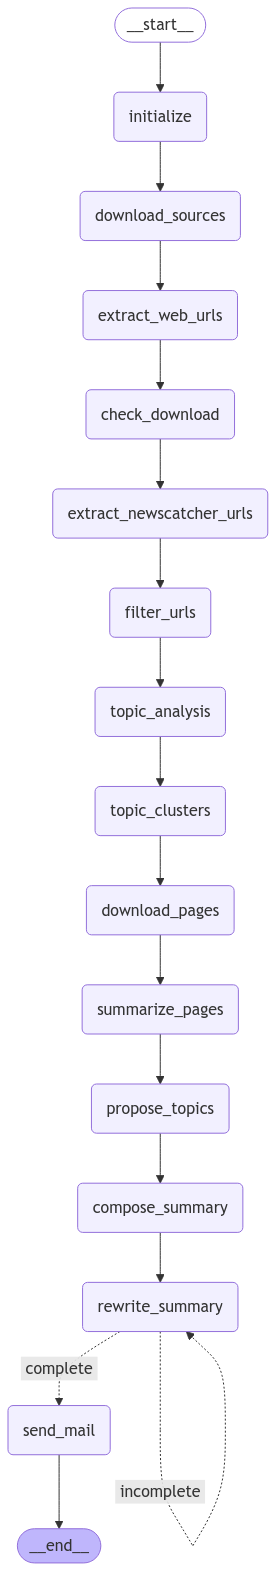

2024-11-25 11:11:29,816 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2024-11-25 11:11:29,817 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-11-25 11:11:29,817 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-11-25 11:11:29,817 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-11-25 11:11:29,818 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-11-25 11:11:29,818 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-11-25 11:11:29,819 - AInewsbot - INFO - 

17


0

In [16]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

do_download = False
before_date = ''
before_date = "2024-11-24 16:00:00"

state, lg_agent, thread_id = initialize_agent(do_download, before_date)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))
state = lg_agent.initialize(state)
state = lg_agent.download_sources(state)
state = lg_agent.extract_web_urls(state)
state = lg_agent.check_download(state)
state = lg_agent.extract_newscatcher_urls(state)
# s/b 17 check all downloaded, if any got hit by a bot block then download manually
sources_downloaded = len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
print(sources_downloaded)
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]

sources_downloaded = len(
    pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 17
missing_sources = SOURCES_EXPECTED-sources_downloaded
missing_sources


In [17]:
# download and extract, human in the loop checks all sources downloaded OK
if missing_sources:
    print(f"missing {missing_sources} sources")
else:
    state = lg_agent.filter_urls(state)
    display(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']])

    # do topic analysis, identify good topics
    state = lg_agent.topic_analysis(state)
    state = lg_agent.topic_clusters(state)

    # download and summarize pagesdd
    state = lg_agent.download_pages(state)

    state = lg_agent.summarize_pages(state)
    # free-form extract topics from summarize, combine with clusters, propose clean topics
    state = lg_agent.propose_topics(state)
    print(state["topics_str"])



2024-11-25 11:11:40,657 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2024-11-24 16:00:00'
2024-11-25 11:11:41,435 - AInewsbot - INFO - URLs in orig_df: 1089
2024-11-25 11:11:41,438 - AInewsbot - INFO - Existing URLs in DB: 185458
2024-11-25 11:11:41,480 - AInewsbot - INFO - New URLs in df filtered by URL: 429
2024-11-25 11:11:41,597 - AInewsbot - INFO - Existing src+title: 32
2024-11-25 11:11:41,597 - AInewsbot - INFO - New URLs in df filtered by src+title: 397
2024-11-25 11:11:41,609 - AInewsbot - INFO - Found 386 unique new headlines
2024-11-25 11:11:41,617 - AInewsbot - INFO - Applying prompt to 8 pages using gpt-4o-mini
2024-11-25 11:11:41,617 - AInewsbot - INFO - sent 50 items 
2024-11-25 11:11:41,618 - AInewsbot - INFO - sent 50 items 
2024-11-25 11:11:41,618 - AInewsbot - INFO - sent 50 items 
2024-11-25 11:11:41,618 - AInewsbot - INFO - sent 50 items 
2024-11-25 11:11:41,619 - AInewsbot - INFO - sent 50 items 
2024-11-25 11:11:41,619 - AInewsbot - 

id
src                 
Bloomberg Tech     1
Business Insider   3
Feedly AI         24
Hacker News        1
Hacker News 2      2
HackerNoon        10
NYT Tech           1
Newscatcher       49
Reddit            12
Techmeme           4
The Register       3
The Verge          1
VentureBeat        2

2024-11-25 11:11:45,847 - AInewsbot - INFO - start free-form topic extraction
2024-11-25 11:11:45,848 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-11-25 11:11:45,848 - AInewsbot - INFO - sent 50 items 
2024-11-25 11:11:45,849 - AInewsbot - INFO - sent 50 items 
2024-11-25 11:11:45,849 - AInewsbot - INFO - sent 13 items 
2024-11-25 11:11:48,431 - AInewsbot - INFO - got dict with 13 items 
2024-11-25 11:11:52,848 - AInewsbot - INFO - got dict with 50 items 
2024-11-25 11:11:55,647 - AInewsbot - INFO - got dict with 50 items 
2024-11-25 11:11:55,649 - AInewsbot - INFO - Processed 113 responses.
2024-11-25 11:11:55,651 - AInewsbot - INFO - 113 free-form topics extracted
2024-11-25 11:11:55,653 - AInewsbot - INFO - ['investment', 'amazon', 'nvidia', 'data centers', 'generative ai', 'llms', 'apple', 'china', 'hollywood', 'arms race', 'russia', 'partnership', 'chatgpt', 'gemini', 'ai models', 'google', 'crowdstrike', 'cybersecurity', 'price target', 'education', 'wor

id  \
0   0   
1   1   
2   2   
3   3   

                                                                                                                                                                                                                                                                                                   title_topic_str  
0  The Big TakeAmazons Moonshot Plan to Rival Nvidia in AI ChipsThe cloud computing giant wont dislodge the incumbent anytime soon but is hoping to reduce its reliance on the chipmaker. (Topics: AI Chips, Amazon, Cloud Computing, Economics, Finance, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips)  
1                                                                                                                           Amazon's AI Chip Strategy Targets Nvidia's Dominance In Data Centers (Topics: Amazon, Chip Strategy, Data Centers, Economics, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips)  
2                                                                                                                                                Inside Amazons plan to compete with Nvidias AI chips. (Topics: AI Chips, Amazon, Competition, Economics, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips)  
3                                                                                                                                DigitalOcean (DOCN) Unveils Bare Metal GPUs: A Boost for AI and ML Workloads (Topics: Bare Metal Gpus, Digitalocean, Economics, Gen AI, Hardware, Ml Workloads, Products, Stocks)

2024-11-25 11:24:08,487 - AInewsbot - INFO - {'topic_title': "Amazon's AI Chip Competition"}
2024-11-25 11:24:08,488 - AInewsbot - INFO - I dub this cluster: Amazon's AI Chip Competition


id  \
4   4   
5   5   
6   6   
7   7   

                                                                                                                                                                                                                                                                                                                               title_topic_str  
4                                                                                                           ChatGPT took over stack overflow!, a website for programming related discussions (Topics: Chatbots, Chatgpt, Code Assistants, Community, Gen AI, Job Automation, Language Models, Programming, Stack Overflow, Virtual Assistants)  
5  ChatGPT Gets Better at Creative Writing With New Update (Topics: Art & Design, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Creative Writing, Entertainment, Gen AI, Language Models, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Update, Virtual Assistants)  
6                                                                                 How are college students using AI tools like ChatGPT? (Topics: AI Tools, Chatbots, Chatgpt, Code Assistants, Cognitive Science, College Students, Education, Gen AI, Language Models, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)  
7                                                                                                                                Does Chatgpt accelerated your learning curve? (Topics: Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Education, Language Models, Learning Curve, Opinion, Review, Virtual Assistants)

2024-11-25 11:24:09,116 - AInewsbot - INFO - {'topic_title': 'ChatGPT and AI in Education'}
2024-11-25 11:24:09,117 - AInewsbot - INFO - I dub this cluster: ChatGPT and AI in Education


id  \
8    8   
9    9   
10  10   

                                                                                                                                                                                                                    title_topic_str  
8   Tens of millions of devices are thrown away each year  and the rise of generative AI will only make this worse (Topics: AI Doom, Climate, Environment, Ethics, Gen AI, Generative AI, Society & Culture, Sustainability, Waste)  
9                                               New AI-Driven Observatory Aims to Revolutionise Energy Poverty Research (Topics: Climate, Economics, Energy, Energy Poverty, Gen AI, Inequality, Research, Science, Sustainability)  
10                                                                   How AI Will Soon Disrupt the Greater Energy Industry (Topics: Climate, Disruption, Economics, Energy, Energy Industry, Gen AI, Job Automation, Sustainability)

2024-11-25 11:24:09,626 - AInewsbot - INFO - {'topic_title': 'AI and Sustainability Challenges'}
2024-11-25 11:24:09,627 - AInewsbot - INFO - I dub this cluster: AI and Sustainability Challenges


id  \
11  11   
12  12   
13  13   
14  14   
15  15   

                                                                                                                                                                                                                            title_topic_str  
11                                                              HyperHuman Tops Image Generation Models in User Study (Topics: AI Models, Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Review, Science, User Study)  
12                                                                                       In-Depth Analysis of Human Image Generation Models (Topics: AI Models, Analysis, Art & Design, Computer Vision, Gen AI, Image Generation, Science)  
13  Two years ago I generated my first AI image of Tom Selleck and Gumby. (Topics: Art & Design, Computer Vision, Entertainment, Gen AI, Gumby, Image Generation, Intellectual Property, Opinion, Science, Tom Selleck, Tv & Film & Movies)  
14                                              Impact of Random Seed and Model Robustness on High-Quality Human Image Generation (Topics: Art & Design, Computer Vision, Gen AI, Image Generation, Model Robustness, Random Seed, Science)  
15                     HyperHuman vs. ControlNet, SDXL, and More: The Ultimate Human Image Generation Showdown (Topics: Art & Design, Comparison, Computer Vision, Controlnet, Gen AI, Hyperhuman, Image Generation, Review, Science, Sdxl)

2024-11-25 11:24:10,164 - AInewsbot - INFO - {'topic_title': 'Human Image Generation Models'}
2024-11-25 11:24:10,165 - AInewsbot - INFO - I dub this cluster: Human Image Generation Models


id  \
16  16   
17  17   
18  18   

                                                                                                                                                                                                                                                                   title_topic_str  
16              POET Technologies Inc. (POET) Gains Momentum with AI-Driven Optoelectronic Innovations and Upgraded Price Target (Topics: Economics, Finance, Funding, Gen AI, Hardware, Innovation, Manufacturing, Optoelectronics, Poet Technologies, Products, Science, Stocks)  
17  Shares of Japan's Fujikura, which specializes in fiber optic cables for data centers, are up 400%+ in 2024 due to the AI boom, leading the Nikkei 225 index (Topics: AI Boom, Data Centers, Economics, Fiber Optic Cables, Finance, Fujikura, Gen AI, Hardware, Japan, Stocks)  
18                                      CrowdStrike Holdings, Inc. (CRWD) AI-Driven Cybersecurity: Analyst Predicts Strong Q3 Results (Topics: Crowdstrike, Cybersecurity, Economics, Finance, Gen AI, Privacy & Surveillance, Products, Q3 Results, Safety And Alignment, Stocks)

2024-11-25 11:24:10,886 - AInewsbot - INFO - {'topic_title': 'AI Innovations in Technology and Finance'}
2024-11-25 11:24:10,887 - AInewsbot - INFO - I dub this cluster: AI Innovations in Technology and Finance
2024-11-25 11:24:10,892 - AInewsbot - INFO - ["Amazon's AI Chip Competition", 'ChatGPT and AI in Education', 'AI and Sustainability Challenges', 'Human Image Generation Models', 'AI Innovations in Technology and Finance']
2024-11-25 11:24:10,920 - AInewsbot - INFO - Queuing URLs for scraping
2024-11-25 11:24:10,925 - AInewsbot - INFO - fetching 113 pages using 4 browsers
2024-11-25 11:24:10,926 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 14919
2024-11-25 11:24:10,926 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 14919
2024-11-25 11:24:10,927 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 14919
2024-11-25 11:24:10,927 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 14919
2024-11-25 11:24:28,612 - AInewsbot - INFO - ge

[1. The Big TakeAmazons Moonshot Plan to Rival Nvidia in AI ChipsThe cloud computing giant wont dislodge the incumbent anytime soon but is hoping to reduce its reliance on the chipmaker. - Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips)  

 Amazon's AI Chip Competition, AI Chips, Amazon, Cloud Computing, Economics, Finance, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips  

- Amazon is developing its own AI chips, Trainium2, in an effort to compete with Nvidia, aiming to reduce reliance on the latter's hardware amid strong demand for AI technologies.
- The company has built a capable in-house chip design team and has started shipping Trainium2 chips to data centers, which are expected to enhance AI performance while also being more cost-effective.
- Despite these advancements, experts indicate that Amazon still faces significant challenges in matching Nvidia's comprehensive suite of software tools and easy integration for customers. 



[2. Amazon's AI Chip Strategy Targets Nvidia's Dominance In Data Centers - Benzinga](https://www.benzinga.com/24/11/42158933/amazons-ai-chip-strategy-targets-nvidias-dominance-in-data-centers)  

 Amazon's AI Chip Competition, Amazon, Chip Strategy, Data Centers, Economics, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips  

- Amazon is intensifying its efforts to compete with Nvidia in the AI chip market, launching the Trainium 2 chip, which offers significant performance improvements over its predecessor.
- The Trainium 2 chip is designed to reduce reliance on external suppliers and will be utilized by startups like Anthropic, particularly following Amazon's increased funding to support AI advancements.
- Amazon's partnerships, including a five-year agreement with Databricks, aim to provide cost-efficient AI solutions, although the company faces challenges in software development compared to Nvidia's established offerings. 



[3. Inside Amazons plan to compete with Nvidias AI chips. - The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)  

 Amazon's AI Chip Competition, AI Chips, Amazon, Competition, Economics, Gen AI, Hardware, Nvidia, Products, Semiconductor Chips  

- Amazon has formed an \\$8 billion partnership with Anthropic to enhance its Trainium hardware and software tools, aiming to compete with Nvidia in the AI chip market.
- The initiative is critical for Amazon's success in the \\$100-billion-plus AI chip market, particularly with the upcoming release of Trainium2, their third generation AI chip.
- The outcome of this effort could determine Amazon's future in AI chip sales, marking a pivotal moment for the company. 



[4. DigitalOcean (DOCN) Unveils Bare Metal GPUs: A Boost for AI and ML Workloads - Yahoo Finance](https://finance.yahoo.com/news/digitalocean-docn-unveils-bare-metal-194102455.html)  

 Amazon's AI Chip Competition, Bare Metal Gpus, Digitalocean, Economics, Gen AI, Hardware, Ml Workloads, Products, Stocks  

- DigitalOcean has launched bare metal GPUs aimed at enhancing AI and machine learning workloads.
- OpenAI is reportedly exploring the development of a web browser to compete with Google, alongside funding research into algorithms for predicting human moral judgments.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion to bolster their collaborative efforts in AI technologies. 



[5. ChatGPT took over stack overflow!, a website for programming related discussions - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)  

 ChatGPT and AI in Education, Chatbots, Chatgpt, Code Assistants, Community, Gen AI, Job Automation, Language Models, Programming, Stack Overflow, Virtual Assistants  

- Users are discussing a perceived decline in the usefulness of Stack Overflow as more people rely on ChatGPT for programming queries.
- There is frustration with Stack Overflow's tendency to close questions as duplicates, even if they are outdated or no longer relevant.
- Some users express that they rarely visit Stack Overflow and prefer using ChatGPT for coding assistance. 



[6. ChatGPT Gets Better at Creative Writing With New Update - www.gadgets360.com](https://www.gadgets360.com/ai/news/openai-gpt-4o-creative-writing-ability-improvement-new-method-automated-red-teaming-7100248)  

 ChatGPT and AI in Education, Art & Design, Authors & Writing, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Creative Writing, Entertainment, Gen AI, Language Models, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Update, Virtual Assistants  

- OpenAI has released an update for its GPT-4o model to enhance creative writing capabilities, aiming for more natural and engaging responses with improved readability.
- The update also boosts file processing abilities, enabling more thorough responses, and is available to ChatGPT Plus subscribers as well as developers via API.
- OpenAI introduced a new automated method for red teaming, intending to use AI models for large-scale testing of vulnerabilities and risks in AI systems, although this method is not yet in use due to existing limitations. 



[7. How are college students using AI tools like ChatGPT? - EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210)  

 ChatGPT and AI in Education, AI Tools, Chatbots, Chatgpt, Code Assistants, Cognitive Science, College Students, Education, Gen AI, Language Models, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants  

- A 2023 survey found that 56% of college students have used AI tools like ChatGPT for assignments or exams, reflecting varying opinions on their impact on education.
- While some students appreciate AI for enhancing learning, others express concerns over academic integrity and its potential negative effects on creative and critical thinking skills.
- Responses from students reveal a mix of acceptance and caution regarding AI use, with many seeking clarity on guidelines from professors about its appropriate application in academic work. 



[8. Does Chatgpt accelerated your learning curve? - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)  

 ChatGPT and AI in Education, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Consciousness, Education, Language Models, Learning Curve, Opinion, Review, Virtual Assistants  

- Users report significant improvements in their learning speed and understanding of complex topics by utilizing ChatGPT, particularly in fields like engineering and language acquisition.
- ChatGPT is praised for its ability to simplify concepts and provide practical solutions to programming challenges, enhancing critical thinking skills.
- Many users highlight the frustration with traditional educational materials and appreciate ChatGPT's capability to make learning more accessible and tailored to their needs. 



[9. Tens of millions of devices are thrown away each year  and the rise of generative AI will only make this worse - Reddit](https://www.reddit.com/r/technews/comments/1gz6lpf/tens_of_millions_of_devices_are_thrown_away_each/)  

 AI and Sustainability Challenges, AI Doom, Climate, Environment, Ethics, Gen AI, Generative AI, Society & Culture, Sustainability, Waste  

- The article discusses concerns about the increasing amount of electronic waste as generative AI becomes more prevalent, suggesting it may encourage consumers to upgrade devices more frequently.
- Critics argue that the logic linking generative AI to a rising trend of discarded devices lacks substantiation and overlooks existing consumer behavior regarding upgrades.
- The conversation highlights the need for improved e-waste management rather than merely focusing on the implications of generative AI in the tech market. 



[10. New AI-Driven Observatory Aims to Revolutionise Energy Poverty Research - irishtechnews.ie](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/)  

 AI and Sustainability Challenges, Climate, Economics, Energy, Energy Poverty, Gen AI, Inequality, Research, Science, Sustainability  

- Researchers at the International Energy Research Centre (IERC) are developing the Irish Energy Poverty Observatory (IREPO) to enhance understanding of the complex factors impacting energy poverty using AI and machine learning.  
- The observatory will integrate data from various sources to provide insights that can assist policymakers in creating effective strategies to address energy poverty.  
- The project, funded by the Sustainable Energy Authority of Ireland (SEAI), involves collaboration with partners from academia and NGOs to leverage best practices in energy poverty research.   



[11. How AI Will Soon Disrupt the Greater Energy Industry - ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)  

 AI and Sustainability Challenges, Climate, Disruption, Economics, Energy, Energy Industry, Gen AI, Job Automation, Sustainability  

- AI is projected to increase energy demand from data centers by 160%, potentially accounting for one quarter of US power consumption by 2030, necessitating innovations in energy production and technology.
- AI can expedite the development of emissions-reducing technologies and improve scaling processes in the energy industry, addressing up to 65% of emissions and significantly reducing capital expenditures.
- The integration of AI is expected to enhance productivity within the energy sector, particularly in project management and facility scaling, potentially mitigating labor productivity issues and construction backlogs. 



[12. HyperHuman Tops Image Generation Models in User Study - Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study)  

 Human Image Generation Models, AI Models, Art & Design, Computer Vision, Gen AI, Hyperhuman, Image Generation, Review, Science, User Study  

- HyperHuman has been found to outperform other text-to-image models in terms of image quality, realism, aesthetics, and text-image alignment in a user study involving 25 participants who evaluated 8,236 images.
- The study utilized a blind side-by-side comparison method to ensure unbiased results, with trained labelers assessing which generated images were superior based on given prompts.
- Detailed statistics from the user study indicate that HyperHuman consistently received higher ratings compared to baseline models. 



[13. In-Depth Analysis of Human Image Generation Models - Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models)  

 Human Image Generation Models, AI Models, Analysis, Art & Design, Computer Vision, Gen AI, Image Generation, Science  

- The analysis focuses on HyperHuman’s performance in human image generation, highlighting metrics such as FID-CLIP curves and human preference scores, which show its competitive edge over other models.
- It reveals that while conventional image quality metrics often diverge from human preferences, HyperHuman performs better than baselines with improved quantitative and qualitative results.
- The study reports pose accuracy results across various CFG scales, demonstrating consistent superior performance in pose accuracy and controllability compared to other conditional human generation methods. 



[14. Two years ago I generated my first AI image of Tom Selleck and Gumby. - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzc87g/two_years_ago_i_generated_my_first_ai_image_of/)  

 Human Image Generation Models, Art & Design, Computer Vision, Entertainment, Gen AI, Gumby, Image Generation, Intellectual Property, Opinion, Science, Tom Selleck, Tv & Film & Movies  

- Users reflect on the progress of AI image generation over the past two years, reminiscing about early models like DALL-E Mini.
- Contributors share their first AI-generated images and experiences, noting the significant improvements in quality.
- There is a sense of nostalgia for the earlier, often humorous AI outputs, contrasted with the advancements in technology. 



[15. Impact of Random Seed and Model Robustness on High-Quality Human Image Generation - Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation)  

 Human Image Generation Models, Art & Design, Computer Vision, Gen AI, Image Generation, Model Robustness, Random Seed, Science  

- The study demonstrates that the HyperHuman model maintains high-quality and aligned human image generation despite variations in random seed inputs, indicating strong model robustness.
- Realistic human image generation has beneficial applications in creative fields like art and design, but poses risks for misuse in areas like deepfakes and forgery.
- The authors advocate for the labeling of generated images as “synthetic” to mitigate potential negative societal impacts. 



[16. HyperHuman vs. ControlNet, SDXL, and More: The Ultimate Human Image Generation Showdown - Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)  

 Human Image Generation Models, Art & Design, Comparison, Computer Vision, Controlnet, Gen AI, Hyperhuman, Image Generation, Review, Science, Sdxl  

- HyperHuman demonstrates superior performance in generating realistic, text-aligned human images compared to other models like ControlNet and SDXL.
- The framework successfully synthesizes high-resolution images of humans across various age groups and environments.
- Results are supported by quantitative and qualitative comparisons among recent text-to-image generation models. 



[17. POET Technologies Inc. (POET) Gains Momentum with AI-Driven Optoelectronic Innovations and Upgraded Price Target - Yahoo Finance](https://finance.yahoo.com/news/poet-technologies-inc-poet-gains-102506479.html)  

 AI Innovations in Technology and Finance, Economics, Finance, Funding, Gen AI, Hardware, Innovation, Manufacturing, Optoelectronics, Poet Technologies, Products, Science, Stocks  

- POET Technologies Inc. is gaining attention as the rise of artificial intelligence drives investment strategies toward hardware, contrasting with previous software-focused tech booms.
- A report forecasts that major tech firms will spend over \\$200 billion on AI infrastructure by 2025, with risks including longer timelines for profitability and potential funding challenges for AI startups.
- Craig-Hallum recently raised POET's price target from \\$3.50 to \\$5.50 while maintaining a Buy rating, highlighting its advancements in optoelectronic solutions for AI data centers through partnerships, particularly with Mitsubishi. 



[18. Shares of Japan's Fujikura, which specializes in fiber optic cables for data centers, are up 400%+ in 2024 due to the AI boom, leading the Nikkei 225 index - Bloomberg](https://www.bloomberg.com/news/articles/2024-11-24/ai-boom-makes-139-year-old-cable-maker-japan-s-hottest-stock)  

 AI Innovations in Technology and Finance, AI Boom, Data Centers, Economics, Fiber Optic Cables, Finance, Fujikura, Gen AI, Hardware, Japan, Stocks  

- Fujikura Ltd., a 139-year-old cable company, has seen its stock surge over 400% this year, making it the best performer on the Nikkei 225 index.
- The company's success is attributed to the growing demand for wire cabling for data centers driven by the AI boom.
- Fujikura will be added to the MSCI global indexes on November 25, 2023, as the only new addition from Japan. 



[19. CrowdStrike Holdings, Inc. (CRWD) AI-Driven Cybersecurity: Analyst Predicts Strong Q3 Results - Yahoo Finance](https://uk.finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-ai-011205536.html)  

 AI Innovations in Technology and Finance, Crowdstrike, Cybersecurity, Economics, Finance, Gen AI, Privacy & Surveillance, Products, Q3 Results, Safety And Alignment, Stocks  

- CrowdStrike Holdings, Inc. (NASDAQ:CRWD) is expected to report strong Q3 results, with JPMorgan raising its price target on the stock from \\$330 to \\$369 and maintaining an Overweight rating.
- The surge in entrepreneurship in the U.S. post-pandemic is leading to increased demand for AI-driven solutions, as exemplified by startup Fondo's success in providing subscription-based bookkeeping services.
- A report indicates that nearly 75% of accountants may retire within the next decade, impacting the availability of traditional accounting services for the growing number of new businesses. 



[20. Snowflake and Anthropic Partner to Bring Claude Models to AI Data Cloud - telecomtalk.info](https://telecomtalk.info/snowflake-anthropic-bring-claude-models-ai-cloud/985325)  

 Anthropic, Claude Models, Data Cloud, Gen AI, Language Models, Products, Science, Snowflake  

- Snowflake has partnered with Anthropic to integrate Claude 3.5 into its Cortex AI platform, enhancing AI capabilities for enterprise applications with a focus on security and scalability.
- The collaboration aims to help businesses build advanced generative AI applications and tools by streamlining access to Claude's capabilities while ensuring compliance with data governance standards.
- Snowflake plans to use Claude in its internal operations and has committed to optimizing its AI products for this model, reducing time-to-market for enterprises adopting AI technologies. 



[21. Senators say TSA's facial recognition program is out of control - Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310)  

 AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Disinformation, Ethics, Facial Recognition, Governance, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Transportation, Tsa  

- A bipartisan group of 12 senators has requested an investigation into the TSA's facial recognition program, raising concerns about its impact on privacy and civil liberties as it may soon become a mandatory process at numerous airports.
- The TSA plans to expand the program to over 430 airports, with senators highlighting the confusing opt-out procedures and reports of challenging interactions faced by travelers wanting to decline facial scans.
- The senators argue that the TSA has not provided evidence of the program's effectiveness in combating identity fraud, noting a significant false negative rate associated with the facial recognition technology. 



[22. UK spies to counter Russian cyber warfare threat with new AI security lab - Yahoo News UK](https://uk.news.yahoo.com/uk-spies-counter-russian-cyber-000125842.html)  

 Cyber Warfare, Cybersecurity, Gen AI, Governance, Hardware, Intelligence, Military, Policy And Regulation, Politics, Privacy & Surveillance, Russia, Safety And Alignment, Science, Security Lab, Uk  

- The UK will establish a new Laboratory for AI Security Research (LAISR) to counter Russian cyber warfare, backed by £8.22 million in state funding.
- Chancellor Pat McFadden emphasized that the UK and NATO are actively monitoring and combatting Russian cyber attacks, asserting that Putin's threats will not deter support for Ukraine.
- The initiative includes a £1 million incident response scheme and highlights the increasing need for robust cyber defenses amid escalating tensions between Russia and the West. 



[23. Ben Affleck Says AI Will Disrupt Hollywood but Not Humans Making Films - CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)  

 Ben Affleck, Deepfakes, Entertainment, Film Industry, Gen AI, Hollywood, Job Automation, Opinion, Society & Culture, Streaming, Tv & Film & Movies  

- Ben Affleck stated that while AI will disrupt Hollywood, it will not replace human filmmakers, arguing that the creative essence of filmmaking is beyond AI's current capabilities. 
- He believes AI can streamline labor-intensive tasks in filmmaking, potentially lowering costs and making filmmaking more accessible to diverse voices.
- Affleck emphasized the distinction between craftsmanship and artistry, suggesting that AI, as a craftsman, cannot replicate the nuanced taste and decision-making inherent to artistic creation. 



[24. Most Gen Zers are terrified of AI taking their jobs. Their bosses consider themselves immune - Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)  

 AI Doom, Bias And Fairness, Economics, Ethics, Gen AI, Gen Z, Inequality, Job Automation, Job Security, Jobs & Careerslabor Market, Opinion, Safety And Alignment, Society & Culture, Workplace  

- Most Gen Z individuals are concerned about AI replacing their jobs.
- In contrast, many employers believe they are not at risk of job loss due to AI advancements. 



[25. everyone: AI is going to take over the world!  AI: - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gz888w/everyone_ai_is_going_to_take_over_the_world_ai/)  

 AI Doom, Gen AI, Opinion, Public Perception, World Domination  

- The text is primarily a discussion forum for ChatGPT and AI, specifically on Reddit.
- There are automated messages about setting up account features and user guidelines.
- The content does not contain substantive news information. 



[26. Will The AI Boom Hurt Creativity? Not If Humans Lead The Way - Forbes](https://www.forbes.com/sites/nelsongranados/2024/11/25/will-the-ai-boom-hurt-creativity-not-if-humans-lead-the-way/)  

 Art & Design, Cognitive Science, Consciousness, Creativity, Entertainment, Ethics, Gen AI, Human Leadership, Impact, Intellectual Property, Opinion, Science, Society & Culture  

- The increasing use of generative AI tools poses a dual threat to creativity, potentially stifling unique ideas, particularly in fields like advertising, film, and music.
- A recent study reveals that while large language models can enhance the quality of ad copy when used as a sounding board, relying on them as ghostwriters may lead to less creative outcomes.
- It is crucial for creatives to harness AI as a supportive tool after generating initial ideas, rather than allowing it to dominate the creative process. 



[27. Goldman Sachs: Advanced Micro Devices, Inc. (NASDAQ:AMD) Is A Top AI Growth Investor Stock - Yahoo Finance](https://finance.yahoo.com/news/goldman-sachs-advanced-micro-devices-131333819.html)  

 Amd, Economics, Finance, Gen AI, Goldman Sachs, Hardware, Investment, Semiconductor Chips, Stocks  

- Goldman Sachs identifies Advanced Micro Devices, Inc. (NASDAQ:AMD) as a top AI growth investor stock, ranking it 22nd among the top growth investment stocks due to its capabilities in both CPUs and GPUs for AI computing.
- The report predicts that the equal-weighted S&P index will likely outperform the market cap-weighted index by 200 to 800 basis points over the next decade, driven by market dynamics similar to those observed during the dot-com bubble.
- AMD's recent financial struggles include a significant drop in gaming revenue and layoffs, highlighting challenges in competing with larger rivals, yet it is poised for growth through increased adoption of its AI products by customers like Microsoft and Meta. 



[28. AI-powered tool may offer contactless way to detect high blood pressure, diabetes - Miami Herald](https://www.miamiherald.com/living/article296105924.html)  

 Blood Pressure, Contactless Detection, Diabetes, Health & Fitness, Healthcare, Products, Safety And Alignment, Science, Testing  

- An AI-powered tool using high-speed video can detect high blood pressure and diabetes non-invasively, potentially allowing for at-home monitoring without traditional tests.
- In a study, the system demonstrated 94% accuracy in detecting stage 1 hypertension and 75% accuracy for diabetes diagnoses when compared to standard tests.
- The technology remains in early development stages, requiring further testing on diverse populations and different environments. 



[29. Smile! UK cops spend tens of millions on live facial recognition techLabour government keen, though critics paint it as a severe threat to privacySoftware5 hrs|27 - The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)  

 AI Doom, Bias And Fairness, Computer Vision, Cybersecurity, Disinformation, Ethics, Facial Recognition, Governance, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Transportation, Uk  

- The UK government is launching a £20 million competition for tech companies to provide live facial recognition (LFR) technology to various police forces, marking a significant step in its implementation.
- The LFR system will compare live camera feeds against predetermined watchlists to identify persons of interest, despite ongoing privacy concerns and criticism regarding its implications for civil liberties.
- The Labour government, with support from Prime Minister Keir Starmer, is focused on rolling out this technology to deter crime, despite warnings from privacy advocates about its potential for misuse and inherent biases. 



[30. Travis Kalanick, Marc Andreessen, and other Silicon Valley leaders are reportedly getting involved with Elon Musk's DOGE - Business Insider](https://www.businessinsider.com/doge-silicon-valley-leaders-trump-musk-marc-andreessen-travis-kalanick-2024-11)  

 Cryptocurrency, Doge, Economics, Elon Musk, Finance, Marc Andreessen, Silicon Valley, Stocks, Travis Kalanick, Venture Capital  

- Elon Musk and Vivek Ramaswamy are forming the Department of Government Efficiency (DOGE) with involvement from several prominent Silicon Valley leaders, including Joe Lonsdale and Marc Andreessen.
- DOGE aims to cut \\$2 trillion from the federal budget and is seeking individuals committed to extensive work on cost-cutting measures.
- The department will function as an advisory group and intends to increase transparency regarding government spending, with plans to publicly display examples of inefficient expenditure. 



[31. Stanford Professor Allegedly Submits Fake AI Citations in Argument On Deepfake Harms - Yahoo](https://www.yahoo.com/tech/stanford-professor-allegedly-submits-fake-141816525.html)  

 AI Citations, AI Doom, Bias And Fairness, Cognitive Science, Computer Vision, Deepfake, Deepfakes, Disinformation, Ethics, Gen AI, Intellectual Property, Legal Issues, Opinion, Safety And Alignment, Scams, Science, Society & Culture, Stanford Professor  

- Stanford Professor Jeff Hancock is accused of including fake AI-generated citations in his legal filing supporting a Minnesota deepfake bill, raising concerns about the reliability of the argument.
- The proposed Minnesota law aims to enforce restrictions on the use of deepfakes during elections, but the validity of Hancock's document has been questioned due to untraceable citations.
- Critics of the bill highlight these "AI hallucinations" as a reason to doubt the credibility of the legal argument, with no response from Professor Hancock yet on the allegations. 



[32. A new culture war is brewing  and Coca-Cola's AI Christmas ad is at the center - Yahoo](https://www.yahoo.com/entertainment/culture-war-brewing-coca-colas-173203334.html)  

 Advertising, Bias And Fairness, Coca-Cola, Culture War, Entertainment, Gen AI, Opinion, Products, Society & Culture, Tv & Film & Movies  

- Coca-Cola's Christmas commercial, created using generative AI, has sparked controversy, highlighting tensions in the creative industry over the role of AI in artistry.
- Critics, including well-known creators, have labeled the ad as a dystopian shift away from human artistry, while supporters argue AI can expedite and enhance the creative process.
- The ad symbolizes a broader cultural battle regarding AI's impact on creative work and traditional methods, provoking divergent reactions from both artists and consumers. 



[33. Luma expands Dream Machine AI video model into full creative platform, mobile app - VentureBeat](https://venturebeat.com/ai/luma-expands-dream-machine-ai-video-model-into-full-creative-platform-mobile-app/)  

 AI Video Model, Art & Design, Creative Platform, Dream Machine, Gen AI, Hardware, Luma AI, Products, Science  

- Luma AI has expanded its Dream Machine AI video model into a comprehensive platform and mobile app, now available on web and iOS, allowing for intuitive, conversational interaction in visual creation.
- The new image generation model, Luma Photon, enhances personalization and efficiency, enabling users to generate high-quality images and videos, including consistent characters for storytelling from a single image.
- Dream Machine is transitioning to a subscription-based service with tiered pricing, aimed at casual creators and professionals in various industries, while Luma AI has secured \\$80M in funding to further its mission of democratizing creativity. 



[34. HyperHuman Ablation Study: Optimal Expert Branch Design for Improved Image Generation - Hacker Noon](https://hackernoon.com/hyperhuman-ablation-study-optimal-expert-branch-design-for-improved-image-generation)  

 Ablation Study, Art & Design, Computer Vision, Expert Branch Design, Gen AI, Hyperhuman, Image Generation, Science  

- The HyperHuman ablation study investigates various configurations of expert branches in latent structural diffusion models to enhance image generation. 
- Results indicate that a balanced number of replicated layers improves joint learning of image appearance, spatial relationships, and geometry, while too few or too many layers can hinder performance. 
- The paper emphasizes the importance of optimizing expert branches for effective feature fusion across different targets. 



[35. Palantir Stock Can Get Another AI Boost, Analyst Says. These Stocks Can Surge, Too. - MSN](https://www.msn.com/en-us/money/savingandinvesting/palantir-stock-can-get-another-ai-boost-analyst-says-these-stocks-can-surge-too/ar-AA1uHR2L)  

 Economics, Finance, Funding, Gen AI, Investment, Palantir, Products, Stock Market, Stocks  

- The document does not contain any substantive news content. 



[36. Palladyne AI (PDYN) Expands Teal Drones Partnership: A Game-Changer for Defense and Public Safety? - Yahoo Finance](https://finance.yahoo.com/news/palladyne-ai-pdyn-expands-teal-193500369.html)  

 Deals, Defense, Drones, Gen AI, Military, Palladyne AI, Products, Public Safety, Safety And Alignment  

- Palladyne AI Corp. (PDYN) has expanded its partnership with Teal Drones, potentially impacting defense and public safety sectors.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, including a grant to Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, enhancing their ongoing collaboration in the AI space. 



[37. From Porto Business School, Ethical Leadership In The Age Of AI - Yahoo Finance](https://finance.yahoo.com/news/porto-business-school-ethical-leadership-171703830.html)  

 Bias And Fairness, Business Education, Education, Ethical Leadership, Ethics, Gen AI, Governance, Inequality, Opinion, Safety And Alignment, Society & Culture  

- Jose Esteves, dean of Porto Business School, emphasizes the necessity of integrating digital skills and ethical leadership into MBA programs to prepare students for the AI Revolution.
- The school prioritizes teaching students how to navigate digital transformation rather than just using AI as a tool, with a core course titled “AI For Business.”
- There is a growing need for soft skills in business education, as technical skills may quickly become outdated in the evolving business landscape influenced by AI. 



[38. Former BP Chief Joins A.I. Data Center Developer - The New York Times](https://www.nytimes.com/2024/11/24/business/ai-data-center-bernard-looney.html)  

 Bp, Data Center, Energy, Gen AI, Infrastructure, Leadership  

- Bernard Looney, former CEO of BP, will serve as chairman of Prometheus Hyperscale, a start-up focused on data centers to support the energy needs of the AI industry.
- Prometheus Hyperscale plans to construct a \\$10 billion data center on a 640-acre site in Evanston, Wyoming, aiming to attract major tech companies with high electricity demands.
- Looney intends to assist the company with customer relations, investor engagement, and overall strategy as it seeks to expand domestically and internationally. 



[39. Does using AI to talk to your employees work? - San Diego Union Tribune](https://www.sandiegouniontribune.com/2024/11/25/does-using-ai-to-talk-to-your-employees-work/)  

 Customer Service, Employee Communication, Job Automation, Jobs & Careerslabor Market, Opinion, Review, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants, Workplace  

- Research by Harvard professor Prithwiraj Choudhury shows that employees experience "algorithm aversion," feeling less engaged with AI-generated communications from their CEOs compared to authentic messages.
- In a study, only 50% of participants could identify whether a message was from their CEO or an AI bot, and discovering the truth led to feelings of betrayal and decreased trust in future communications.
- Choudhury emphasizes that overcoming this aversion is crucial for the AI industry, as employee satisfaction and trust hinge on the authenticity of communication. 



[40. How to redesign work for the age of AI - MIT Sloan School of Management](https://mitsloan.mit.edu/ideas-made-to-matter/how-to-redesign-work-age-ai)  

 Automation, Future Of Work, Gen AI, Job Automation, Jobs & Careerslabor Market, Society & Culture, Work Redesign  

- Leaders from Google, ING, and Capital One emphasize a measured approach to artificial intelligence implementation, advising against a "gold rush mentality" and promoting thoughtful redesign of work processes.
- Key strategies include modernizing data infrastructure, upskilling employees, embracing partnerships, maintaining human oversight in AI use, and focusing on iterative testing and learning.
- Companies should prioritize risk management, particularly concerning data privacy and ethical implications, while being mindful of the balance between innovation and organizational readiness. 



[41. Adtran and Dell Partner to Launch Scalable AI Network Solutions for US Federal Agencies - telecomtalk.info](https://telecomtalk.info/adtran-dell-scalable-ai-network-solutions-us/985341)  

 Adtran, Dell, Federal Agencies, Gen AI, Governance, Hardware, Infrastructure, Military, Network Solutions, Policy And Regulation, Politics, Products  

- Adtran and Dell Technologies have announced a partnership to provide scalable AI networking solutions for US federal agencies, combining their respective technologies to enhance AI deployments.
- The core of the collaboration is Dell’s AI Network Cloud (AINC) Factory ON-RAMP, which supports AI workloads in various environments while offering cost savings and flexibility for federal agencies.
- The partnership aims to empower federal agencies with secure, high-performance infrastructure to accelerate AI implementations while ensuring compliance with security standards. 



[42. Alphabet Inc. (GOOG) Enhances OSS-Fuzz with AI, Uncovering 26 Open-Source Vulnerabilities - Yahoo Finance](https://finance.yahoo.com/news/alphabet-inc-goog-enhances-oss-104016568.html)  

 Alphabet Inc., Cybersecurity, Gen AI, Intellectual Property, Legal Issues, Open Source, Open-Source Vulnerabilities, Oss-Fuzz, Safety And Alignment, Science, Stocks, Testing  

- Alphabet Inc.'s OSS-Fuzz tool, now enhanced with AI, has uncovered 26 vulnerabilities in open-source projects, including a significant flaw in OpenSSL.
- The rise of AI is shifting capital demands in tech, with predictions of over \\$200 billion in capital expenditures by big tech companies for AI infrastructure by 2025.
- The transition to hardware-intensive AI development poses long-term financial risks, with potential constraints on funding availability for AI startups amid economic downturns. 



[43. Europe Online Fashion (Apparel, Footwear) Market 2024: A \\$198.77 Billion Industry by 2028, Fueled by Multi-Channel Demands Immersion, E-commerce, and Artificial Intelligence Integration - Yahoo Finance](https://finance.yahoo.com/news/europe-online-fashion-apparel-footwear-110900647.html)  

 E-Commerce, Economics, Europe, European Union, Fashion, Fashion Market, Gen AI, Lifestyle & Travel, Products  

- The Europe online fashion market is projected to reach \\$198.77 billion by 2028, growing at a CAGR of 10% from 2024 to 2028, driven by increasing internet users and e-commerce adoption.
- Key trends include personalization, multi-channel demands via social media, and artificial intelligence integration, while challenges encompass customer retention and environmental concerns.
- North and Western Europe currently holds the largest market share, followed by Southern, Central, and Eastern Europe, with Poland leading in Central Europe. 



[44. Weekend Round-Up: AI Dominates Headlines With Nvidia, Elon Musk, And Hollywood's Big Names - Benzinga](https://www.benzinga.com/24/11/42154224/weekend-round-up-ai-dominates-headlines-with-nvidia-elon-musk-and-hollywoods-big-names)  

 Elon Musk, Entertainment, Gen AI, Headlines, Hollywood, Nvidia, Science, Tv & Film & Movies  

- Nvidia reported a 94% YoY increase in Q3 revenue, reaching \\$35.1 billion, exceeding expectations despite supply constraints.
- Elon Musk predicts AI will soon surpass doctors and lawyers in key tasks, following a study indicating a 90% accuracy rate for AI diagnoses compared to human professionals.
- Chinese tech companies are expanding their AI presence in Silicon Valley to attract U.S. talent and enhance their competitive edge in the AI market. 



[45. JobQuest Assistant: How I Built a Smart Companion for Stress-Free Job Hunting With Coze - Hacker Noon](https://hackernoon.com/jobquest-assistant-how-i-built-a-smart-companion-for-stress-free-job-hunting-with-coze)  

 Chatbots, Job Hunting, Jobquest Assistant, Jobs & Careerslabor Market, Products, Society & Culture, Virtual Assistants  

- JobQuest is an AI chatbot developed to streamline the job hunting process, helping users by providing personalized job recommendations, cover letter and resume tips, and interview preparation assistance.
- The chatbot automates repetitive tasks, such as searching job boards and generating application materials, allowing job seekers to focus on critical aspects of their searches.
- Built using the no-code platform Coze, JobQuest was constructed quickly, leveraging natural language processing to offer support without the need for coding skills. 



[46. CrowdStrike Holdings, Inc. (CRWD) Gains Momentum with AI-Powered Cybersecurity and \\$375 Price Target Upgrade - Yahoo Finance](https://finance.yahoo.com/news/crowdstrike-holdings-inc-crwd-gains-103536204.html)  

 Crowdstrike, Cybersecurity, Economics, Finance, Gen AI, Price Target, Privacy & Surveillance, Products, Safety And Alignment, Stocks  

- CrowdStrike Holdings, Inc. (CRWD) is leveraging artificial intelligence to enhance its cybersecurity services and has received a price target upgrade from Baird, raising it to \\$375 from \\$315.
- The growth in AI is reshaping investment strategies in the tech sector, with significant capital expenditures projected to reach over \\$200 billion by 2025, largely focused on AI infrastructure.
- Despite the current momentum, the report highlights potential long-term financial risks associated with capital-intensive AI hardware development, which may be affected by economic downturns and high capital costs. 



[47. Are AI PoCs Worth the Investment or Just Burning Cash? - Analytics India Magazine](https://analyticsindiamag.com/ai-origins-evolution/are-ai-pocs-worth-the-investment-or-just-burning-cash/)  

 Cost Analysis, Economics, Finance, Funding, Investment, Opinion, Proof Of Concepts, Review  

- Industry leaders are divided on the value of AI Proofs of Concept (PoCs), with critics arguing they often lack scalability and measurable outcomes, while proponents see them as vital for validating AI innovations.
- AI expert Vin Vashishta advocates for simpler initiatives over PoCs, suggesting alternatives like vendor demos and educational sessions to achieve AI objectives more effectively and at a lower cost.
- Despite criticisms, some experts defend PoCs, stating they provide essential context-specific validation, uncover challenges, and can act as valuable stepping stones toward successful AI implementation in enterprises. 



[48. AI renders Game of Thrones characters if they were created by Tim Burton - Winter Is Coming](https://winteriscoming.net/ai-renders-game-of-thrones-characters-if-they-were-created-by-tim-burton-01jc9mv0j8be)  

 Art, Art & Design, Entertainment, Game Of Thrones, Gaming, Hollywood, Streaming, Tim Burton, Tv & Film & Movies  

- AI technology has reproduced Game of Thrones characters in the distinctive Tim Burton style, highlighting their elongated features and unique aesthetics.
- The comparison is drawn between AI-generated designs and Andrew Tarusov's illustrations from 2019, noting emotional depth in Tarusov's work that the AI lacks.
- The use of generative AI to place Game of Thrones characters in various scenarios has gained popularity among fans. 



[49. Palantir Price Target Raised To \\$75 By Dan Ives Amid 288% YTD Surge: Analyst Calls 2025 A 'Primetime' Year For AI - Benzinga](https://www.benzinga.com/news/global/24/11/42156160/palantir-price-target-raised-to-75-by-dan-ives-amid-288-ytd-surge-analyst-calls-2025-a-primetime-year-for-ai)  

 Economics, Finance, Funding, Gen AI, Palantir, Price Target, Products, Stock Market, Stocks  

- Dan Ives of Wedbush Securities has raised Palantir's price target to \\$75, reflecting a strong bullish outlook on the AI software sector, which he predicts will see significant growth by 2025.
- Palantir Technologies has experienced a 288% surge in its stock price year-to-date, with its market capitalization exceeding \\$140 billion, propelled by a \\$480 million Pentagon contract and significant commercial earnings.
- Despite the optimistic projections, some investors have expressed concerns over high valuations and market volatility, leading major hedge funds to reduce their holdings in Palantir. 



[50. Elastic Unveils AI Ecosystem to Simplify GenAI Application Development - Analytics India Magazine](https://analyticsindiamag.com/ai-news-updates/elastic-unveils-ai-ecosystem-to-simplify-genai-application-development/)  

 AI Ecosystem, Application Development, Artificial General Intelligence, Code Assistants, Economics, Elastic, Gen AI, Gen AI, Language Models, Products, Retrieval Augmented Generation, Science  

- Elastic has launched an AI ecosystem aimed at accelerating the development of Retrieval Augmented Generation (RAG) applications, integrating with major companies like AWS, Microsoft, and OpenAI.
- The ecosystem provides developers with tools for AI model access, cloud infrastructure, and data preparation, designed to enhance deployment speed, ROI, and innovation.
- Elastic emphasizes partnerships and integration with industry leaders to improve retrieval relevance and AI model accuracy for developers building GenAI applications. 



[51. Salesforce (CRM) Launches Agentforce Testing Center: Revolutionizing AI Agent Management - Yahoo Finance](https://ca.finance.yahoo.com/news/salesforce-crm-launches-agentforce-testing-194852266.html)  

 Agentforce, Chatbots, Code Assistants, Customer Service, Economics, Gen AI, Job Automation, Management, Products, Salesforce, Testing, Virtual Assistants  

- Salesforce has launched the Agentforce Testing Center, enhancing management of AI agents amid the competitive AI landscape.
- OpenAI is exploring the development of a web browser and researching algorithms for predicting human moral judgments, funded through a \\$1 million grant to Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, solidifying their partnership in advancing generative AI technologies. 



[52. Coding Boot Gamp Graduates Find tough Prospects In an AI-Powered World - news.slashdot.org](https://news.slashdot.org/story/24/11/24/2159232/coding-boot-gamp-graduates-find-tough-prospects-in-an-ai-powered-world)  

 Coding Bootcamp, Economics, Education, Employment, Gen AI, Inequality, Job Automation, Job Market, Jobs & Careerslabor Market, Society & Culture  

- Coding boot camp graduates are facing significant challenges in the job market due to high layoffs in the tech industry and the rapid adoption of AI tools like ChatGPT, which are changing job requirements.
- Active job postings for software developers have decreased by 56% compared to five years ago, with entry-level positions dropping by 67%, resulting in the worst environment for junior tech jobs in 25 years.
- Experts predict that while AI may streamline coding, it raises concerns over long-term job security for junior programmers, indicating a potentially grim outlook for coding boot camp graduates. 



[53. Raging AI Debate Delivers Fuel For Direxion's Nvidia-Focused Funds NVDU And NVDD - Benzinga](https://www.benzinga.com/trading-ideas/long-ideas/24/11/42158947/raging-ai-debate-delivers-fuel-for-direxions-nvidia-focused-funds-nvdu-and-nvdd)  

 Direxion, Economics, Finance, Funding, Funds, Gen AI, Nvidia, Opinion, Stocks  

- Nvidia's Q3 financial results exceeded expectations, with earnings per share of 81 cents and sales of \\$35.1 billion, marking a 94% year-over-year increase.
- Despite these strong results, NVDA stock faced skepticism from investors, evidenced by a drop in price and options activity suggesting bearish sentiment.
- Direxion offers two contrasting ETFs (NVDU and NVDD) that reflect divergent investor outlooks on Nvidia's stock, with NVDU showing substantial returns this year, while NVDD has significantly declined. 



[54. Microsoft Copilot Beginner's Guide 2025 - Geeky Gadgets](https://www.geeky-gadgets.com/microsoft-copilot-tutorial-for-beginners/)  

 Code Assistants, Copilot, Education, Gen AI, Guide, Microsoft, Products, Virtual Assistants  

- Microsoft Copilot integrates AI into Microsoft 365 apps, enhancing productivity by providing personalized and context-specific assistance for tasks like drafting emails, analyzing data, and creating presentations.
- There are three licensing tiers: a Free version for basic functionality, a Pro version at \\$20/month for core features, and a Business version at \\$30/user/month, offering advanced tools and enterprise-grade security.
- Copilot prioritizes security and privacy, ensuring user data is protected and not used to train AI models, while effective usage requires clear prompts and human oversight for accuracy. 



[55. Microsoft reboots Windows Recall, but users wish they could forgetAI snapshot tool stumbles back into the spotlight with more issuesAI + ML3 hrs|17 - The Register](https://www.theregister.com/2024/11/25/windows_recall_preview/)  

 Gen AI, Microsoft, Products, Snapshot Tool, Windows Recall  

- Microsoft re-released its Windows Recall application to Windows Insiders, but it continues to face issues, particularly with delayed or missing snapshots.
- The AI tool has been criticized for privacy concerns and its initial rollout, leading Microsoft to withdraw it shortly after the launch and make improvements before the preview re-release.
- Users report mixed performance regarding image content storage and retrieval, with some features like "Click to Do" receiving limited functionality feedback. 



[56. How to We Stop Deepfakes From Tricking Juries? - Gizmodo](https://gizmodo.com/how-to-we-stop-deepfakes-from-tricking-juries-2000521201)  

 Bias And Fairness, Computer Vision, Deepfakes, Disinformation, Ethics, Juries, Legal, Legal Issues, Safety And Alignment, Society & Culture  

- Judges are increasingly concerned about the reliability of AI-generated evidence in court, as deepfakes can easily mislead juries and undermine the validity of both incriminating and exculpatory evidence.
- Legal scholars are proposing changes to evidence rules that would shift the burden of authenticity verification from juries to judges, enhancing the gatekeeping role to determine the admissibility of potentially fabricated evidence.
- The implementation of new rules and technological solutions to detect deepfakes may take years, with current detection tools showing high rates of failure in accurately identifying fake content. 



[57. A tangled web of companies have a stake in the biggest AI companies. Dive in and see - Sherwood News](https://sherwood.news/business/companies-backing-big-ai-startups-openai-anthropic-perplexity/)  

 Companies, Gen AI, Industry Analysis, Investment  

- Amazon has invested an additional \\$4 billion in AI startup Anthropic, bringing its total investment to \\$8 billion, while proposing AWS as the primary cloud provider for the company.
- The coffee market is facing significant supply issues due to low rainfall in Brazil, resulting in skyrocketing prices for arabica beans, which have seen the highest futures prices since May 1997.
- Tesla's Austin plant reportedly failed to resolve environmental issues in its production processes, allowing toxic emissions and hazardous wastewater management problems to persist. 



[58. How Pose, Depth, and Surface-Normal Impact HyperHumans Image Quality - Hacker Noon](https://hackernoon.com/how-pose-depth-and-surface-normal-impact-hyperhumans-image-quality)  

 Art & Design, Computer Vision, Depth, Hyperhuman, Image Quality, Science, Surface-Normal  

- The study discusses the impact of pose, depth, and surface-normal inputs on the image quality generated by HyperHuman's Latent Structural Diffusion Model.
- Experiments reveal that utilizing a combination of these inputs enhances image generation quality, with surface-normal condition proving particularly effective.
- The implementation of a random dropout conditioning scheme is critical for improving robustness and overall image output quality in a two-stage generation pipeline. 



[59. Microsoft Corporation (MSFT) Expands AI-Ready Hybrid Cloud Solutions with Hitachi Vantara Partnership - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-expands-ai-104549782.html)  

 Deals, Economics, Finance, Gen AI, Hardware, Hitachi Vantara, Hybrid Cloud, Japan, Manufacturing, Mergers And Acquisitions, Microsoft, Partnership, Products, Stocks  

- Microsoft has partnered with Hitachi Vantara to develop AI-ready hybrid cloud solutions, enhancing their previous collaboration to leverage Azure for cloud management.
- Industry reports indicate that the rise of AI is shifting investment strategies towards hardware, with projections of over \\$200 billion in capital expenditures from big tech companies by 2025.
- The transition to hardware-focused AI development poses long-term financial risks, including potential funding challenges for startups due to economic downturns or high capital costs. 



[60. Marc Benioff thinks we've reached the 'upper limits' of LLMs  the future, he says, is AI agents - Business Insider](https://www.businessinsider.com/marc-benioff-salesforce-llm-ai-agents-future-podcast-2024-11)  

 AI Agents, Artificial General Intelligence, Future Of AI, Gen AI, Job Automation, Language Models, Llms, Marc Benioff, Opinion, Virtual Assistants  

- Salesforce CEO Marc Benioff believes that we are approaching the "upper limits" of large language models (LLMs) in AI development.
- Benioff emphasizes that the future of AI lies in autonomous agents that can operate independently, improving efficiency in tasks like sales and marketing.
- He warns against overstating the capabilities of current AI technology, suggesting that many claims about its potential are misleading. 



[61. Microsoft Corporation (MSFT)-Backed AI Startup d-Matrix Ships First AI Chip, Aiming to Revolutionize User Interactions - Yahoo Finance](https://finance.yahoo.com/news/microsoft-corporation-msft-backed-ai-162618403.html)  

 AI Chip, AI Startup, D-Matrix, Economics, Gen AI, Hardware, Manufacturing, Microsoft, Products, Science, Semiconductor Chips, Stocks, Venture Capital  

- d-Matrix, an AI startup backed by Microsoft, has shipped its first AI chip designed to enhance user interactions and has raised over \\$160 million in funding.
- The chip is optimized for AI workloads involving large language models and aims to deliver high performance at lower costs, potentially outperforming existing NVIDIA GPUs.
- The venture signifies growing investor interest in AI-specific chips amid rising demand for generative AI technologies. 



[62. Microsoft Finally Releases Controversial AI Recall Feature in Preview - www.gadgets360.com](https://www.gadgets360.com/ai/news/microsoft-ai-powered-recall-launch-copilot-plus-pc-windows-11-insider-preview-7100296)  

 Ethics, Gen AI, Microsoft, Products, Recall Feature, Review, Safety And Alignment, Testing  

- Microsoft has launched its AI-powered Recall feature in the Windows 11 Insider Preview, allowing users to capture and search their screen activity on Snapdragon-powered Copilot+ PCs.
- Initially delayed due to privacy concerns, Recall now offers text and visual search capabilities for documents, emails, and websites, while ensuring user data remains on-device and not sent to Microsoft servers.
- The feature requires opt-in for snapshot saving and will eventually support AMD and Intel-powered Copilot+ PCs, with controls for users to manage saved data and exclude certain apps or websites. 



[63. Man vs machine' race shows AI is not about to overtake humans  but it's catching up - Yahoo Finance](https://uk.finance.yahoo.com/news/man-vs-machine-race-shows-101407263.html)  

 Competition, Gen AI, Humans, Job Automation, Society & Culture  

- The inaugural race of the A2RL, the world's first autonomous racing league, saw a self-driving car crash before the race began, demonstrating that AI has not yet surpassed human drivers.
- Despite the setback, the team developing the AI car believes that improvements in technology could allow it to match human drivers' speed within a year and compete safely within two years.
- Philosophers predict that while AI may have a niche in sports, human competition will remain more appealing to audiences, as seen in the varying interest levels at AI racing events compared to traditional human sports. 



[64. Chinese researchers unveil LLaVA-o1 to challenge OpenAIs o1 model - VentureBeat](https://venturebeat.com/ai/chinese-researchers-unveil-llava-o1-to-challenge-openais-o1-model/)  

 AI Models, Artificial General Intelligence, China, Chinese Researchers, Gen AI, Intellectual Property, Language Models, Llava-O1, Open Source, OpenAI, Retrieval Augmented Generation, Science  

- Chinese researchers have developed LLaVA-o1, an open-source vision language model that challenges OpenAI's o1 model by utilizing a structured, stage-by-stage reasoning process to enhance logical reasoning capabilities.
- LLaVA-o1 incorporates a novel inference-time scaling technique called “stage-level beam search” to optimize the reasoning process, yielding a significant performance improvement over existing models with an average benchmark score increase of 6.9%.
- The researchers plan to release the dataset used for training LLaVA-o1, which includes 100,000 image-question-answer pairs, and report that LLaVA-o1 outperformed both open-source and some closed-source models in multimodal reasoning tasks. 



[65. AI analytics firm Pyramid Analytics secures \\$50 million from BlackRock - Yahoo Finance](https://finance.yahoo.com/news/ai-analytics-firm-pyramid-analytics-111016837.html)  

 Analytics, Blackrock, Deals, Economics, Finance, Funding, Investment, Stocks, Venture Capital  

- Pyramid Analytics has raised \\$50 million in new financing from BlackRock, the world's largest asset manager.
- The global market for big data and business analytics is expected to grow from \\$225.3 billion in 2023 to \\$665.7 billion by 2033.
- Pyramid's AI-driven platform assists various clients, including the FDA, Hallmark, Deloitte, and Volkswagen, by simplifying processes and data analysis. 



[66. SentinelOne (S) Unveils AI-SPM: Securing the Future of AI Services - Yahoo Finance](https://uk.finance.yahoo.com/news/sentinelone-unveils-ai-spm-securing-194308084.html)  

 AI-Spm, Cybersecurity, Gen AI, Products, Safety And Alignment, Security, Sentinelone  

- SentinelOne has unveiled AI-SPM, focusing on securing AI services amidst increasing competition in the AI sector.
- OpenAI is reportedly considering developing its own web browser, aiming to compete directly with Google, and is investing in research to create algorithms that can predict human moral judgments.
- Amazon announced an increase in its investment to \\$8 billion in AI firm Anthropic, enhancing their partnership in advancing generative AI technologies. 



[67. OnePlus Open Gets OxygenOS 15 Update With Flux Themes and AI Features in India - www.gadgets360.com](https://www.gadgets360.com/mobiles/news/oneplus-open-oxygenos-15-update-features-rollout-india-7100791)  

 AI Features, Art & Design, Gen AI, India, Oneplus, Oxygenos 15, Products, Smartphones  

- OnePlus has started rolling out the OxygenOS 15 update for the OnePlus Open in India, introducing visual enhancements, Flux Themes, and AI features for photo editing and productivity.
- Key features of the update include an AI writing suite, improved file transfer capabilities with the OnePlus Share app, and enhanced photo editing tools like Clarity and Reflection Eraser.
- The update also offers improved multi-app switching, customisation options for UI elements, and new functionalities for the lock screen and notification drawer. 



[68. Publicis Sapient teams with Google Cloud to boost AI marketing efforts - Yahoo Finance](https://finance.yahoo.com/news/publicis-sapient-teams-google-cloud-093500462.html)  

 Economics, Gen AI, Google Cloud, Marketing, Publicis Sapient  

- Publicis Sapient is enhancing its partnership with Google Cloud to establish a dedicated business unit for generative AI projects, aiming to improve marketing capabilities across various sectors.
- The collaboration will include the creation of a Google Center of Excellence and focus on integrating proprietary generative AI tools with Google’s technology for better client solutions.
- This initiative aligns with Publicis Groupe's commitment to invest 300 million euros in generative AI over three years, highlighting the growing importance of AI in the company's strategic plans. 



[69. Q&A with US Commerce Secretary Gina Raimondo on what happens to the \\$50B CHIPS program under the Trump administration, the future of AI safety, China, and more - Politico](https://www.politico.com/news/2024/11/20/raimondo-commerce-trump-legacy-00190538)  

 AI Doom, AI Safety, Artificial General Intelligence, Bias And Fairness, China, Chips Program, Economics, Ethics, Finance, Funding, Gen AI, Governance, Hardware, History, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Science, Semiconductor Chips, Society & Culture, Us Commerce Secretary  

- Commerce Secretary Gina Raimondo aims to allocate nearly all of the \\$50 billion microchip-subsidy program before Donald Trump takes office to secure Biden's industrial legacy.
- Raimondo is also focused on finalizing major contracts with leading tech companies, aiming for all major announcements and obligations of funds to be completed by January.
- The department has shifted towards a greater emphasis on technology and national security, with upcoming initiatives including a U.S. government task force on AI safety. 



[70. Increasing use of AI by manufacturers, study suggests - Yahoo Finance](https://ca.finance.yahoo.com/news/increasing-ai-manufacturers-study-suggests-000100120.html)  

 Adoption, Economics, Gen AI, Hardware, Job Automation, Manufacturers, Manufacturing, Products, Science, Society & Culture, Study  

- Manufacturers are expected to significantly increase investment in artificial intelligence (AI) over the next year, according to a study by Make UK.
- The research highlights that AI is being adopted for enhanced efficiency and productivity, with 25% of surveyed companies using it for decarbonisation efforts.
- Make UK emphasizes the urgent need for the UK to enhance automation usage to avoid losing out on crucial productivity improvements. 



[71. JAMA unveils channel devoted to health AI research, perspective - American Medical Association](https://www.ama-assn.org/practice-management/digital/jama-unveils-channel-devoted-health-ai-research-perspective)  

 Gen AI, Health & Fitness, Health AI, Healthcare, Jama, Opinion, Perspective, Research, Science  

- JAMA has launched a new channel, JAMA+ AI, to provide comprehensive resources on health AI research, aiming to educate physicians about the implications and trends of AI in medicine.
- The channel features over two dozen resources including articles, podcasts, and videos that cover various aspects of AI in healthcare, ensuring accessibility to both seasoned professionals and those new to the subject.
- JAMA+ AI seeks to demystify AI technology and enhance understanding, addressing concerns about ethical and responsible development and deployment of AI tools in medical practice. 



[72. Has Nvidia Stock Topped? A Single Metric Offers a Very Clear Answer. - Yahoo](https://www.yahoo.com/finance/news/nvidia-stock-topped-single-metric-102100360.html)  

 Economics, Finance, Hardware, Market Trends, Nvidia, Semiconductor Chips, Stock Analysis, Stocks  

- Nvidia's market value has surged from \\$360 billion to over \\$3.6 trillion in 2023, driven by its dominance in AI-driven GPU sales, holding a 98% market share in data center GPU shipments.
- Despite impressive quarterly sales and net income growth, Nvidia's gross margin has declined from 78.4% to 74.6%, indicating increased competition and potential pricing pressures from internal and external rivals.
- The technology adoption cycle suggests that investors may be overly optimistic about AI's impact and Nvidia's future growth, as past tech innovations have often experienced downturns following initial hype. 



[73. Google could soon give Gemini a much-needed cleanup (APK teardown) - Android Authority](https://www.androidauthority.com/google-gemini-consolidate-menus-apk-teardown-3502744)  

 Gemini, Google, Language Models, Software Update  

- Google is planning a UI cleanup for Gemini, consolidating its various menus and buttons into one singular menu for easier navigation.
- Currently, users find it difficult to remember where different options are located due to the scattered menu layout in Gemini.
- The anticipated update is highlighted in Google app version 15.46.36 but is not yet live for users. 



[74. Heres how AI can help you out in the kitchen - ktla.com](https://ktla.com/news/heres-how-ai-can-help-you-out-in-the-kitchen/)  

 Cooking, Food & Drink, Kitchen Assistance, Lifestyle & Travel  

- AI tools like BakeBot AI are transforming cooking by assisting with recipe updates, ingredient substitutions, and cooking instructions.
- BakeBot AI enhances user experience in the kitchen, allowing for tailored recipe creation and modifications based on individual preferences.
- The technology promotes confidence in cooking, enabling users to explore creativity beyond traditional recipe limitations. 



[75. What Investors Want From AI Startups in 2025 - Hacker Noon](https://hackernoon.com/what-investors-want-from-ai-startups-in-2025)  

 2025, AI Startups, Economics, Expectations, Finance, Funding, Gen AI, Investors, Opinion, Science, Stocks, Venture Capital  

- Investors are prioritizing AI startups that offer Maximum Precision Products (MPPs), focusing on singular, well-executed tasks rather than broad, costly solutions, due to increasing regulatory scrutiny and the demand for high profitability.
- Startups are advised to adopt innovative pricing models that align with measurable outcomes and provide long-term loyalty to customers, moving away from traditional, rigid subscription models.
- The emphasis is shifting towards companies that demonstrate community traction and organic support rather than just high-profile contracts, as a means to build trust and ensure sustainable growth in a competitive environment. 



[76. How HyperHuman Pushes the Boundaries of Realistic Human Image Generation - Hacker Noon](https://hackernoon.com/how-hyperhuman-pushes-the-boundaries-of-realistic-human-image-generation)  

 Art & Design, Computer Vision, Deepfakes, Gen AI, Hyperhuman, Image Generation, Realism, Science  

- HyperHuman has developed a novel framework for generating high-quality, realistic human images using a Latent Structural Diffusion Model that integrates image appearance, spatial relationships, and geometry in a unified network.
- The framework demonstrated superior performance in generating realistic humans across various scenarios, although it struggles with fine details like fingers and eyes due to limitations in existing pose/depth/normal estimators.
- Future research aims to enhance control over human generation by exploring text-to-pose generation using deeper priors like large language models. 



[77. Consumer Tech News (Nov 18-Nov 22): US DOJ Demands Google To Divest Chrome Browser, Gemini AI Available On Apple & More - Benzinga](https://www.benzinga.com/tech/24/11/42154107/consumer-tech-news-nov-18-nov-22-us-doj-demands-google-to-divest-chrome-browser-gemini-ai-available-on-apple-more)  

 Chrome, Consumer Tech, Doj, Gemini AI, Gen AI, Google, Governance, Intellectual Property, Legal Issues, Mergers And Acquisitions, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products  

- The U.S. Department of Justice has demanded that Google divest its Chrome browser to address its monopoly in online search.
- Amazon and SpaceX may face challenges with the National Labor Relations Board as legal actions loom for both companies.
- Sony is in talks to acquire Kadokawa Corporation, known for its anime and gaming portfolio, while Google Gemini AI is now available on Apple devices. 



[78. Nvidia unveils Fugatto, an AI model for generating music and audio that can also modify voices, trained on open-source data, and weighs whether to release it (Stephen Nellis/Reuters) - Reuters](https://www.reuters.com/technology/artificial-intelligence/nvidia-shows-ai-model-that-can-modify-voices-generate-novel-sounds-2024-11-25/)  

 AI Model, Art & Design, Audio, Entertainment, Fugatto, Gen AI, Intellectual Property, Language Models, Music, Music Generation, Nvidia, Open Source, Products, Science, Speech Recognition & Synthesis  

- Nvidia unveiled a new AI model called Fugatto that can modify voices and generate unique sounds for use in music, films, and video games.
- The technology can take existing audio and transform it, facilitating creative applications like changing a piano melody to a sung line.
- Nvidia is cautious about releasing the technology publicly due to potential misuse and is still debating how to handle the model's availability. 



[79. PlayAI, which uses AI to clone voices for \\$49 or \\$99 per month and recently rolled out AI agents, raised a \\$20M seed co-led by 500 Startups and Kindred Ventures (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2024/11/25/playai-clones-voices-on-command/)  

 AI Agents, Chatbots, Deals, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Intellectual Property, Ipos, Music, Playai, Privacy, Privacy & Surveillance, Products, Speech Recognition & Synthesis, Venture Capital, Virtual Assistants, Voice Cloning  

- PlayAI, a platform for generating voice clones and voiceovers, has raised \\$20 million in seed funding to enhance its generative AI voice models and voice agent platform.
- The company has developed tools like PlayNote, which creates podcast-style content from various file types, and PlayDialog, which generates speech with natural delivery by using conversation context.
- PlayAI faces scrutiny over ethical practices in voice cloning, including concerns about potential misuse and the lack of enforcement in ensuring user consent for voice cloning technology. 



[80. The Endless AI Hype Circus: Can We Finally Move On To Whats Next? - Hacker Noon](https://hackernoon.com/the-endless-ai-hype-circus-can-we-finally-move-on-to-whats-next)  

 Future, Gen AI, Hype, Opinion, Society & Culture  

- The proliferation of AI announcements from tech companies has created a sense of fatigue as many products appear to be variations on the same theme without significant innovation.
- There is a call for the tech industry to move beyond AI hype and begin investing in the next frontier, such as quantum computing or biotechnology.
- The average consumer is more interested in how technology enhances their lives, rather than the technical intricacies of AI advancements, indicating a disconnect between corporate announcements and real-world impact. 



[81. Study Finds 76% of Cybersecurity Professionals Believe AI Should Be Heavily Regulated - Reddit](https://www.reddit.com/r/technology/comments/1gzhq5l/study_finds_76_of_cybersecurity_professionals/)  

 AI Doom, Bias And Fairness, Cybersecurity, Ethics, Gen AI, Governance, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Regulation, Safety And Alignment, Science, Society & Culture, Study  

- A study indicates that 76% of cybersecurity professionals believe there should be heavy regulation on AI.
- Discussions highlight concerns that the greatest vulnerabilities in systems are due to human error rather than technical flaws.
- There are differing opinions on the feasibility of implementing effective global regulations on AI. 



[82. A Non-Technical Guide to Interpreting SHAP Analyses - www.aidancooper.co.uk](https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/)  

 Data Interpretation, Non-Technical Guide, Science, Shap Analyses  

- A guide is provided for interpreting SHAP (SHapley Additive exPlanations) analyses, emphasizing clarity for non-technical stakeholders and offering structured presentation methods for data scientists.
- SHAP explains machine learning predictions by deconstructing contributions from individual input variables, making it useful for model transparency and diagnostics regarding feature importance and relationships.
- The guide discusses various visualization techniques for SHAP outputs, including waterfall plots, force plots, and beeswarm plots, highlighting the importance of correctly communicating insights and limitations to decision-makers. 



[83. AI squirrel spotter deployed to protect endangered red squirrels - Yahoo News UK](https://uk.news.yahoo.com/ai-squirrel-spotter-deployed-protect-160500338.html)  

 Climate, Conservation, Endangered Species, Red Squirrels, Safety And Alignment, Science, Sustainability  

- AI technology, called Squirrel Agent, is being tested in the UK to protect the endangered red squirrel population by accurately detecting various squirrel species using physical characteristics.
- The AI can differentiate squirrels with 97% accuracy and activates responses such as sending alerts to conservationists, triggering traps, and feeding red squirrels.
- The tool is designed to help conserve red squirrels, whose numbers have drastically decreased due to competition and disease from grey squirrels, with plans to identify individual squirrels for better conservation data. 



[84. Godfather of AI Warns of Powerful People Who Want Humans "Replaced by Machines" - Yahoo](https://www.yahoo.com/news/godfather-ai-warns-powerful-people-155020252.html)  

 AI Doom, Artificial General Intelligence, Bias And Fairness, Consciousness, Disinformation, Ethics, Gen AI, Human Replacement, Job Automation, Opinion, Privacy, Privacy & Surveillance, Robots, Safety And Alignment, Singularity, Society & Culture, Technology Ethics  

- Yoshua Bengio, a leading AI pioneer, warns that not only could powerful AI technology harm humanity, but those controlling it might also pose significant dangers.
- He highlighted a "fringe" group within elite tech circles that seeks to replace humans with AI, stressing the need for immediate regulatory measures to safeguard against this threat.
- Bengio expressed concerns over the concentration of economic, political, and military power due to AI, suggesting that if artificial general intelligence emerges before proper policies are in place, it could lead to severe consequences. 



[85. Jensen says solving AI hallucination problems is 'several years away,' requires increasing computation - Reddit](https://www.reddit.com/r/technology/comments/1gyv9e3/jensen_says_solving_ai_hallucination_problems_is/)  

 Computation, Gen AI, Hallucination, Safety And Alignment, Science  

- Jensen believes that resolving AI hallucination issues will take "several years" and will necessitate increased computational resources.
- AI hallucinations stem from the limitations of the underlying model architecture, rather than being solely a computational power issue.
- The discussion includes skepticism about the effectiveness of merely increasing GPU power to solve inherent AI problems. 



[86. Open-interpreter: A natural language interface for computers - GitHub](https://github.com/OpenInterpreter/open-interpreter)  

 Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Computers, Language Models, Natural Language, Open Source, Open-Interpreter, Retrieval Augmented Generation, Science, Speech Recognition & Synthesis, Virtual Assistants  

- Open Interpreter is a natural language interface that allows users to run various programming languages and perform tasks like data analysis and file manipulation locally, overcoming limitations found in OpenAI's closed-source Code Interpreter.
- It provides an interactive terminal experience where users can chat with the interpreter, execute commands, and stream responses, while also allowing for customization and connection to various language models.
- Caution is advised when using Open Interpreter, as generated code runs in the local environment and may interact with system files, potentially leading to security risks. 



[87. Elastic N.V. (ESTC) Surges on Strong Q2 Results, GenAI Demand, and Price Target Upgrade to \\$135 - Yahoo Finance](https://finance.yahoo.com/news/elastic-n-v-estc-surges-102824487.html)  

 Artificial General Intelligence, Economics, Elastic N.V., Finance, Gen AI, Gen AI, Investment, Language Models, Products, Q2 Results, Retrieval Augmented Generation, Stocks  

- Elastic N.V. (NYSE:ESTC) reported strong Q2 results, exceeding expectations, with robust demand from search and GenAI applications.
- Truist analyst Joel Fishbein raised the stock's price target to \\$135 from \\$105, maintaining a Buy rating following the positive earnings report.
- The rise of artificial intelligence is transforming investment strategies, with significant capital demands projected for AI infrastructure reaching over \\$200 billion by 2025. 



[88. JPMorgan CEO Jamie Dimon: AI will lead to 3.5-day workweek - Reddit](https://www.reddit.com/r/technology/comments/1gyy22e/jpmorgan_ceo_jamie_dimon_ai_will_lead_to_35day/)  

 Economics, Finance, Future Of Work, Gen AI, Jamie Dimon, Job Automation, Jobs & Careerslabor Market, Jpmorgan, Opinion, Society & Culture, Workweek  

- JPMorgan CEO Jamie Dimon predicts that advancements in AI will enable a 3.5-day workweek.
- Critics argue that a shorter workweek may result in reduced pay and increased pressure to work multiple jobs.
- Concerns are raised that AI could exacerbate wealth inequality, benefiting the richest while increasing workloads for the rest. 



[89. Britain is in AI arms race' with Russia, Pat McFadden to warn - Yahoo](https://www.yahoo.com/news/britain-ai-arms-race-russia-061200377.html)  

 AI Doom, Arms Race, Gen AI, Governance, Military, Opinion, Pat Mcfadden, Policy And Regulation, Politics, Russia, Safety And Alignment, Uk  

- Britain is entering an "AI arms race" with Russia, as highlighted by Cabinet minister Pat McFadden, who is set to announce a new Laboratory for AI Security Research (Lasr) aimed at improving the country's cyber resilience.
- McFadden warns of the imminent risk of Russian cyber attacks on UK infrastructure, which could severely impact the economy, and emphasizes the need for NATO to adapt to evolving AI threats.
- The Lasr, backed by £8.22 million in government funding, will collaborate with various partners to enhance national security through AI while also fostering better cyber defense tools. 



[90. GE Vernova (GEV) Rated Overweight: Meeting AI's Massive Energy Demands - Yahoo Finance](https://finance.yahoo.com/news/ge-vernova-gev-rated-overweight-194535117.html)  

 Climate, Economics, Energy, Energy Demands, Ge Vernova, Gen AI, Infrastructure, Stocks, Sustainability  

- GE Vernova Inc. is rated overweight as companies accelerate efforts to meet the growing energy demands driven by artificial intelligence advancements.
- OpenAI is exploring the development of a web browser and researching algorithms to predict human moral judgments, supported by a grant for Duke University’s project on “moral AI.”
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion to strengthen their partnership in artificial intelligence technologies. 



[91. Equinix, Inc. (EQIX) Restructures Workforce Amid \\$15 Billion Investment in AI Infrastructure Expansion - Yahoo Finance](https://finance.yahoo.com/news/equinix-inc-eqix-restructures-workforce-103104562.html)  

 Economics, Equinix, Finance, Funding, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careerslabor Market, Stocks, Workforce Restructuring  

- Equinix, Inc. announced a \\$15 billion investment aimed at expanding its AI infrastructure, which includes data centers and advanced chips.
- As part of its restructuring efforts, Equinix laid off 3% of its global workforce to reallocate resources and prioritize growth strategies in AI.
- The move comes amid a broader industry trend where tech companies are expected to significantly increase capital expenditures focused on hardware for AI development. 



[92. C3.ai (AI) and Capgemini Partner to Revolutionize Enterprise AI Solutions - Yahoo Finance](https://finance.yahoo.com/news/c3-ai-ai-capgemini-partner-193836128.html)  

 C3.AI, Capgemini, Economics, Enterprise AI, Gen AI, Partnership, Products, Stocks  

- C3.ai has partnered with Capgemini to enhance enterprise AI solutions amid increasing competition in the AI sector.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, backed by a \\$1 million grant to Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, solidifying their partnership in advancing generative AI technologies. 



[93. Ubitium announces development of 'universal' processor that combines CPU, GPU, DSP, and FPGA functionalities  RISC-V powered chip slated to arrive in two years - Reddit](https://www.reddit.com/r/technews/comments/1gywr8s/ubitium_announces_development_of_universal/)  

 Cpu, Dsp, Fpga, Gpu, Hardware, Neuromorphic Computing, Open Source, Products, Risc-V, Science, Semiconductor Chips, Ubitium, Universal Processor  

- Ubitium is developing a 'universal' processor that integrates CPU, GPU, DSP, and FPGA functionalities, powered by RISC-V architecture, expected to launch in two years.
- The new processor aims to enhance miniaturization and programmable processor selection.
- Significant funding will be necessary to successfully bring the project to fruition. 



[94. A skeptical look at the new AI scaling laws, including post-train duration and inference time compute, and why they may fail to predict AI model performance - Gary Marcus Substack](https://garymarcus.substack.com/p/a-new-ai-scaling-law-shell-game)  

 Artificial General Intelligence, Gen AI, Inference Time, Language Models, Model Performance, Opinion, Scaling Laws, Science  

- Scaling laws in AI are being reevaluated, with experts acknowledging that they are empirical generalizations rather than fixed laws, leading to a new understanding of model performance that is less predictable.
- Recent large-scale models are not meeting the performance expectations set by earlier scaling concepts, suggesting a shift towards empirical scaling related to model training duration and inference time rather than absolute prediction capabilities.
- Microsoft’s AI assistant, Copilot, is facing skepticism regarding its value and effectiveness, as a survey indicated that only a small fraction of IT leaders find it significantly beneficial. 



[95. Britain, NATO must stay ahead in 'new AI arms race', says UK minister - Yahoo](https://www.yahoo.com/news/britain-nato-must-stay-ahead-000646258.html)  

 AI Doom, Arms Race, Gen AI, Governance, Military, Nato, Opinion, Policy And Regulation, Politics, Safety And Alignment, Uk, Uk Minister  

- UK Cabinet Office Minister Pat McFadden stated that Britain and its allies will not be intimidated by Russian cyber threats and called for increased NATO collaboration to counter these threats.
- During a NATO Cyber Defence Conference in London, McFadden emphasized the importance of bolstering cybersecurity measures and announced the establishment of a new Laboratory for AI Security Research in Britain.
- He characterized Russia's actions as an attempt to deter support for Ukraine and asserted that NATO must enhance its cybersecurity capabilities to address the evolving threats posed by AI and cyber warfare. 



[96. Nvidia CEO Jensen Huang says we're still several years away from getting an AI we can 'largely trust' - Yahoo](https://www.yahoo.com/tech/nvidia-ceo-jensen-huang-says-020343455.html)  

 AI Doom, Artificial General Intelligence, Bias And Fairness, Disinformation, Ethics, Gen AI, Jensen Huang, Nvidia, Safety And Alignment, Science, Trust  

- Nvidia CEO Jensen Huang stated we are still "several years away" from achieving an AI that can be "largely trusted" due to current limitations in AI technology.
- Huang emphasized that today's AI models often deliver suboptimal answers, and the industry needs increased computational power to improve reliability.
- Issues such as AI "hallucinations," where false information is presented, highlight the challenges ahead in developing trustworthy AI. 



[97. AI increasingly used for sextortion, scams and child abuse, says senior UK police chief - Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)  

 AI Doom, Bias And Fairness, Child Abuse, Cybersecurity, Deepfakes, Disinformation, Ethics, Legal Issues, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Sextortion, Society & Culture, Uk, Uk Police  

- AI is increasingly being exploited for illegal activities such as scams, child abuse, and sextortion, with specific mentions of deepfake heists and generative AI creating child sexual abuse material.
- Concerns include manipulated social media images in sextortion crimes and AI tools being used to identify cybersecurity vulnerabilities.
- There is a call for urgency in addressing these evolving threats, as highlighted by Alex Murray, the UK's national police lead for AI. 



[98. An overview of macro tech trends for 2025, focusing on generative AI, LLMs, scaling challenges with training ever bigger AI models, the capex surge, and more - www.ben-evans.com](https://www.ben-evans.com/presentations)  

 AI Model Training, Artificial General Intelligence, Economics, Gen AI, Generative AI, Infrastructure, Language Models, Llms, Macro Tech Trends, Retrieval Augmented Generation, Science  

- Benedict Evans produces annual presentations on macro and strategic trends in the tech industry, with the 2024 theme being ‘AI, and everything else’ and the 2025 theme as ‘AI eats the world’.
- He has presented for major companies including Alphabet, Amazon, and Verizon.
- Evans delivered a keynote version of his previous presentation at the Slush conference in December 2023. 



[99. Workplace Nightmare: AI Software Tracks 30-Second Breaks And Alert Boss; Internet Slams Treating People Like Machines - Mashable](https://in.mashable.com/tech/85782/workplace-nightmare-ai-software-tracks-30-second-breaks-and-alert-boss-internet-slams-treating-peopl)  

 AI Doom, Bias And Fairness, Breaks, Consciousness, Criticism, Employee Monitoring, Ethics, Gen AI, Inequality, Job Automation, Jobs & Careerslabor Market, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture, Software, Workplace  

- An AI-driven employee tracking software monitors various metrics including keylogging, mouse movement, activity frequency, and even takes screenshots, promoting a productivity graph based on detailed employee data.
- If employees don't meet specific benchmarks, they receive red flags and must explain productivity gaps, with the software also monitoring break times and signaling managers if there’s inactivity for over 30-60 seconds.
- Public backlash highlights concerns over the toxic work culture enforced by such monitoring technologies, with comparisons to Microsoft and Apple’s similar practices, prompting discussions on the implications of treating employees like machines. 



[100. UK manufacturers face AI adoption hurdles despite investment plans - Tech Monitor](https://www.techmonitor.ai/digital-economy/ai-and-automation/uk-manufacturers-face-ai-adoption-hurdles-despite-investment-plans)  

 AI Adoption, Economics, Funding, Gen AI, Hardware, Hurdles, Investment, Job Automation, Manufacturers, Manufacturing, Policy And Regulation, Products, Science, Uk  

- UK manufacturers are investing in AI, with 75% planning to increase spending, but only 16% feel knowledgeable about its application, raising concerns about effective implementation.
- AI adoption is inconsistent, with only a third using it actively in production; major barriers include systems integration issues, high costs, and a lack of skilled personnel.
- The report emphasizes the need for targeted government policies and training to address these challenges, warning that without action, the UK manufacturing sector may lag behind global competitors. 



[101. Microsoft shuttering dedicated licensing education and certification siteSpreading the content around other sites  and may also sprinkle some AI around because why notSoftware7 hrs|5 - The Register](https://www.theregister.com/2024/11/25/microsoft_licensing_info_site_retirement/)  

 Education, Licensing, Microsoft, Software  

- Microsoft is shutting down its dedicated licensing education site, "Get Licensing Ready," with retirement set for January 1, 2024, and users have until December 1 to complete active modules.
- The content from the site will be moved to microsoft.com/licensing, and new AI capabilities will be integrated to enhance licensing knowledge and support for partners and customers.
- A Microsoft spokesperson confirmed that the company remains committed to supporting licensing solutions, although specific details on the AI enhancements for licensing services are still under development. 



[102. Chinese LLMs catch up with US LLMs: Stepfun ranks higher than Gemini and Qwen ranks higher than 4o - Reddit](https://www.reddit.com/r/ChatGPT/comments/1gz8hep/chinese_llms_catch_up_with_us_llms_stepfun_ranks/)  

 Artificial General Intelligence, China, Chinese Llms, Gemini, Gen AI, Language Models, Qwen, Retrieval Augmented Generation, Science, Stepfun, Us Llms  

- Chinese LLMs are rapidly catching up with US counterparts, with Stepfun ranking higher than Gemini and Qwen surpassing 4o models.
- The Chinese AI industry is performing well, showcasing competitive models like Deepseek Coder and r1, though they still trail behind OpenAI and Anthropic.
- Chinese video models currently hold the position as the best in the public market. 



[103. Cadence Design Systems, Inc. (CDNS) Initiated as Overweight by Wells Fargo with \\$350 Target, Citing AI Monetization and Hardware Growth - Yahoo Finance](https://finance.yahoo.com/news/cadence-design-systems-inc-cdns-163122645.html)  

 Cadence Design Systems, Economics, Finance, Gen AI, Hardware, Hardware Growth, Investment, Products, Stocks  

- Wells Fargo has initiated coverage of Cadence Design Systems, Inc. (CDNS) with an Overweight rating and a price target of \\$350, citing potential revenue growth driven by a ramping hardware cycle and AI monetization.
- The AI revolution has highlighted the importance of memory chips, influencing the technology industry and benefiting companies like Cadence that are involved in data storage for AI applications.
- Kioxia, a significant player in the NAND flash memory market, is planning an initial public offering (IPO), reflecting growing investor interest in memory chip firms essential to AI technology. 



[104. Webush upgrades Snowflake, Elastic to Outperform on AI optimism - Yahoo Finance](https://finance.yahoo.com/news/webush-upgrades-snowflake-elastic-outperform-002517410.html)  

 Economics, Elastic, Finance, Gen AI, Investment, Optimism, Products, Science, Snowflake, Stocks, Webush  

- Wedbush upgraded Snowflake and Elastic to "Outperform" ratings, driven by optimism regarding their potential in the growing artificial intelligence sector.
- The firm anticipates significant revenue growth for Snowflake ahead of an AI-driven 2026 and expects Elastic to gain from rising demand for its cloud computing solutions.
- Wedbush also raised price targets for Palantir and Salesforce, reflecting increasing confidence in their AI strategies and applications. 



[105. Veritone (VERI) Launches Data Refinery: Transforming Unstructured Data for AI - Yahoo Finance](https://finance.yahoo.com/news/veritone-veri-launches-data-refinery-193650762.html)  

 Data Refinery, Data Transformation, Finance, Gen AI, Products, Retrieval Augmented Generation, Science, Stocks, Unstructured Data, Veritone  

- Veritone (VERI) has launched a Data Refinery aimed at transforming unstructured data for artificial intelligence applications.
- OpenAI is exploring the development of its own web browser and researching algorithms to predict human moral judgments, supported by a \\$1 million grant to Duke University.
- Amazon is increasing its investment in AI firm Anthropic to \\$8 billion, reinforcing their collaboration in generative AI technologies. 



[106. Fitness platform Magic AI gets into shape with \\$5m fundraising - Yahoo News UK](https://uk.news.yahoo.com/fitness-platform-magic-ai-gets-102800821.html)  

 Deals, Economics, Finance, Fitness Platform, Funding, Fundraising, Gen AI, Health & Fitness, Lifestyle & Travel, Magic AI, Products, Sports, Stocks, Venture Capital  

- Magic AI, a fitness platform utilizing a hologram video-enabled training mirror, has completed a \\$5 million fundraising led by IW Capital nearly 18 months after its last round.
- The company aims to capitalize on the growing home fitness market, which is projected to increase from \\$11.6 billion in 2023 to \\$16.56 billion by 2030, and has logged 46,000 hours of personal training with plans to expand significantly.
- Celebrity ambassadors include Sir Alastair Cook, Olympic sprinter Desiree Henry, and Katya Jones, highlighting the company's popularity and innovative AI technology for exercise tracking and performance improvement. 



[107. AI, Financial Inclusion, and Banking: A Pre-Holiday Special | One Vision fintech fuse - Acast](https://shows.acast.com/one-vision/episodes/ai-financial-inclusion-and-banking-a-pre-holiday-special)  

 Banking, Economics, Finance, Financial Inclusion, Fintech  

- The latest episode of "One Vision" focuses on how AI is transforming the financial sector, including the role of community-centered solutions and advancements in digital transactions to protect vulnerable customers.
- It highlights the integration of machine learning in Australian banking to prevent financial abuse and stresses the importance of inclusive AI that caters to diverse languages and cultures.
- The discussion also addresses the educational needs for adapting to rapid technological changes in finance, emphasizing the need for strategic AI implementation in the banking industry. 



[108. Luma AI Launches Photon Model and Dream Machine Plans - The Letter Two](https://thelettertwo.com/2024/11/25/luma-ai-releases-photon-image-model-dream-machine-subscription-plans/)  

 Art & Design, Dream Machine, Gen AI, Hardware, Launch, Luma AI, Photon Model, Products, Science  

- Luma AI has launched Photon, a new text-to-image model with performance improvements of 800% over similar technologies, aimed at professionals and educators, along with the Photon Image API for developers.
- The company is introducing subscription plans for its Dream Machine platform, which now includes four tiers ranging from \\$9.99 to \\$99.99 monthly, offering different levels of access and support for creative professionals.
- Photon integrates multimodal support for high-quality image generation and is positioned to compete with industry leaders in generative AI like OpenAI and Google DeepMind. 



[109. Trapped in the Net: Where is a Foundation Model for Graphs? - Towards Data Science](https://towardsdatascience.com/trapped-in-the-net-where-is-a-foundation-model-for-graphs-6154bd688d4c)  

 Cognitive Science, Foundation Model, Graphs, Language Models, Science  

- Foundation models have revolutionized AI, enabling a single model to be adapted for multiple tasks, primarily in text and other modalities, while lacking for graphs.
- The article examines the absence of foundation models for graph data and discusses the potential for developing one.
- Key questions addressed include the necessity of a foundation model for graphs and the challenges preventing its creation. 



[110. Influencers are using AI 'women' to lead people to OnlyFans and Fanvue  where more AI awaits - Business Insider](https://www.businessinsider.com/onlyfans-fanvue-porn-influencer-instagram-subscriber-ai-2024-11)  

 Entertainment, Ethics, Fanvue, Gen AI, Influencers, Onlyfans, Products, Social Media, Society & Culture  

- AI-generated influencers are promoting adult content on platforms like OnlyFans and Fanvue, often using stolen images or deepfakes.
- There is a market for courses teaching individuals how to create AI adult creators, with some selling for as much as \\$220.
- Concerns exist among real adult content creators about AI potentially eroding trust with fans and impacting their businesses. 



[111. How AI can help to plan your next vacation - CBS News](https://www.cbsnews.com/video/how-ai-can-help-to-plan-your-next-vacation/)  

 Lifestyle & Travel, Travel, Vacation Planning  

- More than one-third of travelers have incorporated artificial intelligence into their travel planning, according to a recent survey.  
- CBS News analyzed the efficiency of using AI for booking trips compared to traditional methods of research.  
- The findings highlight the growing trend of AI integration in the travel planning process. 



[112. Apple's Cook makes third trip to China in 2024 amid iPhone slump and AI uncertainty - Yahoo Finance](https://finance.yahoo.com/news/apples-cook-makes-third-trip-093000536.html)  

 Apple, Business Strategy, China, Economics, Gen AI, Hardware, Iphone, Politics, Products, Stocks, Travel  

- Apple CEO Tim Cook is in China for the third time in 2024, addressing supply chain challenges amid declining iPhone sales and uncertainty around launching Apple's AI system locally.
- Cook emphasized the importance of Chinese partners for Apple's operations during a supply chain conference in Beijing.
- Despite the global success of the iPhone 16 Pro, Apple experienced a significant drop in smartphone sales during this year's Singles' Day, while Huawei's sales grew. 



2024-11-25 11:29:17,654 - AInewsbot - INFO - Sending bullet points email
2024-11-25 11:29:18,927 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-11-25 11:29:22,487 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-11-25 11:29:22,494 - AInewsbot - INFO - Original topics:
AI Innovations in Technology and Finance
AI and Sustainability Challenges
AI's environmental impact and e-waste concerns
AI's misuse in scams and child abuse
AI's role in detecting health conditions
AI's role in energy industry transformation
Amazon's AI Chip Competition
Amazon's AI chip challenge to Nvidia
Ben Affleck on AI's limits in filmmaking
ChatGPT and AI in Education
ChatGPT's impact on Stack Overflow
Coca-Cola's AI Christmas ad controversy
CrowdStrike's AI-driven cybersecurity growth
DigitalOcean's bare metal GPUs for AI
Gen Z's AI job fears vs. employers' confidence
Human Image Generation Models
HyperHuman's dominance in image generatio

Amazon Chip Competition
Christmas Ad Controversy
Claude Models Partnership
Creative Writing Update
Cybersecurity Growth
Education Tools
Energy Industry Transformation
Facial Recognition Scrutiny
Filmmaking Limits
Gen Z Job Fears
Health Conditions Detection
Human Image Generation Models
Image Generation Dominance
Metal GPUs Availability
Music And Audio Model
Platform Expansion
Recall Feature Launch
Scams And Child Abuse
Security Lab Initiatives
Stack Overflow Impact
Sustainability And E-Waste Concerns
Tech And Finance Developments
Voice Cloning Funding


In [ ]:
# Edit topics in the state graph if desired
#
# topics_str = state["topics_str"]
# ct2 = [s.replace('"', '\\"') for s in topics_str]
# Copy to clipboard, edit in your favorite editor
# os.system(shlex.quote(f"echo {topics_str} | pbcopy"))

# pyperclip.copy(topics_str)

# print(pyperclip.paste())

In [ ]:
# update state before proceeding
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]


In [19]:
# compose using o1-preview and rewrite summary 
MAX_EDITS=2

state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)

2024-11-25 11:38:04,235 - AInewsbot - INFO - Composing summary using o1-preview
2024-11-25 11:39:39,747 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Amazon Chips Away at Nvidia's Dominance

- Amazon unveils Trainium2 chips to challenge Nvidia's grip on AI hardware - [Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips)
- Amazon's Trainium 2 chip aims to reduce reliance on Nvidia and offers performance boosts - [Benzinga](https://www.benzinga.com/24/11/42158933/amazons-ai-chip-strategy-targets-nvidias-dominance-in-data-centers)
- \\$8 billion partnership with Anthropic positions Amazon in the AI chip race - [The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)

# AI Tutors Transforming Education

- Over half of college students use AI tools like ChatGPT for assignments, survey reveals - [EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210)
- Users find ChatGPT accelerates learning and simplifies complex subjects - [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)

# ChatGPT Overflows Stack Overflow

- Programmers shift from Stack Overflow to ChatGPT for coding assistance - [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)

# HyperHuman Hyperdrives Image Generation

- User study crowns HyperHuman top in image quality and realism - [Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study)
- Analysis shows HyperHuman's edge in pose accuracy and control - [Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models)
- HyperHuman proves robust, maintaining quality despite variations - [Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation)
- HyperHuman outshines ControlNet and SDXL in image generation showdown - [Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)

# Facing the Future: Facial Recognition Under Fire

- Senators demand TSA investigate facial recognition program over privacy fears - [Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310)
- UK invests £20 million in police facial recognition tech, sparking controversy - [The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)

# AI's Dark Side: Scams and Child Safety Concerns

- UK police chief warns of AI misuse in sextortion, scams, and child abuse - [Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)

# Energized by AI: Powering the Future

- AI observatory launched to tackle energy poverty with advanced insights - [Irish Tech News](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/)
- AI projected to surge data center energy demand, necessitating innovation - [ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)

# Ben Affleck on AI: Artistry over Algorithms

- Ben Affleck says AI won't replace human filmmakers but can streamline tasks - [CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)

# Gen Z Job Fears in the Age of AI

- Gen Z workers fear AI job losses, while bosses feel immune - [Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)

2024-11-25 11:39:39,756 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-25 11:40:53,987 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Amazon Ups the AI Ante, HyperHuman Rises, and AI Shakes Up Industries

## Amazon Takes a Byte Out of Nvidia

- Amazon launches Trainium 2 chip and partners with Anthropic in \\$8 billion deal to challenge Nvidia's AI hardware dominance - [Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips), [Benzinga](https://www.benzinga.com/24/11/42158933/amazons-ai-chip-strategy-targets-nvidias-dominance-in-data-centers), [The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)

## AI Tutors Take Over the Classroom

- Majority of college students use AI tools like ChatGPT to enhance learning and tackle assignments - [EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210), [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)

## ChatGPT Overflows Stack Overflow

- Programmers shift from Stack Overflow to ChatGPT for coding assistance - [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)

## HyperHuman Leads the Image Generation Race

- HyperHuman outperforms competitors in image generation, excelling in quality, realism, pose accuracy, and robustness - [Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study), [Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models), [Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation), [Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)

## Facial Recognition Faces the Music

- Facial recognition technology faces global scrutiny over privacy concerns, with US senators questioning TSA's program and the UK investing £20 million in controversial police tech - [Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310), [The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)

## AI's Dark Side Casts Shadows

- UK police chief warns of AI misuse in scams and exploitation, raising child safety concerns - [Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)

## Energized by AI: Powering the Future

- AI tackles energy challenges from poverty to increased data center demand, prompting innovation - [Irish Tech News](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/), [ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)

## Ben Affleck on AI: Artistry over Algorithms

- Ben Affleck says AI won't replace human filmmakers but can streamline tasks - [CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)

## Gen Z Job Fears in the Age of AI

- Gen Z workers express fear over AI taking their jobs, while bosses feel their positions are secure - [Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)

2024-11-25 11:40:53,996 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-11-25 11:41:44,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Amazon Chips In, AI Shapes Up: Industry Upsets Ahead

## Amazon Takes a Byte Out of Nvidia

- Amazon unveils Trainium 2 chip and partners with Anthropic in \\$8 billion deal to challenge Nvidia - [Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips), [Benzinga](https://www.benzinga.com/24/11/42158933/amazons-ai-chip-strategy-targets-nvidias-dominance-in-data-centers), [The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)

## AI Tutors Take Over

- College students increasingly use AI tools like ChatGPT to assist with learning and assignments - [EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210), [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)

## ChatGPT Overflows Stack Overflow

- Programmers are turning to ChatGPT over Stack Overflow for coding help - [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)

## HyperHuman Leads the Image Generation Race

- HyperHuman surpasses competitors in image generation, offering superior quality, realism, and robustness - [Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study), [Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models), [Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation), [Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)

## Facial Recognition Faces the Music

- Facial recognition technology faces scrutiny: US senators question TSA's program; UK invests £20 million in police tech despite privacy concerns - [Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310), [The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)

## AI's Dark Side Casts Shadows

- UK police chief warns of AI being used in scams and exploitation, raising child safety concerns - [Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)

## Energized by AI: Powering the Future

- AI addresses energy challenges from poverty to rising data center demand, spurring innovation - [Irish Tech News](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/), [ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)

## Ben Affleck on AI: Artistry over Algorithms

- Ben Affleck asserts AI won't replace human filmmakers but can aid in streamlining tasks - [CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)

## AI Anxiety: Gen Z's Job Fears

- Gen Z workers fear AI will take their jobs, but bosses feel secure - [Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)

2024-11-25 11:41:44,290 - AInewsbot - INFO - Sending summary email
2024-11-25 11:41:44,298 - AInewsbot - INFO - Email subject Amazon Chips In, AI Shapes Up: Industry Upsets Ahead
2024-11-25 11:41:44,299 - AInewsbot - INFO - Email length 3494


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [20]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


Markdown content successfully saved to summary.md.


In [22]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

display(Markdown(summary_content))


# Amazon Chips In, AI Shapes Up: Industry Upsets Ahead

## Amazon Takes a Byte Out of Nvidia

- Amazon unveils Trainium 2 chip and partners with Anthropic in \\$8 billion deal to challenge Nvidia - [Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips), [Benzinga](https://www.benzinga.com/24/11/42158933/amazons-ai-chip-strategy-targets-nvidias-dominance-in-data-centers), [The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)

## AI Tutors Take Over

- College students increasingly use AI tools like ChatGPT to assist with learning and assignments - [EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210), [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)

## ChatGPT Overflows Stack Overflow

- Programmers are turning to ChatGPT over Stack Overflow for coding help - [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)

## HyperHuman Leads the Image Generation Race

- HyperHuman surpasses competitors in image generation, offering superior quality, realism, and robustness - [Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study), [Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models), [Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation), [Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)

## Facial Recognition Faces the Music

- Facial recognition technology faces scrutiny: US senators question TSA's program; UK invests £20 million in police tech despite privacy concerns - [Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310), [The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)

## AI's Dark Side Casts Shadows

- UK police chief warns of AI being used in scams and exploitation, raising child safety concerns - [Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)

## Energized by AI: Powering the Future

- AI addresses energy challenges from poverty to rising data center demand, spurring innovation - [Irish Tech News](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/), [ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)

## Ben Affleck on AI: Artistry over Algorithms

- Ben Affleck asserts AI won't replace human filmmakers but can aid in streamlining tasks - [CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)

## AI Anxiety: Gen Z's Job Fears

- Gen Z workers fear AI will take their jobs, but bosses feel secure - [Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)

In [23]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [24]:
# create transcript using podcastfy
audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


2024-11-25 11:49:28,564 - podcastfy.content_generator - INFO - Content generated successfully
2024-11-25 11:49:28,564 - podcastfy.content_generator - INFO - Content generated successfully
2024-11-25 11:49:28,567 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_e51e36c50b5d447f9d2ea2fd61978d3a.txt
2024-11-25 11:49:28,567 - podcastfy.content_generator - INFO - Response content saved to ./data/transcripts/transcript_e51e36c50b5d447f9d2ea2fd61978d3a.txt
2024-11-25 11:49:28,568 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_e51e36c50b5d447f9d2ea2fd61978d3a.txt
2024-11-25 11:49:28,568 - podcastfy.client - INFO - Transcript generated successfully: ./data/transcripts/transcript_e51e36c50b5d447f9d2ea2fd61978d3a.txt


Transcript saved to ./data/transcripts/transcript_e51e36c50b5d447f9d2ea2fd61978d3a.txt


In [25]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


data/transcripts/transcript_e51e36c50b5d447f9d2ea2fd61978d3a.txt
<Person1> "Welcome to Skynet and Chill! Today's AI news, lovingly curated by man and machine.   Buckle up, buttercup, because the AI world is spinning faster than a Roomba on a sugar rush!"
</Person1><Person2> "Faster than my brain trying to keep up with all these new AI image generators! Speaking of which, did you see HyperHuman is apparently top dog now?"
</Person2><Person1> "Yeah, saw that on Hacker Noon.    Supposedly blowing the competition out of the water in terms of realism and all that jazz.  Makes you wonder what's next, right? AI generating entire movies?"
</Person1><Person2> "Ha! Ben Affleck says not so fast. Saw that CNET piece where he's all, 'AI can help, but it ain't replacing Spielberg anytime soon.'" 
</Person2><Person1> "Good. I’d hate to see an Oscar go to an algorithm. Though, I bet some studio exec is already trying to figure out how to make that happen." 
</Person1><Person2> "Oh, absolutely.   But h

In [26]:
# create audio file from transcript
transcript_file = "data/transcripts/transcript_71b4d427931543dd93e01717ff4e389b.txt"

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


2024-11-25 11:49:57,054 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_71b4d427931543dd93e01717ff4e389b.txt
2024-11-25 11:49:57,054 - podcastfy.client - INFO - Using transcript file: data/transcripts/transcript_71b4d427931543dd93e01717ff4e389b.txt


> /Users/drucev/projects/podcastfy/podcastfy/tts/providers/geminimulti.py(27)__init__()
     25         self.model = model
     26         pdb.set_trace()
---> 27         try:
     28             self.client = texttospeech_v1beta1.TextToSpeechClient(
     29                 client_options={'api_key': api_key} if api_key else None



ipdb>  c


2024-11-25 11:50:01,020 - podcastfy.tts.providers.geminimulti - INFO - Successfully initialized GeminiMultiTTS client


> /Users/drucev/projects/podcastfy/podcastfy/text_to_speech.py(96)convert_to_speech()
     94         # self._validate_transcript_format(text)
     95         pdb.set_trace()
---> 96         cleaned_text = text
     97 
     98         try:



ipdb>  c


> /Users/drucev/projects/podcastfy/podcastfy/tts/providers/geminimulti.py(236)generate_audio()
    234         """
    235         pdb.set_trace()
--> 236         logger.info(
    237             f"Starting audio generation for text of length: {len(text)}")
    238         logger.debug(



ipdb>  c


2024-11-25 11:50:06,379 - podcastfy.tts.providers.geminimulti - INFO - Starting audio generation for text of length: 3968
2024-11-25 11:50:06,381 - podcastfy.tts.providers.geminimulti - INFO - Created 4 chunks from input text
2024-11-25 11:50:06,382 - podcastfy.tts.providers.geminimulti - INFO - #########################33 Text split into 4 chunks
2024-11-25 11:50:15,145 - podcastfy.text_to_speech - INFO - Starting audio processing with 4 chunks
2024-11-25 11:50:15,979 - podcastfy.text_to_speech - INFO - ################### Loaded chunk 0, duration: 55680ms
2024-11-25 11:50:16,106 - podcastfy.text_to_speech - INFO - ################### Loaded chunk 1, duration: 56640ms
2024-11-25 11:50:16,228 - podcastfy.text_to_speech - INFO - ################### Loaded chunk 2, duration: 59520ms
2024-11-25 11:50:16,329 - podcastfy.text_to_speech - INFO - ################### Loaded chunk 3, duration: 18840ms
2024-11-25 11:50:16,874 - podcastfy.client - INFO - Podcast generated successfully using gemin

In [27]:
def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [28]:
embed_audio(audio_file)


Audio player embedded for: ./data/audio/podcast_1568e3868c054a8a9a45f0bc425eaf2c.mp3


In [29]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


File 'podcast_1568e3868c054a8a9a45f0bc425eaf2c.mp3' successfully moved to the current directory.


In [30]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


ffmpeg version 7.1 Copyright (c) 2000-2024 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.3.9.4)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/7.1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enab

# Add screenshots to the video


In [31]:
display(Markdown(summary_content))

# Amazon Chips In, AI Shapes Up: Industry Upsets Ahead

## Amazon Takes a Byte Out of Nvidia

- Amazon unveils Trainium 2 chip and partners with Anthropic in \\$8 billion deal to challenge Nvidia - [Bloomberg](https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips), [Benzinga](https://www.benzinga.com/24/11/42158933/amazons-ai-chip-strategy-targets-nvidias-dominance-in-data-centers), [The Verge](https://www.theverge.com/2024/11/25/24305328/inside-amazons-plan-to-compete-with-nvidias-ai-chips)

## AI Tutors Take Over

- College students increasingly use AI tools like ChatGPT to assist with learning and assignments - [EdSource](https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210), [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gyzsj9/does_chatgpt_accelerated_your_learning_curve/)

## ChatGPT Overflows Stack Overflow

- Programmers are turning to ChatGPT over Stack Overflow for coding help - [Reddit](https://www.reddit.com/r/ChatGPT/comments/1gzap3p/chatgpt_took_over_stack_overflow_a_website_for/)

## HyperHuman Leads the Image Generation Race

- HyperHuman surpasses competitors in image generation, offering superior quality, realism, and robustness - [Hacker Noon](https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study), [Hacker Noon](https://hackernoon.com/in-depth-analysis-of-human-image-generation-models), [Hacker Noon](https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation), [Hacker Noon](https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown)

## Facial Recognition Faces the Music

- Facial recognition technology faces scrutiny: US senators question TSA's program; UK invests £20 million in police tech despite privacy concerns - [Gizmodo](https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310), [The Register](https://www.theregister.com/2024/11/25/uk_police_lfr_tender/)

## AI's Dark Side Casts Shadows

- UK police chief warns of AI being used in scams and exploitation, raising child safety concerns - [Reddit](https://www.reddit.com/r/technology/comments/1gz5lde/ai_increasingly_used_for_sextortion_scams_and/)

## Energized by AI: Powering the Future

- AI addresses energy challenges from poverty to rising data center demand, spurring innovation - [Irish Tech News](https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/), [ReadWrite](https://readwrite.com/ai-disrupt-energy-industry/)

## Ben Affleck on AI: Artistry over Algorithms

- Ben Affleck asserts AI won't replace human filmmakers but can aid in streamlining tasks - [CNET](https://www.cnet.com/tech/computing/ben-affleck-says-ai-will-disrupt-hollywood-but-not-humans-making-films/#ftag=CAD590a51e)

## AI Anxiety: Gen Z's Job Fears

- Gen Z workers fear AI will take their jobs, but bosses feel secure - [Reddit](https://www.reddit.com/r/technology/comments/1gz5k6y/most_gen_zers_are_terrified_of_ai_taking_their/)

In [32]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

17


['https://edsource.org/2024/how-are-college-students-using-ai-tools-like-chatgpt/722210',
 'https://gizmodo.com/senators-say-tsas-facial-recognition-program-is-out-of-control-heres-how-to-opt-out-2000528310',
 'https://hackernoon.com/hyperhuman-tops-image-generation-models-in-user-study',
 'https://hackernoon.com/hyperhuman-vs-controlnet-sdxl-and-more-the-ultimate-human-image-generation-showdown',
 'https://hackernoon.com/impact-of-random-seed-and-model-robustness-on-high-quality-human-image-generation',
 'https://hackernoon.com/in-depth-analysis-of-human-image-generation-models',
 'https://irishtechnews.ie/new-ai-driven-observatory-energy-poverty-research/',
 'https://readwrite.com/ai-disrupt-energy-industry/',
 'https://www.benzinga.com/24/11/42158933/amazons-ai-chip-strategy-targets-nvidias-dominance-in-data-centers',
 'https://www.bloomberg.com/news/features/2024-11-24/amazon-plans-to-rival-nvidia-with-its-own-ai-chips',
 'https://www.cnet.com/tech/computing/ben-affleck-says-ai-wil

In [33]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

17

In [34]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}") 
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

idx                                              title  \
0     0      Does Chatgpt accelerated your learning curve?   
1     1  How AI Will Soon Disrupt the Greater Energy In...   
2     2  The Big TakeAmazons Moonshot Plan to Rival Nvi...   
3     3  HyperHuman Tops Image Generation Models in Use...   
4     4  Inside Amazons plan to compete with Nvidias AI...   
5     5  AI increasingly used for sextortion, scams and...   
6     6  How are college students using AI tools like C...   
7     7  HyperHuman vs. ControlNet, SDXL, and More: The...   
8     8  Smile! UK cops spend tens of millions on live ...   
9     9  Most Gen Zers are terrified of AI taking their...   
10   10  In-Depth Analysis of Human Image Generation Mo...   
11   11  Senators say TSA's facial recognition program ...   
12   12  New AI-Driven Observatory Aims to Revolutionis...   
13   13  ChatGPT took over stack overflow!, a website f...   
14   14  Ben Affleck Says AI Will Disrupt Hollywood but...   
15   15  Amazon's AI Chip Strategy Targets Nvidia's Dom...   
16   16  Impact of Random Seed and Model Robustness on ...   

                                                  url  \
0   https://www.reddit.com/r/ChatGPT/comments/1gyz...   
1   https://readwrite.com/ai-disrupt-energy-industry/   
2   https://www.bloomberg.com/news/features/2024-1...   
3   https://hackernoon.com/hyperhuman-tops-image-g...   
4   https://www.theverge.com/2024/11/25/24305328/i...   
5   https://www.reddit.com/r/technology/comments/1...   
6   https://edsource.org/2024/how-are-college-stud...   
7   https://hackernoon.com/hyperhuman-vs-controlne...   
8   https://www.theregister.com/2024/11/25/uk_poli...   
9   https://www.reddit.com/r/technology/comments/1...   
10  https://hackernoon.com/in-depth-analysis-of-hu...   
11  https://gizmodo.com/senators-say-tsas-facial-r...   
12  https://irishtechnews.ie/new-ai-driven-observa...   
13  https://www.reddit.com/r/ChatGPT/comments/1gza...   
14  https://www.cnet.com/tech/computing/ben-afflec...   
15  https://www.benzinga.com/24/11/42158933/amazon...   
16  https://hackernoon.com/impact-of-random-seed-a...   

                                                  png  \
0   screenshots/Does_Chatgpt_accelerated_your_lear...   
1   screenshots/How_AI_Will_Soon_Disrupt_the_Great...   
2   screenshots/The_Big_TakeAmazons_Moonshot_Plan_...   
3   screenshots/HyperHuman_Tops_Image_Generation_M...   
4   screenshots/Inside_Amazons_plan_to_compete_wit...   
5   screenshots/AI_increasingly_used_for_sextortio...   
6   screenshots/How_are_college_students_using_AI_...   
7   screenshots/HyperHuman_vs._ControlNet__SDXL__a...   
8   screenshots/Smile__UK_cops_spend_tens_of_milli...   
9   screenshots/Most_Gen_Zers_are_terrified_of_AI_...   
10  screenshots/In-Depth_Analysis_of_Human_Image_G...   
11  screenshots/Senators_say_TSA_s_facial_recognit...   
12  screenshots/New_AI-Driven_Observatory_Aims_to_...   
13  screenshots/ChatGPT_took_over_stack_overflow__...   
14  screenshots/Ben_Affleck_Says_AI_Will_Disrupt_H...   
15  screenshots/Amazon_s_AI_Chip_Strategy_Targets_...   
16  screenshots/Impact_of_Random_Seed_and_Model_Ro...   

                                                 path  
0   htmlpages/Does_Chatgpt_accelerated_your_learni...  
1   htmlpages/How_AI_Will_Soon_Disrupt_the_Greater...  
2   htmlpages/The_Big_TakeAmazons_Moonshot_Plan_to...  
3   htmlpages/HyperHuman_Tops_Image_Generation_Mod...  
4   htmlpages/Inside_Amazons_plan_to_compete_with_...  
5   htmlpages/AI_increasingly_used_for_sextortion_...  
6   htmlpages/How_are_college_students_using_AI_to...  
7   htmlpages/HyperHuman_vs._ControlNet__SDXL__and...  
8   htmlpages/Smile__UK_cops_spend_tens_of_million...  
9   htmlpages/Most_Gen_Zers_are_terrified_of_AI_ta...  
10  htmlpages/In-Depth_Analysis_of_Human_Image_Gen...  
11  htmlpages/Senators_say_TSA_s_facial_recognitio...  
12  htmlpages/New_AI-Driven_Observatory_Aims_to_Re...  
13  htmlpages/ChatGPT_took_over_stack_overflow___

In [35]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)
        

In [36]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)
    

In [ ]:
# manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)
    

In [ ]:
# undetected_chromedriver might be faster than Firefox which takes a long time to launch with selenium
# but chrome causes some hassles with conflicting profiles

# from datetime import datetime
# import time
# import re
# import os
# # import uuid
# from concurrent.futures import ThreadPoolExecutor, as_completed


# # from selenium import webdriver
# from selenium.webdriver.common.by import By
# import undetected_chromedriver as uc
# from selenium.webdriver.chrome.options import Options

# # use firefox v. chrome b/c it updates less often, can disable updates
# # recommend importing profile from Chrome for cookies, passwords
# # looks less like a bot with more user cruft in the profile
# # from selenium.webdriver.firefox.options import Options
# # from selenium.webdriver.firefox.service import Service

# # import bs4
# from bs4 import BeautifulSoup
# import requests
# from urllib.parse import urljoin, urlparse

# from ainb_const import DOWNLOAD_DIR, PAGES_DIR, CHROME_PROFILE_PATH, CHROME_PROFILE, CHROME_DRIVER_PATH, GECKODRIVER_PATH, FIREFOX_PROFILE_PATH, MINTITLELEN, sleeptime
# from ainb_utilities import log

# # get a page title from html or tags if you have not-descriptive link titles like 'link'


# CHROME_PROFILE_PATH = '/Users/drucev/Library/Application Support/Google/Chrome'
# CHROME_PROFILE =  'Default'
# CHROME_DRIVER_PATH =  '/Users/drucev/Library/Application Support/undetected_chromedriver/undetected_chromedriver'
# # initialize selenium driver
# log(f"{os.getpid()} Initializing webdriver", "get_driver")

# options = uc.ChromeOptions()
# options.add_argument(f'--user-data-dir={CHROME_PROFILE_PATH}')
# options.add_argument(f'--profile-directory={CHROME_PROFILE_PATH}')
# log("Initialized webdriver profile", "get_driver")


# driver = uc.Chrome(options=options,
# #                    driver_executable_path=CHROME_DRIVER_PATH,
#                    version_main=130,
#                    )
# driver.get("https://www.yahoo.com")


In [ ]:
!cat input.txt

In [ ]:
!ffmpeg -y -f concat -i input.txt -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -pix_fmt yuv420p podcast2.mp4

In [ ]:
# there is a way to get speech models to output timing data and generate srt captions automatically
# but because of the way podcastfy processes text in chunks it's kind of complicated

# def generate_speech_with_timings(text):
#     # Initialize the client
#     client = texttospeech.TextToSpeechClient()

#     # Configure the input
#     synthesis_input = texttospeech.SynthesisInput(text=text)

#     # Build the voice request
#     voice = texttospeech.VoiceSelectionParams(
#         language_code="en-US",
#         name="en-US-Standard-A"
#     )

#     # Configure audio settings
#     audio_config = texttospeech.AudioConfig(
#         audio_encoding=texttospeech.AudioEncoding.MP3,
#         enable_time_pointing=['SSML_MARK']  # Enable time markers
#     )

#     # Add SSML marks to the text
#     marked_text = ""
#     words = text.split()
#     for i, word in enumerate(words):
#         marked_text += f'<mark name="{i}"/>{word} '

#     # Wrap in SSML tags
#     ssml_text = f'<speak>{marked_text}</speak>'
    
#     # Set the input with SSML
#     synthesis_input = texttospeech.SynthesisInput(ssml=ssml_text)

#     # Perform the text-to-speech request
#     response = client.synthesize_speech(
#         input=synthesis_input,
#         voice=voice,
#         audio_config=audio_config
#     )

#     # Get the audio content
#     audio_content = response.audio_content
    
#     # Get the timepoints
#     timepoints = response.timepoints

#     return audio_content, timepoints

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)  
 

In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    # 
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")